## 1. Introduction
This notebook analyzes the functional and sequence relationships from the study on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
The notebook start by importing libraries, preparing the directories paths in section 1, section 2 prepares the data for the picrust pipeline on fasta, biom formates. Section 3-6 shows the process utilising directly algoritm for advance computer capabilities. The author approach utilises the Galaxy platform, where the original product files are found https://usegalaxy.eu/u/magicalex238/h/picrust2-functional. The results are imported on section 7 where a broad analysis is done on the global data exploring pathways,algoritm implementation, top general pathways and reactions. Section 8 involves retrieving the protein names for the granular data (EC contribution, ECcontri) from Galaxy results and for that utilises Uniprot Database. ECcontri_Uniprot data is analysed for the point of cutoff where the protein abundance has biological activity (Knee_abundance) for later use. Section 9 import several known and autoritative databases that are use to compile a new database (EC_records) comprising enzyme_names, mechanisms, pathways, metal_involved, protein hierarchi, reactions, amongst others. Then enriches the granular data with the newly created EC_records, put identifiers idx and introduce Sites and Categories. Section 10 is dedicated to the Filtering of protein-genus pairs pipeline on ECcontri_Uniprot_enriched. The data is classified by patterns, pathways (housekeeping, niche and mixed), separated between increasing, decreasing and mixed patterns, and the increasing patterns pairs are taken to the next step. The data is then prioritized by biological and statistical significance (prioritized_markers). Lastly is filtered with the knee abundance for biological activity (balanced_markers) and divided on marker_groups.
Then Section 11 visualise the results, made some clustering between related pairs and choses the top 10 markers to bring into the machine learning compendium repository where is join with the physicochemical data for a more comprensive prediction on corrosion by microbiologically induced corrosion.

### Directory Structure:
``` text
Sequence Analysis and Functional Prediction Pipeline
├── Introduction  
│   ├── 16S rRNA Data (bootstrap-validated)
│   └── imports, paths, preparation data
└── Analysis Approaches  
    ├── Direct Algorithm (Sections 3-6)  
    └── Galaxy Platform Analysis                             
         ├── Section 7: Broad Analysis (pathways, reactions)
         ├── Section 8: Protein Name Retrieval, data preparation
         ├── Section 9: Database Creation and Data enrichment
         │       ├──  EC_records: enzyme_names, mechanisms, pathways,
         │       └──  metal_involved, reactions, hierarchy...
         ├── Section 10: Filtering Protein-Genus Pairs pipeline
         │       ├── patterns_data, classified_results,
         │       └── prioritized_results...
         └── Section 11:Visualization & Machine Learning  
                 ├── Clustering related pairs  
                 ├── Top 10 markers  
                 └── further to ML (corrosion prediction)   

Picrust2 works using its reference database that was installed with the package   ~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf



# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

In [19]:
'''#os.path.exists('/content/drive/MyDrive')
from google.colab import drive
#drive.flush_and_unmount()

# Colab specific
from google.colab import files
drive.mount('/content/drive')
#change the path
os.chdir('/content/drive/MyDrive/MIC/data_picrust')'''

"#os.path.exists('/content/drive/MyDrive')\nfrom google.colab import drive\n#drive.flush_and_unmount()\n\n# Colab specific\nfrom google.colab import files\ndrive.mount('/content/drive')\n#change the path\nos.chdir('/content/drive/MyDrive/MIC/data_picrust')"

## 2.2. Installing Software Kaggle / Colab

In [20]:
'''import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # Further suppress TF warnings
# Making sure to use same python version for compatibility
!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
from IPython.display import display
!pip install umap-learn
!pip install lxml pandas
!pip install pyarrow
!pip install openpyxl
!pip install scipy
!pip install python-Levenshtein
!pip install -U kaleido
!pip install statsmodels
!pip install kneed
!pip install natsort
!python3 --version
!pip install adjustText
!pip install psutil
import psutil
!pip install biopython
!pip install biom-format
!pip install fuzzywuzzy
!pip install dash dash-bootstrap-components plotly'''

"import os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings\nimport logging\nlogging.getLogger('tensorflow').setLevel(logging.ERROR)  # Further suppress TF warnings\n# Making sure to use same python version for compatibility\n!sudo apt-get update -y\n!sudo apt-get install python3.10\n!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1\nfrom IPython.display import display\n!pip install umap-learn\n!pip install lxml pandas\n!pip install pyarrow\n!pip install openpyxl\n!pip install scipy\n!pip install python-Levenshtein\n!pip install -U kaleido\n!pip install statsmodels\n!pip install kneed\n!pip install natsort\n!python3 --version\n!pip install adjustText\n!pip install psutil\nimport psutil\n!pip install biopython\n!pip install biom-format\n!pip install fuzzywuzzy\n!pip install dash dash-bootstrap-components plotly"

In [21]:
import os
import sys
from pathlib import Path

if Path("/kaggle").exists():
    
    # Create directory structure
    !mkdir -p corrosion_scoring
    
    # Download only the necessary files
    !wget -O corrosion_scoring/__init__.py https://raw.githubusercontent.com/MagicAlex238/3_combined/main/corrosion_scoring/__init__.py
    !wget -O corrosion_scoring/global_terms.py https://raw.githubusercontent.com/MagicAlex238/3_combined/main/corrosion_scoring/global_terms.py
    !wget -O corrosion_scoring/scoring_system.py https://raw.githubusercontent.com/MagicAlex238/3_combined/main/corrosion_scoring/scoring_system.py
    
    # Add current directory to path
    import sys
    sys.path.append(os.getcwd())
    
    # Import package
    import corrosion_scoring as cs
else:
    print("Running in local (VSCode) environment")
    
    ## When in vscode local env
    !pip install git+https://github.com/MagicAlex238/3_combined.git

Running in local (VSCode) environment


  Cloning https://github.com/MagicAlex238/3_combined.git to /tmp/pip-req-build-b_e59b0d
  Running command git clone --filter=blob:none --quiet https://github.com/MagicAlex238/3_combined.git /tmp/pip-req-build-b_e59b0d
  fatal: unable to access 'https://github.com/MagicAlex238/3_combined.git/': Could not resolve host: github.com
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/MagicAlex238/3_combined.git /tmp/pip-req-build-b_e59b0d did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/MagicAlex238/3_combined.git /tmp/pip-req-build-b_e59b0d did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [22]:
# Standard library imports
import ast
import subprocess
import logging
import time
from datetime import datetime
import shutil
from io import StringIO
import re

# Data processing and analysis
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import networkx as nx
import community as community_louvain
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib
#matplotlib.use('Agg') # For saving no for displaying
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import display
import kaleido

# Machine learning and statistical analysis
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
import umap
import scipy
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, kruskal, mannwhitneyu
from scipy.signal import savgol_filter

from joblib import Parallel, delayed
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Utility libraries
import gzip
import random
from natsort import natsorted
from typing import Dict, List, Tuple, Set, Optional
import gc
import joblib
import os
import json
import pyarrow.parquet as pq

os.environ['DISPLAY'] = ':0'

# Dash
import dash
from dash import dcc, html, Input, Output, callback, State
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import umap
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s')
# Own Scoring system
import corrosion_scoring as cs

## 2.3. Importing Libraries,  Making Directories and Loading Data

In [ ]:
# Determine the environment
if "google.colab" in sys.modules:
    print("Running in Google Colab environment")
    # for colab
    base_dir = Path("/content/drive/MyDrive/MIC")
    abundance_excel = base_dir / "data_picrust/merged_to_sequence.xlsx"
    output_large = base_dir / "output_large"
    output_base = base_dir
    market_dir = base_dir / "output_large" 
    #Directory to keep some Results
    large_dir = base_dir / "2_Micro/data_visual"
    large_dir.mkdir(parents=True, exist_ok=True)

elif Path("/kaggle").exists():
    print("Running in Kaggle environment")
    # For Kaggle work# Input datasets (read-only in Kaggle) # Files in small input directory
    base_dir = Path("/kaggle/input/new-picrust/")  
    abundance_excel = base_dir / "merged_to_sequence.xlsx" # inside input small sizes input
    #Input market groups
    market_dir = Path("/kaggle/input/markers")
    output_base = Path("/kaggle/working/")
    #Directory to keep  Results
    share_dir = output_base/"Visualisations"
    shared_dir.mkdir(parents=True, exist_ok=True)
else:
    print("Running in local (VSCode) environment")
    base_dir = Path("data")
    base_dir.mkdir(parents=True, exist_ok=True)
    # Base Paths for local environment
    abundance_excel = base_dir / "merged_to_sequence.xlsx"
    # This files are too large for github and are store on Kaggle for educational purposes
    output_large = Path("/home/beatriz/MIC/output_large")
    #Input market groups
    market_dir = output_large / "markers.parquet/"  # Directory
    output_base = base_dir 
    #Directory to keep some Results
    shared_dir= Path("/home/beatriz/SharedFolder/Visualisations/")
    combined_path = base_dir / "combined_markers.xlsx"
    data_physicochemical = Path("/home/beatriz/MIC/1_Physicochemical/Data/")
    
   
parquet_files = list(market_dir.glob("*.parquet"))
print(f"Found {len(parquet_files)} parquet files")

# Load all files into a dictionary of DataFrames
corrosion_report = {file.stem: pd.read_parquet(file) for file in parquet_files}

# Check available DataFrames
for name, df in corrosion_report.items():
    print(f"{name}: {df.shape}")

# Print confirmation of which paths are being used
print(f"Base directory: {base_dir}")
print(f"Abundance Excel: {abundance_excel}")
print(f"Output base: {output_base}")
print(f"Shared Directory: {shared_dir}")

Running in local (VSCode) environment
Found 25 parquet files


group_mechanism_all: (637, 38)
group_top_markers: (162, 38)
integrated_results: (49674, 43)
group_metal_iron_sulfur: (493, 38)
group_high_synergy_markers: (518, 38)
group_significant_markers: (162, 38)
classified_results: (49674, 46)
prioritized_markers: (28888, 58)
inverse_markers: (20545, 46)
group_high_prevalence: (490, 38)
group_metals_consolidated: (647, 38)
balanced_markers: (647, 56)
group_high_metals_relevance: (174, 38)
group_high_mechanism_relevance: (177, 38)
group_high_biological_relevance: (167, 38)
group_pathways_all: (610, 38)
group_high_pathway_relevance: (280, 38)
group_corrosion_critical: (65, 38)
increasing_markers: (28888, 46)
group_functional_categories: (637, 38)
group_high_corrosion_relevance: (171, 38)
group_organic_metal_synergy: (600, 38)
group_high_tier_relevance: (215, 38)
group_very_high_specificity: (30, 38)
pattern_data: (49674, 20)
Base directory: data
Abundance Excel: data/merged_to_sequence.xlsx
Output base: data
Shared Directory: /home/beatriz/SharedF

In [24]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
Integrated_T= Integrated_T.astype({'Sites': str})
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Changing dtypes to category whiles respecting structure
Integrated_T["Category"] = Integrated_T["Category"].astype("Int64")
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T

In [98]:
print(Integrated_T.head())

       Category Rhodocyclales_Rhodocyclaceae_Azospira  \
                                             Bacteria   
                                       Proteobacteria   
                                   Betaproteobacteria   
                                        Rhodocyclales   
                                       Rhodocyclaceae   
                                             Azospira   
                                                  110   
Sites                                                   
site_1        3                             26.928048   
site_2        1                               1.85923   
site_3        1                              3.093543   
site_4        1                              2.573991   
site_5        1                              2.709369   

       Actinomycetales_Dermabacteraceae_Brachybacterium  \
                                               Bacteria   
                                         Actinobacteria   
                        

AttributeError: 'DataFrame' object has no attribute 'get_level_values'

In [ ]:
genus_site_mapping

Category Rhodocyclales_Rhodocyclaceae_Azospira  \
                                             Bacteria   
                                       Proteobacteria   
                                   Betaproteobacteria   
                                        Rhodocyclales   
                                       Rhodocyclaceae   
                                             Azospira   
                                                  110   
Sites                                                   
site_1        3                             26.928048   
site_2        1                               1.85923   
site_3        1                              3.093543   
site_4        1                              2.573991   
site_5        1                              2.709369   

       Actinomycetales_Dermabacteraceae_Brachybacterium  \
                                               Bacteria   
                                         Actinobacteria   
                                         Actinobacteria   
                                        Actinomycetales   
                                       Dermabacteraceae   
                                        Brachybacterium   
                                                    140   
Sites                                                     
site_1                                                0   
site_2                                                0   
site_3                                                0   
site_4                                                0   
site_5                                                0   

       Actinomycetales_Brevibacteriaceae_Brevibacterium  \
                                               Bacteria   
                                         Actinobacteria   
                                         Actinobacteria   
                                        Actinomycetales   
                                      Brevibacteriaceae   
                                         Brevibacterium   
                                                    145   
Sites                                                     
site_1                                                0   
site_2                                                0   
site_3                                                0   
site_4                                                0   
site_5                                                0   

       Erysipelotrichales_Erysipelotrichaceae_Bulleidia  \
                                               Bacteria   
                                             Firmicutes   
                                        Erysipelotrichi   
                                     Erysipelotrichales   
                                    Erysipelotrichaceae   
                                              Bulleidia   
                                                    154   
Sites                                                     
site_1                                                0   
site_2                                                0   
site_3                                                0   
site_4                                                0   
site_5                                                0   

       Clostridiales_Clostridiaceae_Clostridium  \
                                       Bacteria   
                                     Firmicutes   
                                     Clostridia   
                                  Clostridiales   
                                 Clostridiaceae   
                                    Clostridium   
                                            214   
Sites                                             
site_1                                        0   
site_2                                        0   
site_3                                        0   
site_4                                        0   
site_5                                        0   

       Actin

## 2.4. Extracting Dictionary and Dataframes

In [25]:
# Define category dict outside
category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [26]:
# Main analysis dataframes (core pipeline)
pattern_data = corrosion_report["pattern_data"] 
integrated_results = corrosion_report["integrated_results"]
classified_results = corrosion_report["classified_results"]
increasing_markers = corrosion_report["increasing_markers"]
prioritized_markers = corrosion_report["prioritized_markers"]
balanced_markers = corrosion_report["balanced_markers"]
inverse_markers = corrosion_report["inverse_markers"]

# Top marker groups (overall rankings)
top_markers = corrosion_report["group_top_markers"]
significant_markers = corrosion_report["group_significant_markers"]
high_prevalence = corrosion_report["group_high_prevalence"]
very_high_specificity = corrosion_report["group_very_high_specificity"]
# high_frequency = corrosion_report["group_high_frequency"]  # This key doesn't exist - commented out

# Relevance-based groups
high_metals_relevance = corrosion_report["group_high_metals_relevance"]
high_mechanism_relevance = corrosion_report["group_high_mechanism_relevance"]
high_pathway_relevance = corrosion_report["group_high_pathway_relevance"]
high_tier_relevance = corrosion_report["group_high_tier_relevance"]
high_corrosion_relevance = corrosion_report["group_high_corrosion_relevance"]
high_biological_relevance = corrosion_report["group_high_biological_relevance"]

# Consolidated groups
mechanism_all = corrosion_report["group_mechanism_all"]
metals_consolidated = corrosion_report["group_metals_consolidated"]
pathways_all = corrosion_report["group_pathways_all"]
functional_categories = corrosion_report["group_functional_categories"]

# Special groups
metal_iron_sulfur = corrosion_report["group_metal_iron_sulfur"]
high_synergy_markers = corrosion_report["group_high_synergy_markers"]
organic_metal_synergy = corrosion_report["group_organic_metal_synergy"]
corrosion_critical = corrosion_report["group_corrosion_critical"]

# 3. General Visualising Corrosion Protein-Genus Pairs Analysis

## 3.1. Multiple Visualizations of Functional Data across Risk Categories

In [27]:
def plot_multiview_functional_landscape(prioritized_markers, name, top_n=25):
    """
    Creates multiple visualizations of functional data across risk categories,
    leveraging pre-existing categorized data in the dataframe.
    """
   
    # Define colors and categories
    category_colors = {1: '#2E7D32', 2: '#F57C00',  3: '#D32F2F' }

    categories_labels = {1: 'Normal Operation', 2: 'Early Warning', 3: 'System Failure'}
    
    # Select top markers by combined_score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)
    
    # Ensure Category is integer type
    if 'Category' in top_markers.columns:
        top_markers['Category'] = top_markers['Category'].astype(int)
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Corrosion Mechanisms Distribution (top left)
    mech_by_cat = []
    
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            # Get normalized abundance contribution
            norm_abund = row.get('norm_abund_contri', 1.0) if pd.notna(row.get('norm_abund_contri')) else 1.0
            
            # Use pre-calculated category means
            cat1_val = row.get('mean_cat1', 0) if pd.notna(row.get('mean_cat1')) else 0
            cat2_val = row.get('mean_cat2', 0) if pd.notna(row.get('mean_cat2')) else 0
            cat3_val = row.get('mean_cat3', 0) if pd.notna(row.get('mean_cat3')) else 0
            
            for mech in mechanisms:
                if mech:  # Skip empty mechanisms
                    # Add weighted abundance for each category
                    mech_by_cat.append({
                        'Mechanism': mech,
                        'Category': 'Category 1',
                        'Abundance': cat1_val * norm_abund,
                        'CategoryID': 1
                    })
                    mech_by_cat.append({
                        'Mechanism': mech,
                        'Category': 'Category 2',
                        'Abundance': cat2_val * norm_abund,
                        'CategoryID': 2
                    })
                    mech_by_cat.append({
                        'Mechanism': mech,
                        'Category': 'Category 3',
                        'Abundance': cat3_val * norm_abund,
                        'CategoryID': 3
                    })
    
    # Convert to DataFrame
    mech_df = pd.DataFrame(mech_by_cat)
    
    if not mech_df.empty:
        # Aggregate by mechanism and category
        agg_mech = mech_df.groupby(['Mechanism', 'Category', 'CategoryID'])['Abundance'].sum().reset_index()
        
        # Get top mechanisms by total abundance
        top_mechanisms = agg_mech.groupby('Mechanism')['Abundance'].sum().nlargest(8).index
        filtered_mech = agg_mech[agg_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot
        sns.barplot(
            data=filtered_mech,
            x='Abundance',
            y='Mechanism',
            hue='Category',
            palette=[category_colors[1], category_colors[2], category_colors[3]],
            ax=axes[0, 0]
        )
        
        axes[0, 0].set_title("Top Corrosion Mechanisms by Risk Category", fontsize=14)
        axes[0, 0].set_xlabel("Abundance", fontsize=12)
        axes[0, 0].set_ylabel("Mechanism", fontsize=12)
    else:
        axes[0, 0].text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        axes[0, 0].set_title('Top Corrosion Mechanisms', fontsize=14)
    
    # 2. Protein Abundance Heatmap (top right)
    required_cols = ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus', 'protein_name']
    has_required_cols = all(col in top_markers.columns for col in required_cols)
    
    if has_required_cols and not top_markers.empty:
        # Sort by Category 3 values
        sorted_markers = top_markers.sort_values(by='mean_cat3', ascending=False).head(15)
        
        # Create descriptive row labels
        protein_labels = []
        for _, row in sorted_markers.iterrows():
            genus = row.get('Genus', 'Unknown')
            protein_name = row.get('protein_name', 'Unknown')
            
            if isinstance(protein_name, str) and len(protein_name) > 20:
                protein_name = protein_name[:20] + "..."
                
            label = f"{genus} - {protein_name}"
            protein_labels.append(label)
        
        # Prepare heat map data
        heatmap_data = pd.DataFrame({
            'Category 1': sorted_markers['mean_cat1'],
            'Category 2': sorted_markers['mean_cat2'],
            'Category 3': sorted_markers['mean_cat3']
        }).reset_index(drop=True)
        
        # Scale rows to percentages
        for idx in heatmap_data.index:
            row_max = heatmap_data.loc[idx].max()
            if row_max > 0:
                heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)
        
        # Create the heatmap
        sns.heatmap(
            heatmap_data,
            cmap='Blues',
            annot=True,
            fmt='.1f',
            linewidths=0.5,
            yticklabels=protein_labels,
            ax=axes[0, 1],
            vmin=0,
            vmax=100
        )
        
        axes[0, 1].set_title('Protein Abundance Patterns', fontsize=14)
    else:
        axes[0, 1].text(0.5, 0.5, "Insufficient data for heatmap", ha='center', va='center', fontsize=14)
        axes[0, 1].set_title('Protein Abundance Patterns', fontsize=14)
    
    # 3. Functional Category Enrichment (bottom left)
    if 'functional_categories_present' in top_markers.columns and not top_markers.empty:
        # Parse functional categories
        func_categories = []
        
        for _, row in top_markers.iterrows():
            if isinstance(row.get('functional_categories_present'), str) and row['functional_categories_present']:
                categories = [c.strip() for c in row['functional_categories_present'].split(';')]
                
                # Get category values
                cat1_val = row.get('mean_cat1', 0) if pd.notna(row.get('mean_cat1')) else 0
                cat3_val = row.get('mean_cat3', 0) if pd.notna(row.get('mean_cat3')) else 0
                
                for cat in categories:
                    if cat:  # Skip empty categories
                        func_categories.append({
                            'Functional_Category': cat,
                            'Cat1': cat1_val,
                            'Cat3': cat3_val
                        })
        
        # Convert to DataFrame
        func_df = pd.DataFrame(func_categories)
        
        if not func_df.empty:
            # Aggregate by functional category
            agg_func = func_df.groupby('Functional_Category').agg({
                'Cat1': 'sum',
                'Cat3': 'sum'
            }).reset_index()
            
            # Calculate enrichment
            agg_func['Enrichment'] = agg_func.apply(
                lambda x: x['Cat3'] / x['Cat1'] if x['Cat1'] > 0 else 10, 
                axis=1
            )
            
            # Get top categories by enrichment
            top_func = agg_func.sort_values('Enrichment', ascending=False).head(8)
            
            # Create the enrichment plot
            sns.barplot(
                data=top_func,
                x='Enrichment',
                y='Functional_Category',
                color='steelblue',
                ax=axes[1, 0]
            )
            
            # Add vertical line at enrichment = 1
            axes[1, 0].axvline(x=1, color='gray', linestyle='--')
            
            # Add value labels
            for i, p in enumerate(axes[1, 0].patches):
                enrichment = top_func.iloc[i]['Enrichment']
                axes[1, 0].annotate(
                    f"{enrichment:.1f}x", 
                    (p.get_width() + 0.1, p.get_y() + p.get_height()/2),
                    ha='left', 
                    va='center',
                    fontsize=10
                )
            
            axes[1, 0].set_title('Functional Category Enrichment', fontsize=14)
            axes[1, 0].set_xlabel('Enrichment (Cat3:Cat1)', fontsize=12)
            axes[1, 0].set_ylabel('Functional Category', fontsize=12)
        else:
            axes[1, 0].text(0.5, 0.5, "No enrichment data available", ha='center', va='center', fontsize=14)
            axes[1, 0].set_title('Functional Category Enrichment', fontsize=14)
    else:
        axes[1, 0].text(0.5, 0.5, "No functional category data", ha='center', va='center', fontsize=14)
        axes[1, 0].set_title('Functional Category Enrichment', fontsize=14)
    
    # 4. Genus Distribution (bottom right)
    if all(col in top_markers.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus']) and not top_markers.empty:
        # Group by genus
        genus_data = []
        
        for genus, group in top_markers.groupby('Genus'):
            genus_data.append({
                'Genus': genus,
                'Category 1': group['mean_cat1'].mean(),
                'Category 2': group['mean_cat2'].mean(),
                'Category 3': group['mean_cat3'].mean()
            })
        
        # Convert to DataFrame
        genus_df = pd.DataFrame(genus_data)
        
        # Calculate total and get top genera
        genus_df['Total'] = genus_df['Category 1'] + genus_df['Category 2'] + genus_df['Category 3']
        top_genera = genus_df.sort_values('Total', ascending=False).head(10)
        
        # Melt for plotting
        melt_genera = top_genera.melt(
            id_vars=['Genus'],
            value_vars=['Category 1', 'Category 2', 'Category 3'],
            var_name='Category',
            value_name='Abundance'
        )
        
        # Create the plot
        sns.barplot(
            data=melt_genera,
            x='Genus',
            y='Abundance',
            hue='Category',
            palette=[category_colors[1], category_colors[2], category_colors[3]],
            ax=axes[1, 1]
        )
        
        axes[1, 1].set_title('Top Genera by Risk Category', fontsize=14)
        axes[1, 1].set_xlabel('Genus', fontsize=12)
        axes[1, 1].set_ylabel('Mean Abundance', fontsize=12)
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        axes[1, 1].text(0.5, 0.5, "Insufficient genus data", ha='center', va='center', fontsize=14)
        axes[1, 1].set_title('Top Genera by Risk Category', fontsize=14)
    
    # Overall title
    plt.suptitle(f"Functional MIC Landscape: {name}", fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

/tmp/ipykernel_6066/2645115724.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


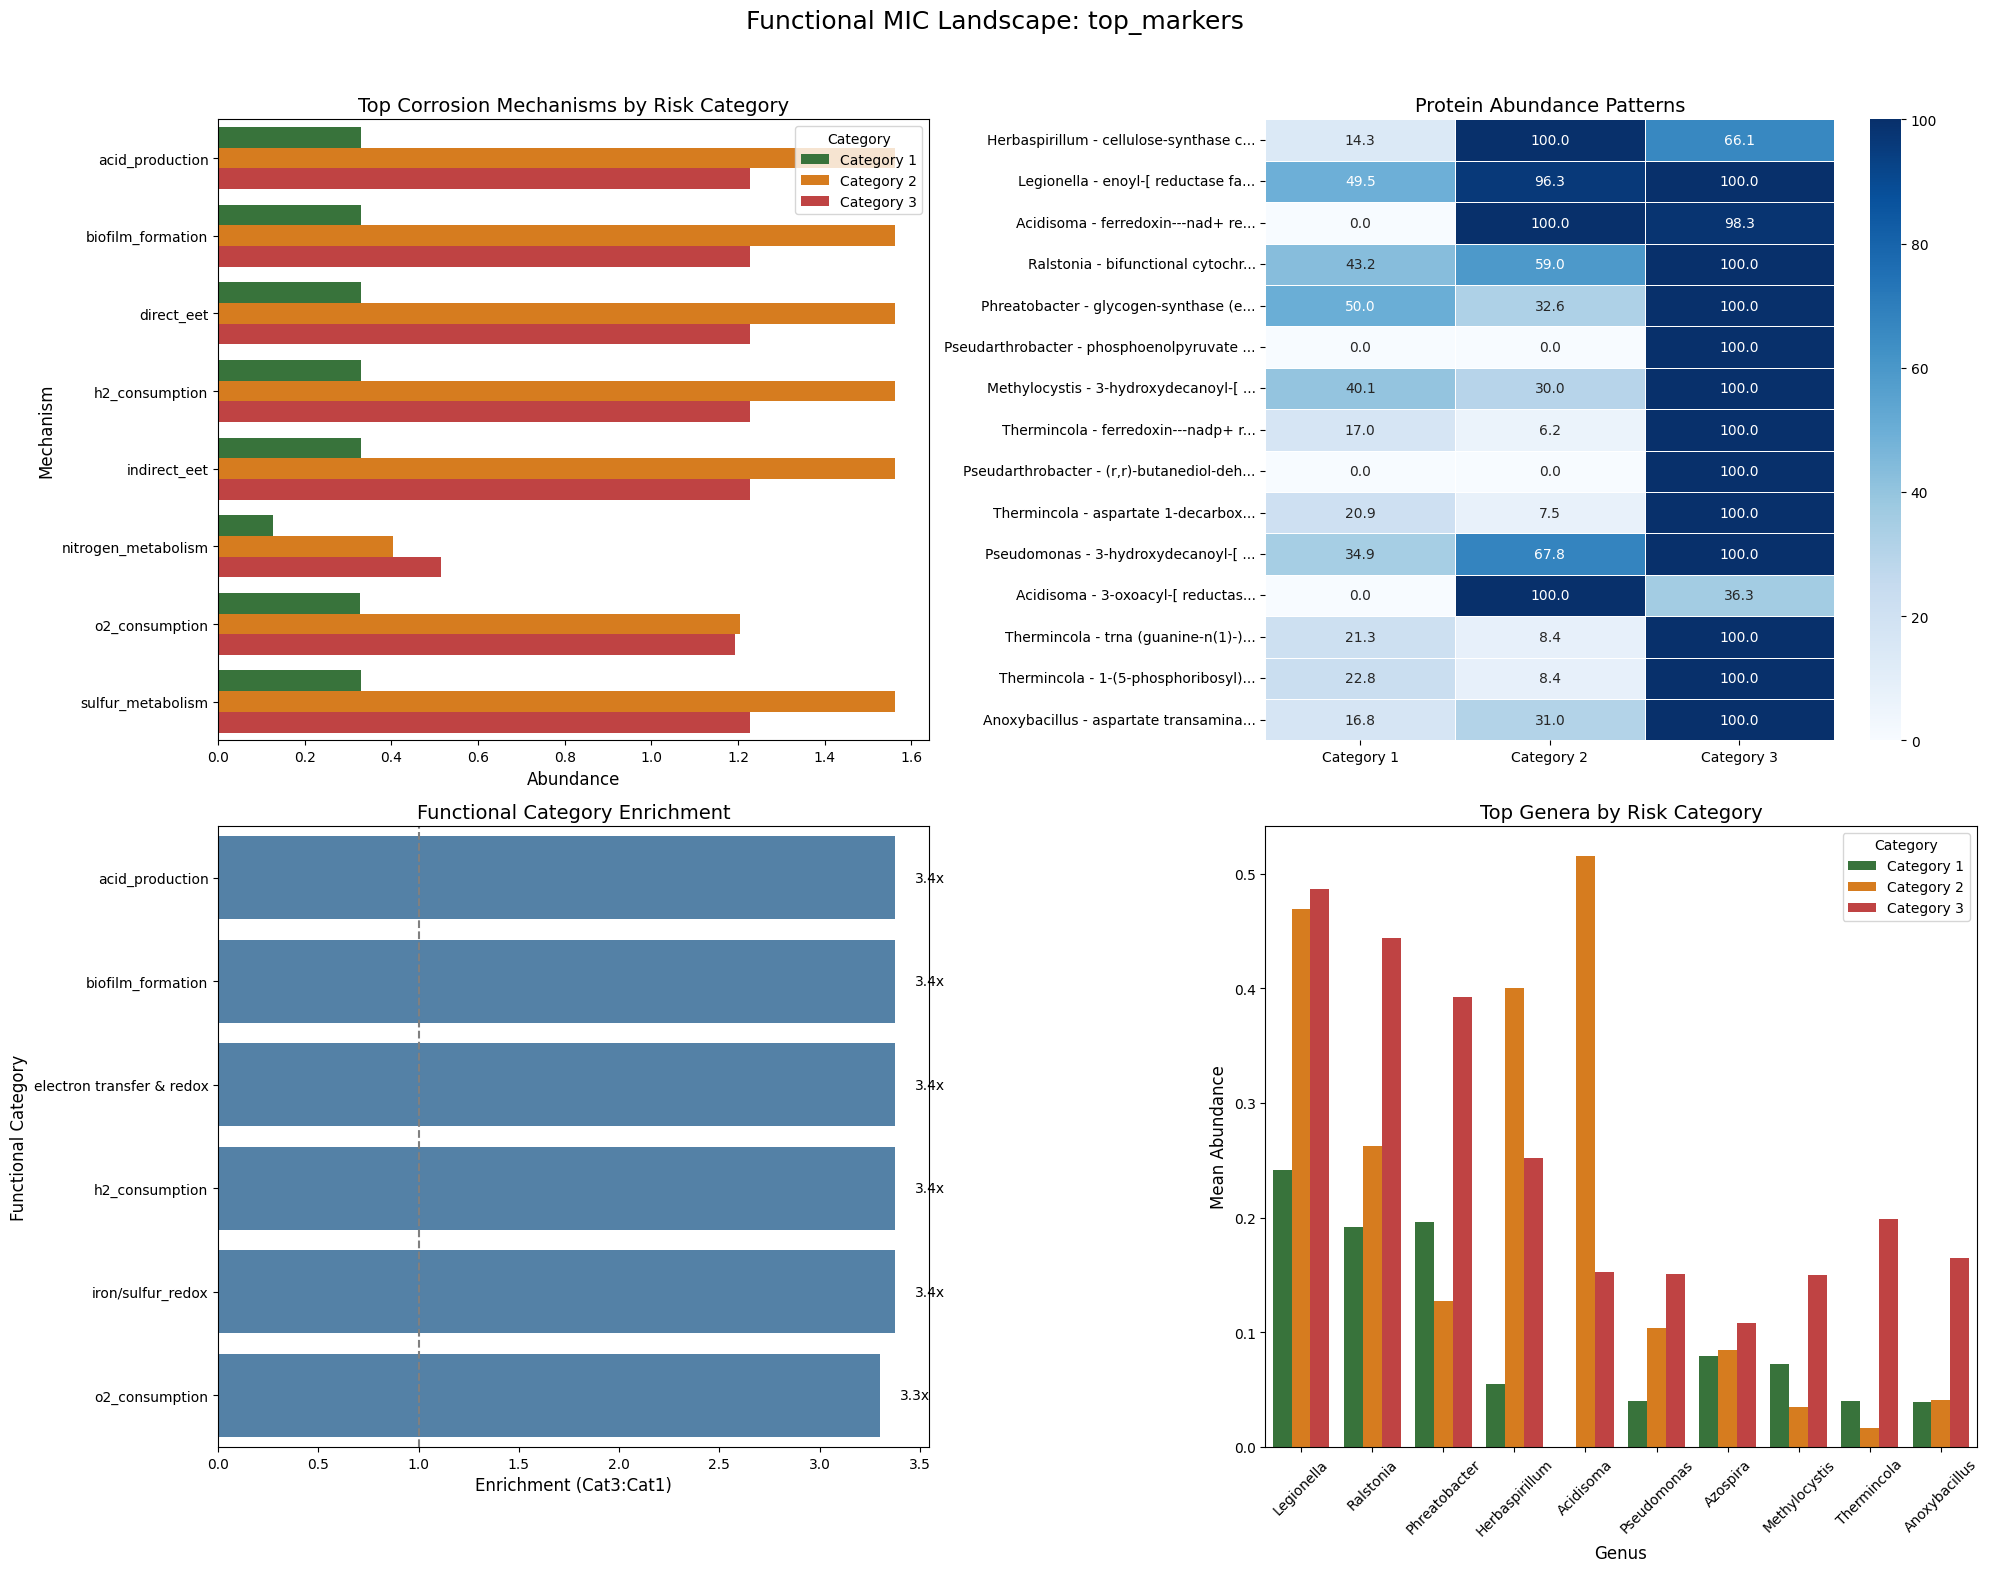

In [28]:
fig = plot_multiview_functional_landscape(top_markers, "top_markers", top_n=150)

output_path = shared_dir / "1_land.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')
fig.show()

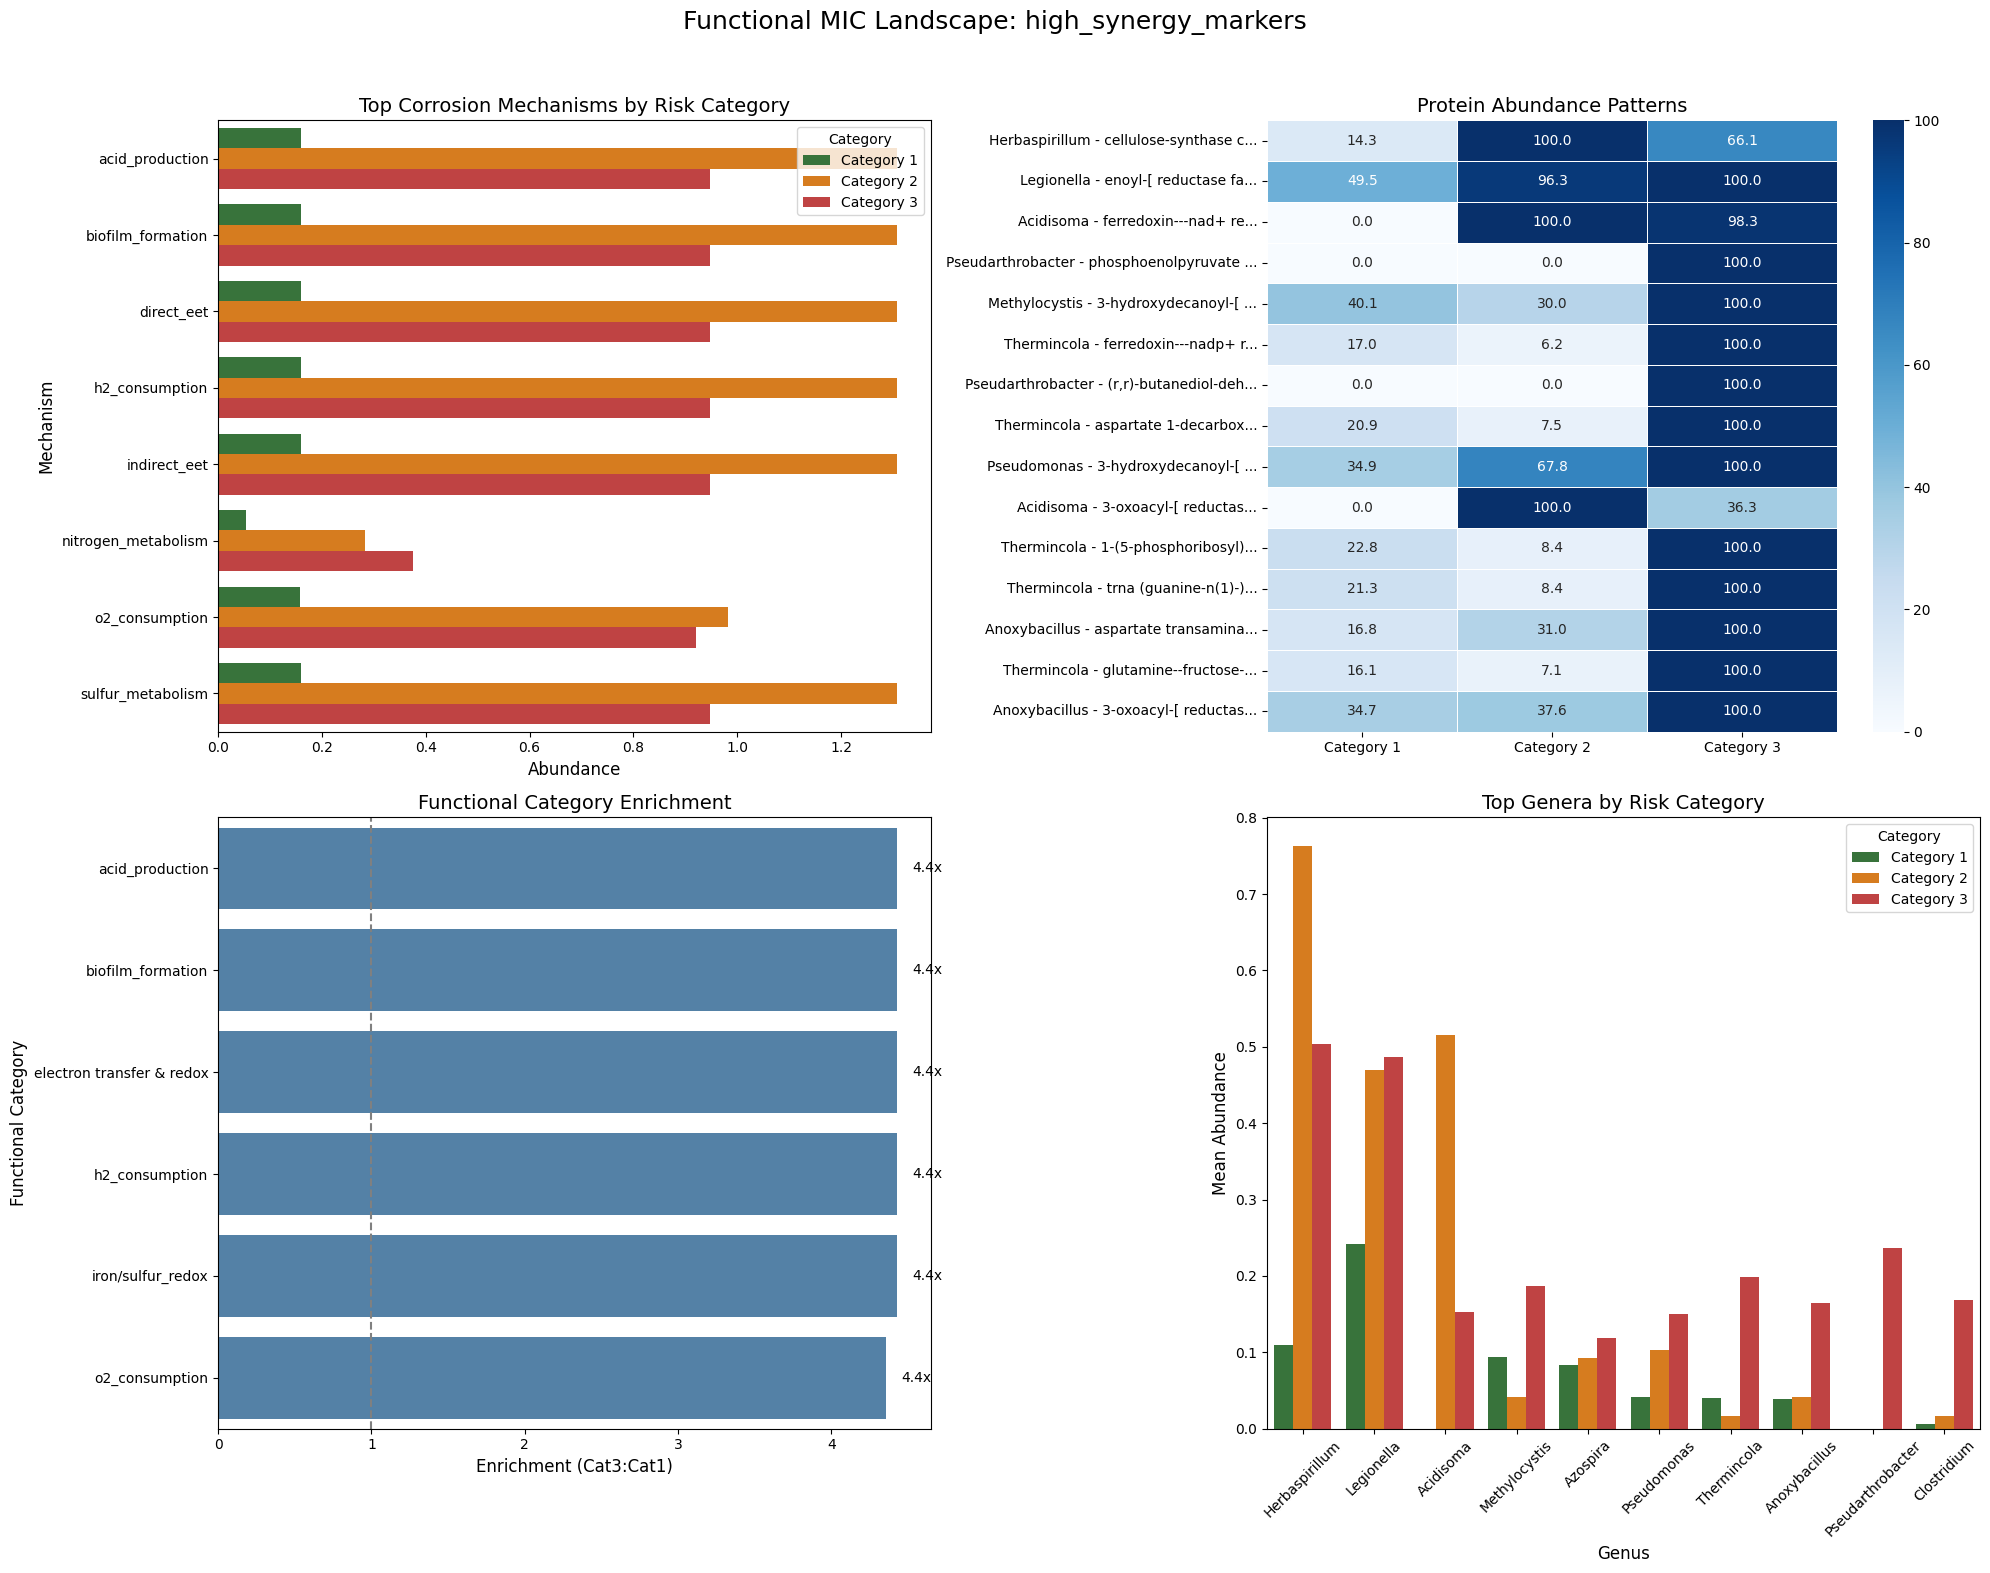

In [29]:
plot_multiview_functional_landscape(high_synergy_markers,"high_synergy_markers", top_n=100)

output_path = shared_dir / "2_land.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

The prominence of acid production, direct eet, H2 consumption and sulphate production is expected on the the top mechanism at the granular level gives good consistency to the filtering pipeline. The plot for very_high_specificity group shows that the H2 consumption mechanism and the acid production predominate for that group.

## 3.2. Comparison of Mechanism by Category methodology

In [30]:
def corrosion_mechanism_original_vs_mean(top_markers, name="Comparison", top_n=10):
    """
    Create a comparison plot showing corrosion mechanisms using:
    1. Original Category (left subplot)
    2. Mean categories (right subplot)
    
    Parameters:     top_markers : DataFrame   containing the data with columns:   Category, corrosion_mechanisms, norm_abund_contri, mean_cat1, mean_cat2, mean_cat3
    name : str, optional to include in the plot title, by default "Comparison"
    top_n : int, optional    Number of top mechanisms to display, by default 10
    save_path : str, optional    Path to save the output figure, by default None
        
    Returns:  fig : matplotlib.figure.Figure  
    """
    # Define colors and categories for original Category
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    # Define colors for mean categories
    mean_colors = {
        'mean_cat1': '#008800',  # Dark green
        'mean_cat2': '#FF8C00',  # Dark orange
        'mean_cat3': '#FF0000'   # Red
    }
    
    # Mean category labels for the legend
    mean_labels = {
        'mean_cat1': 'Normal Operation (Mean)',
        'mean_cat2': 'Early Warning (Mean)',
        'mean_cat3': 'System Failure (Mean)'
    }
    
    # Select top markers by score
    top_markers = top_markers.copy(deep=False)
    
    # Ensure Category is integer type to prevent mapping issues
    top_markers['Category'] = top_markers['Category'].astype(int)
    
    # Create figure with multiple subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # 1. FIRST PLOT: Original Category (left)
    mech_by_category = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    mech_by_category.append({
                        'Mechanism': mech,
                        'Category': int(row['Category']),  # Ensure integer type
                        'norm_abund_contri': row['norm_abund_contri']
                    })
    
    # Convert to DataFrame and aggregate
    mech_df = pd.DataFrame(mech_by_category)
    
    # Check if we have mechanisms data to plot
    if not mech_df.empty:
        # Group by mechanism and original category, summing abundance
        agg_mech = mech_df.groupby(['Mechanism', 'Category'])['norm_abund_contri'].sum().reset_index(name='Abundance')
        
        # Sort by abundance and get top mechanisms
        top_mechanisms = agg_mech.groupby('Mechanism')['Abundance'].sum().nlargest(top_n).index
        agg_mech = agg_mech[agg_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with consistent category colors
        sns.barplot(
            data=agg_mech,
            x='Abundance',
            y='Mechanism',
            hue='Category',
            palette=category_colors,
            ax=ax1
        )
        
        # Ensure legend shows categories with proper labels
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles, labels=[categories_labels[int(label)] for label in labels])
        ax1.set_title(f"Top Corrosion Mechanisms - {name}\nBy Original Category", fontsize=14)
        ax1.set_xlabel('Abundance', fontsize=12)
        ax1.set_ylabel('Mechanism', fontsize=14)
    else:
        ax1.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax1.set_title('Top Corrosion Mechanisms by Original Category', fontsize=14)
    
    # 2. SECOND PLOT: Mean categories (right)
    mech_by_mean = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            # Get mean values
            mean_cat1 = row.get('mean_cat1', 0)
            mean_cat2 = row.get('mean_cat2', 0)
            mean_cat3 = row.get('mean_cat3', 0)
            
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    # Add entry for each category with its corresponding mean value
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat1',
                        'Abundance': mean_cat1 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat2',
                        'Abundance': mean_cat2 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat3',
                        'Abundance': mean_cat3 * row['norm_abund_contri']
                    })
    
    # Convert to DataFrame for mean categories
    mean_mech_df = pd.DataFrame(mech_by_mean)
    
    # Second plot - mean categories
    if not mean_mech_df.empty:
        # Use the same top mechanisms as in the first plot for consistency
        # Aggregate by mechanism and mean category
        agg_mean_mech = mean_mech_df.groupby(['Mechanism', 'Mean_Category'])['Abundance'].sum().reset_index()
        
        # Filter to the same top mechanisms from the first plot for consistency
        agg_mean_mech = agg_mean_mech[agg_mean_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with mean category colors
        sns.barplot(
            data=agg_mean_mech,
            x='Abundance',
            y='Mechanism',
            hue='Mean_Category',
            palette=mean_colors,
            ax=ax2
        )
        
        # Update legend with readable mean category labels
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles=handles, labels=[mean_labels[label] for label in labels])
        
        ax2.set_title(f"Top Corrosion Mechanisms - {name}\nBy Mean Categories", fontsize=14)
        ax2.set_xlabel('Abundance', fontsize=14)
        ax2.set_ylabel('', fontsize=14)  
    else:
        ax2.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax2.set_title('Top Corrosion Mechanisms by Mean Categories', fontsize=14)
    
    plt.tight_layout(pad=2)
    
    return fig


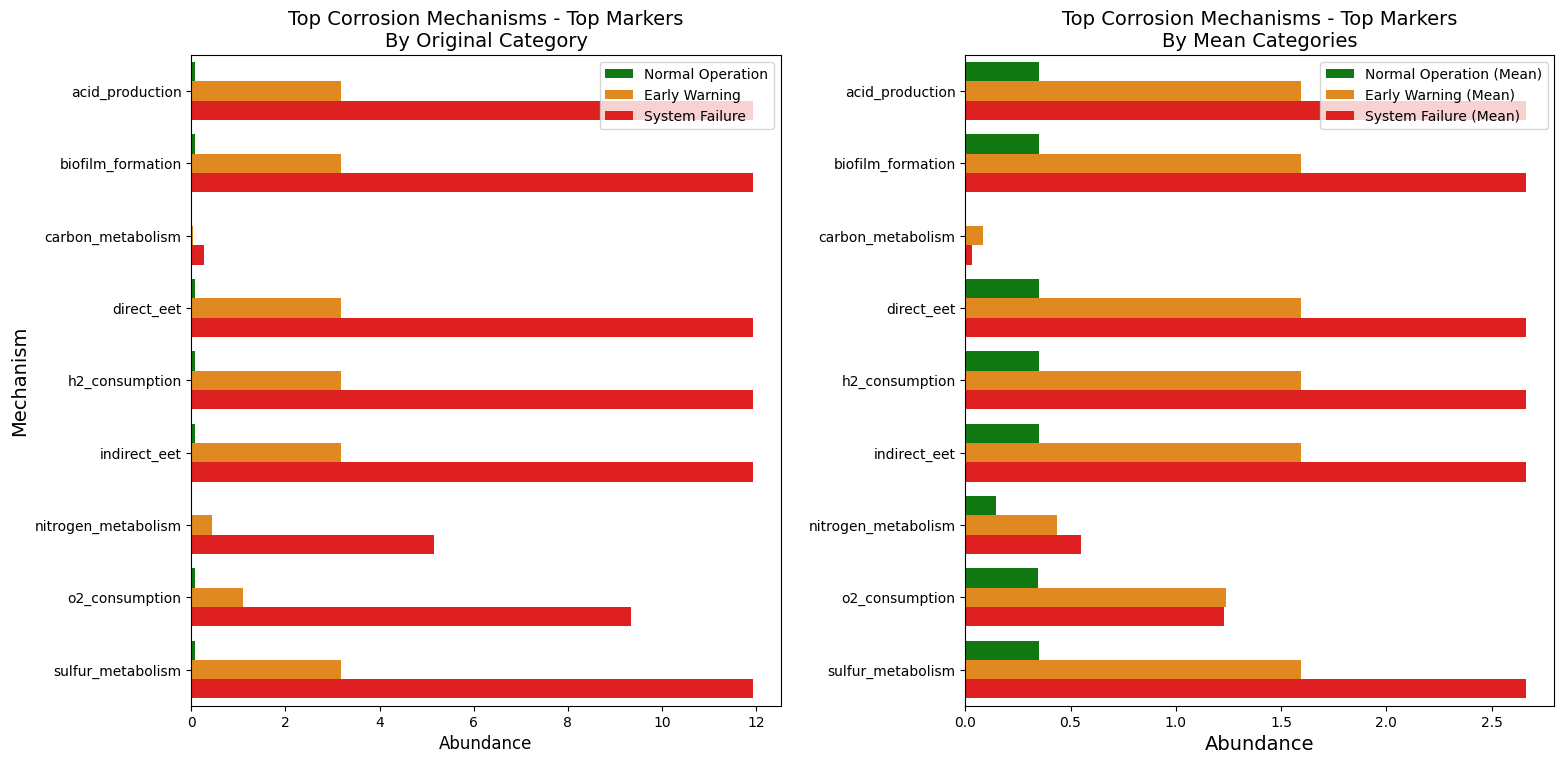

In [31]:
#Calling the function:
fig = corrosion_mechanism_original_vs_mean(top_markers, "Top Markers",  top_n=50)

output_path = shared_dir / "3_mech.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

The use of the original column of category and the mean shows that the mean actually try to homogenise the data on a way, however the main metabolisms remain to be the same first the H2 consumption , followed by direct electron transference, acid production and sulfur metabolism on top markers. 

## 3.3 Pathway Data across Risk Categories

### MultiPathway Analysis

In [32]:
def plot_pathway_analysis(prioritized_markers, name, top_n=100):
    """
    Creates comprehensive visualizations of pathway data across risk categories,
    using pre-existing categorized data in the dataframe.
    """
    # Select top markers based on combined score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)
    
    # Extract unique pathway categories from pathway_matches column
    # This uses the existing pathway categories 
    pathway_categories_count = {}
    for matches in top_markers['pathway_matches'].dropna():
        if isinstance(matches, str):
            # Split categories which are separated by semicolons
            categories = [cat.strip() for cat in matches.split(';')]
            for category in categories:
                if category:  # Skip empty strings
                    pathway_categories_count[category] = pathway_categories_count.get(category, 0) + 1
    
    # Convert to DataFrame for plotting
    category_df = pd.DataFrame({
        'Category': list(pathway_categories_count.keys()), 
        'Count': list(pathway_categories_count.values())
    }).sort_values('Count', ascending=False)
    
    # Prepare data for pathway analysis using existing category data
    pathway_data = []
    for _, row in top_markers.iterrows():
        if pd.notna(row['pathway_matches']) and row['pathway_matches']:
            categories = [cat.strip() for cat in row['pathway_matches'].split(';')]
            for category in categories:
                if category:
                    pathway_data.append({
                        'Pathway': category,  # Using the match as a pathway identifier
                        'Category': category, # The category is the same as the pathway in this case
                        'Category 1': row['mean_cat1'] if pd.notna(row['mean_cat1']) else 0,
                        'Category 2': row['mean_cat2'] if pd.notna(row['mean_cat2']) else 0,
                        'Category 3': row['mean_cat3'] if pd.notna(row['mean_cat3']) else 0,
                    })
    
    pathway_df = pd.DataFrame(pathway_data)
    
    # Aggregate pathway data by category (using existing categorization)
    agg_pathway = pathway_df.groupby('Category').agg({
        'Category 1': 'mean', 
        'Category 2': 'mean', 
        'Category 3': 'mean'
    }).reset_index()
    
    # Use existing fold_change_3vs1 where possible, otherwise calculate
    # Calculate Category 3 to Category 1 ratio with protection against zero division
    agg_pathway['Cat3_to_Cat1_Ratio'] = agg_pathway.apply(
        lambda x: x['Category 3'] / x['Category 1'] if x['Category 1'] > 0 else 
                (10 if x['Category 3'] > 0 else 1), 
        axis=1
    )
    
    # Sort by ratio (high to low)
    agg_pathway = agg_pathway.sort_values('Cat3_to_Cat1_Ratio', ascending=False)
    
    # Create visualization subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Plot 1: Category Distribution (same as before)
    sns.barplot(data=category_df, x='Count', y='Category', color='skyblue', ax=axes[0, 0])
    for i, bar in enumerate(axes[0, 0].patches):
        axes[0, 0].text(
            bar.get_width() + 0.3, 
            bar.get_y() + bar.get_height() / 2, 
            f"{int(bar.get_width())}", 
            ha='left', va='center', fontsize=12
        )
    axes[0, 0].set_title('Distribution of Pathway Categories', fontsize=18)
    axes[0, 0].tick_params(axis='both', labelsize=14)
    
    # Build network graph using existing category data
    G = nx.Graph()
    
    # Add category nodes using existing pathway categories
    for category, count in pathway_categories_count.items():
        G.add_node(category, size=count, group=1)
    
    # Add genus nodes (top 10)
    genera_counts = top_markers['Genus'].value_counts().head(10)
    for genus, count in genera_counts.items():
        G.add_node(genus, size=count * 3, group=2)
    
    # Add edges between genera and categories using functional_categories_present
    for _, row in top_markers.iterrows():
        genus = row['Genus']
        if genus not in genera_counts:
            continue
        # functional_categories_present: provides the relationships between genera and functional categories for the network graph    
        if isinstance(row['functional_categories_present'], str) and row['functional_categories_present']:
            categories = [cat.strip() for cat in row['functional_categories_present'].split(';')]
            categories_added = set()
            
            for category in categories:
                if category in pathway_categories_count and category not in categories_added:
                    if not G.has_edge(genus, category):
                        G.add_edge(genus, category, weight=1)
                    else:
                        G[genus][category]['weight'] += 1
                    categories_added.add(category)
    
    # Plot 2: Category enrichment ratio (same as before)
    sns.barplot(data=agg_pathway, x='Cat3_to_Cat1_Ratio', y='Category', color='steelblue', ax=axes[1, 0])
    for i, bar in enumerate(axes[1, 0].patches):
        ratio_value = agg_pathway.iloc[i]['Cat3_to_Cat1_Ratio']
        axes[1, 0].text(
            bar.get_width() + 0.02, 
            bar.get_y() + bar.get_height() / 2, 
            f"{ratio_value:.2f}x", 
            ha='left', va='center', fontsize=12
        )
    axes[1, 0].axvline(x=1, color='gray', linestyle='--')
    axes[1, 0].set_title('Pathway Category Enrichment in High Risk (Cat3:Cat1 Ratio)', fontsize=18)
    axes[1, 0].tick_params(axis='both', labelsize=14)
    
    # Plot 3: Heatmap of category abundance (same as before)
    heatmap_data = agg_pathway.set_index('Category')[['Category 1', 'Category 2', 'Category 3']].fillna(0)
    for idx in heatmap_data.index:
        row_max = heatmap_data.loc[idx].max()
        if row_max > 0:
            heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)
    
    sns.heatmap(
        heatmap_data, 
        cmap='Blues', 
        annot=True, 
        fmt=".1f", 
        linewidths=0.5, 
        ax=axes[0, 1], 
        vmin=0, 
        vmax=100, 
        annot_kws={"size": 12}
    )
    axes[0, 1].set_title('Pathway Category Abundance Patterns (% of max)', fontsize=18)
    axes[0, 1].tick_params(axis='both', labelsize=14)
    
    # Plot 4: Network visualization (same as before)
    pos = nx.spring_layout(G, k=1.2, seed=42)
    
    category_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 1]
    genera_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 2]
    
    node_sizes_cat = [G.nodes[node].get('size', 10) * 20 for node in category_nodes]
    node_sizes_gen = [G.nodes[node].get('size', 10) * 20 for node in genera_nodes]
    
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color='lightblue', 
                          node_size=node_sizes_cat, alpha=0.8, ax=axes[1, 1])
    nx.draw_networkx_nodes(G, pos, nodelist=genera_nodes, node_color='lightgreen', 
                          node_size=node_sizes_gen, alpha=0.8, ax=axes[1, 1])
    
    edge_weights = [G[u][v].get('weight', 1) / 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, ax=axes[1, 1])
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', ax=axes[1, 1])
    
    axes[1, 1].set_title('Genus-Pathway Category Network', fontsize=18)
    axes[1, 1].axis('off')
    
    # Overall layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"Pathways Categories for {name}", fontsize=18, y=0.98)
    
    return fig, category_df, agg_pathway

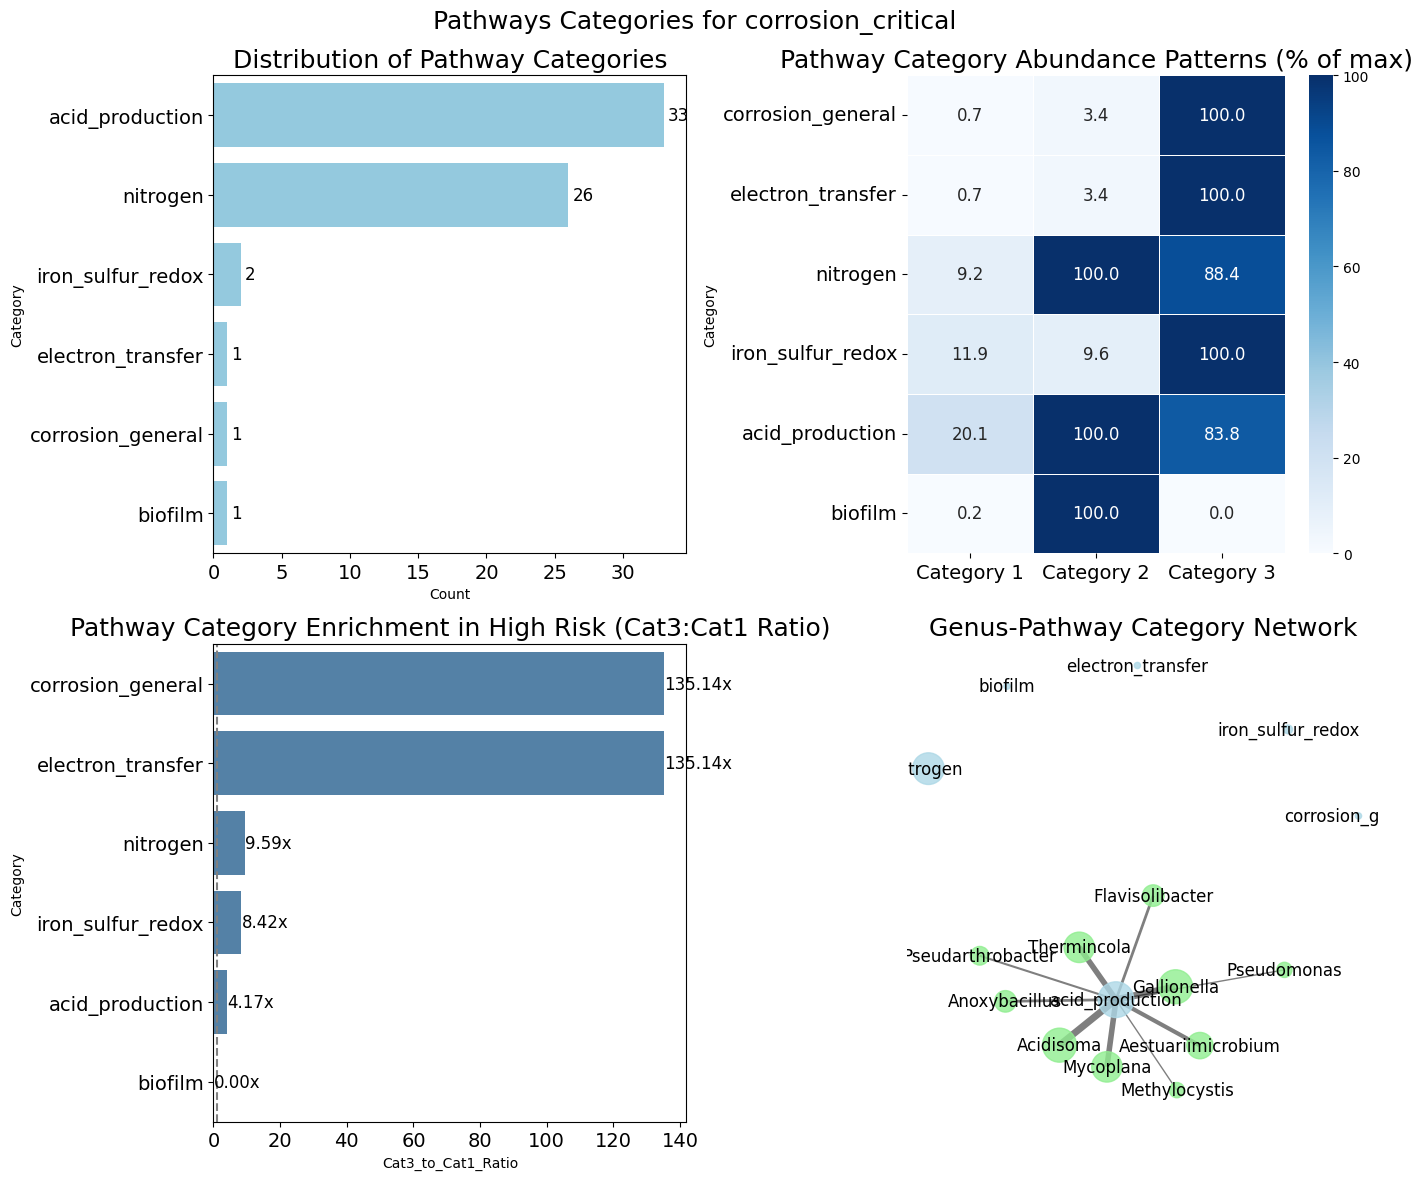

<Figure size 640x480 with 0 Axes>

In [33]:
fig, category_df, agg_pathway = plot_pathway_analysis(corrosion_critical, "corrosion_critical", top_n=100) 
plt.show()

output_path = shared_dir / "4_pathw.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

For the top markers group, the dominance of lipid metabolism is interesting...
for the high prevalence has the genera that prevale on each category, so the major metabolism is the biofilm formation which is also the one when it get enrich, that is because the biofilm produce an specialise environment where the bacteria thrive and prevail. It follows the protein metabolism with is important for survival, the degradation pathway which involves using the substrates from the env

## 3.4 Network Analysis of Corrosion Mechanisms

### Static Network

In [34]:
def create_static_network(df, name, top_n=20, threshold=0.5):
    """
    Creates an improved static network visualization of genus-protein-mechanism relationships.
    
    Args:
        df: DataFrame containing marker data with required columns
        name: Name to include in plot title
        top_n: Number of top markers to include
        threshold: Edge weight threshold (0.0-1.0)
        
    Returns:
        G: NetworkX graph object
    """
    # Define colors for node types with improved color scheme
    node_colors = {
        'genus': 'Blue',     
        'protein': 'Purple',    
        'mechanism': 'Brown'   
    }
    
    # Check required columns
    required_cols = ['Genus', 'protein_name', 'combined_score', 'corrosion_mechanisms']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None
    
    # Create network
    G = nx.Graph()
    
    # Get top markers
    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)
    
    # Process rows and build network
    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])
        
        # Skip if missing data
        if pd.isna(genus) or pd.isna(protein):
            continue
            
        # Trim protein name if too long
        protein_short = protein[:27] + "..." if len(protein) > 30 else protein
        
        # Add nodes if they don't exist
        if not G.has_node(genus):
            G.add_node(genus, type='genus')
        
        if not G.has_node(protein_short):
            G.add_node(protein_short, type='protein')
        
        # Add edge between genus and protein with weight from score
        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        # Normalize score for visualization if needed
        norm_score = min(score / 50, 1.0)  # Adjust divisor based on your score range
        G.add_edge(genus, protein_short, weight=norm_score)
        
        # Add mechanism nodes and edges
        mechanisms_col = row.get('corrosion_mechanisms', '')
        if isinstance(mechanisms_col, str) and mechanisms_col:
            mechanisms = [mech.strip() for mech in mechanisms_col.split(';') if mech.strip()]
            for mech in mechanisms:
                if not G.has_node(mech):
                    G.add_node(mech, type='mechanism')
                G.add_edge(protein_short, mech, weight=0.7)  # Set standard weight for mechanism connections
    
    # Detect communities for node coloring
    partition = community_louvain.best_partition(G)
    
    # Assign communities to nodes
    nx.set_node_attributes(G, partition, 'community')
    
    # Calculate node sizes based on degree centrality
    degree_dict = dict(G.degree())
    # Scale node sizes - genera larger than proteins larger than mechanisms
    node_sizes = {}
    for node in G.nodes():
        base_size = 800 if G.nodes[node].get('type') == 'genus' else (
                    500 if G.nodes[node].get('type') == 'protein' else 600)
        # Adjust size by degree with diminishing returns for very high degrees
        node_sizes[node] = base_size * (1 + np.log1p(degree_dict[node]) / 2)
    
    # Prepare for visualization with larger figure size
    plt.figure(figsize=(18, 14))
    
    # Position nodes using force-directed layout with increased separation
    pos = nx.spring_layout(G, k=0.5, seed=42, iterations=100)  # Increased k and iterations
    
    # Draw edges with width based on weight
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, alpha=0.4, width=edge_weights)
    
    # Draw nodes by type with different colors
    for node_type, color in node_colors.items():
        nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
        nx.draw_networkx_nodes(G, pos, 
                              nodelist=nodes, 
                              node_color=color,
                              node_size=[node_sizes[node] for node in nodes],
                              alpha=0.85)
    # Genus labels - bold
    genera_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'genus'}
    nx.draw_networkx_labels(G, pos, labels=genera_labels, font_size=12, font_weight='bold', 
                           font_color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    # Protein labels - smaller, no bbox
    protein_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'protein'}
    nx.draw_networkx_labels(G, pos, labels=protein_labels, font_size=8, 
                           font_color='black')
    
    # Mechanism labels - medium size, with bbox
    mech_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'mechanism'}
    nx.draw_networkx_labels(G, pos, labels=mech_labels, font_size=10, 
                           font_color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))
    
    # Create legend with larger markers
    plt.plot([0], [0], 'o', color=node_colors['genus'], markersize=12, label='Genus')
    plt.plot([0], [0], 'o', color=node_colors['protein'], markersize=10, label='Protein')
    plt.plot([0], [0], 'o', color=node_colors['mechanism'], markersize=11, label='Mechanism')
    
    plt.legend(loc='upper right', frameon=True, fontsize=12)
    plt.title(f"{name} Network of Top {top_n} Corrosion Markers", fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    
    # Add a white background to make the visualization more printable
    plt.gca().set_facecolor('white')
    plt.gcf().set_facecolor('white')
    
    return G

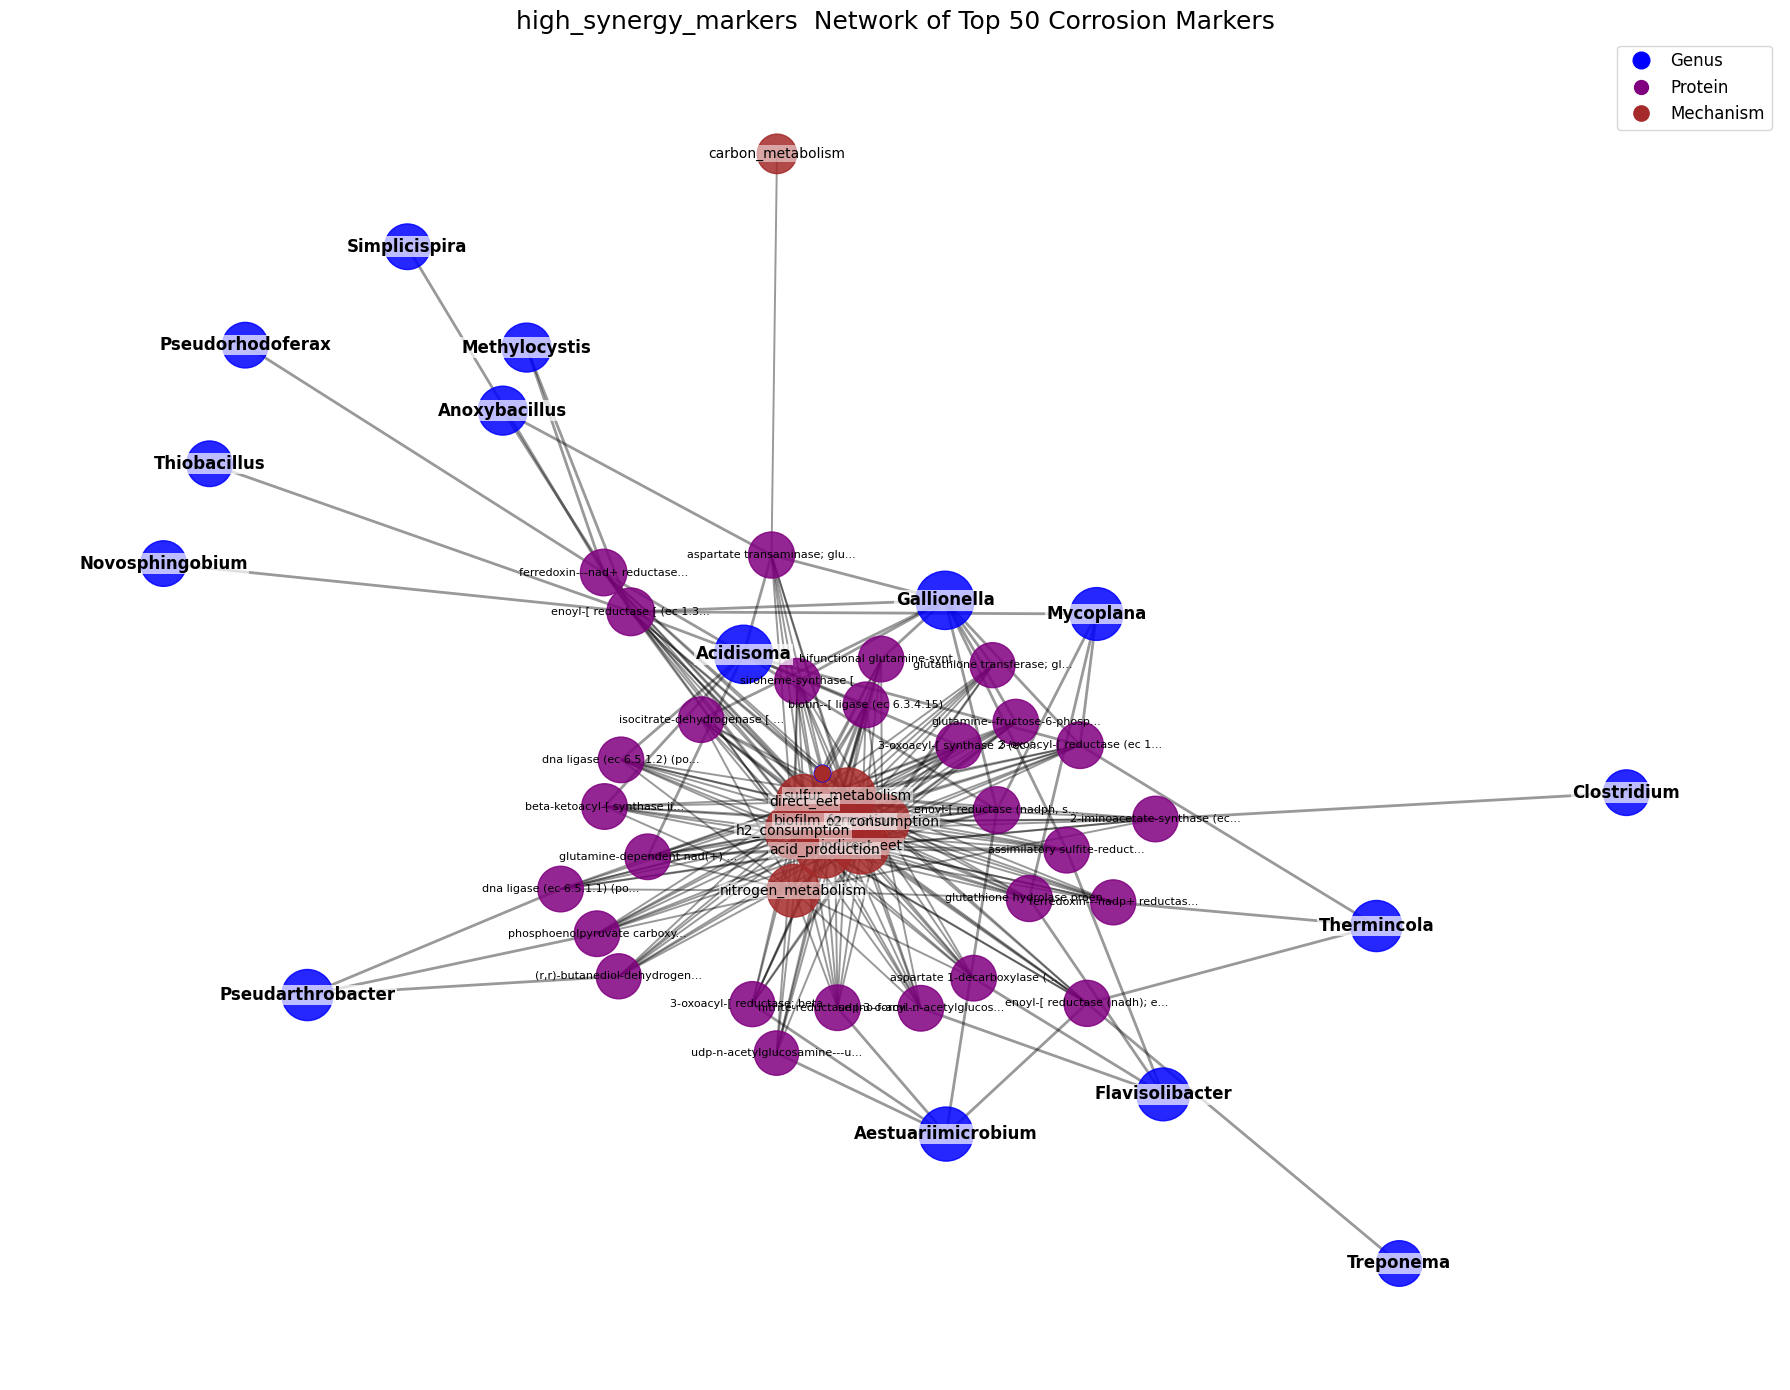

In [35]:
create_static_network(high_synergy_markers ,"high_synergy_markers " ,top_n=50, threshold=0.5)

output_path = shared_dir / "7_network.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')


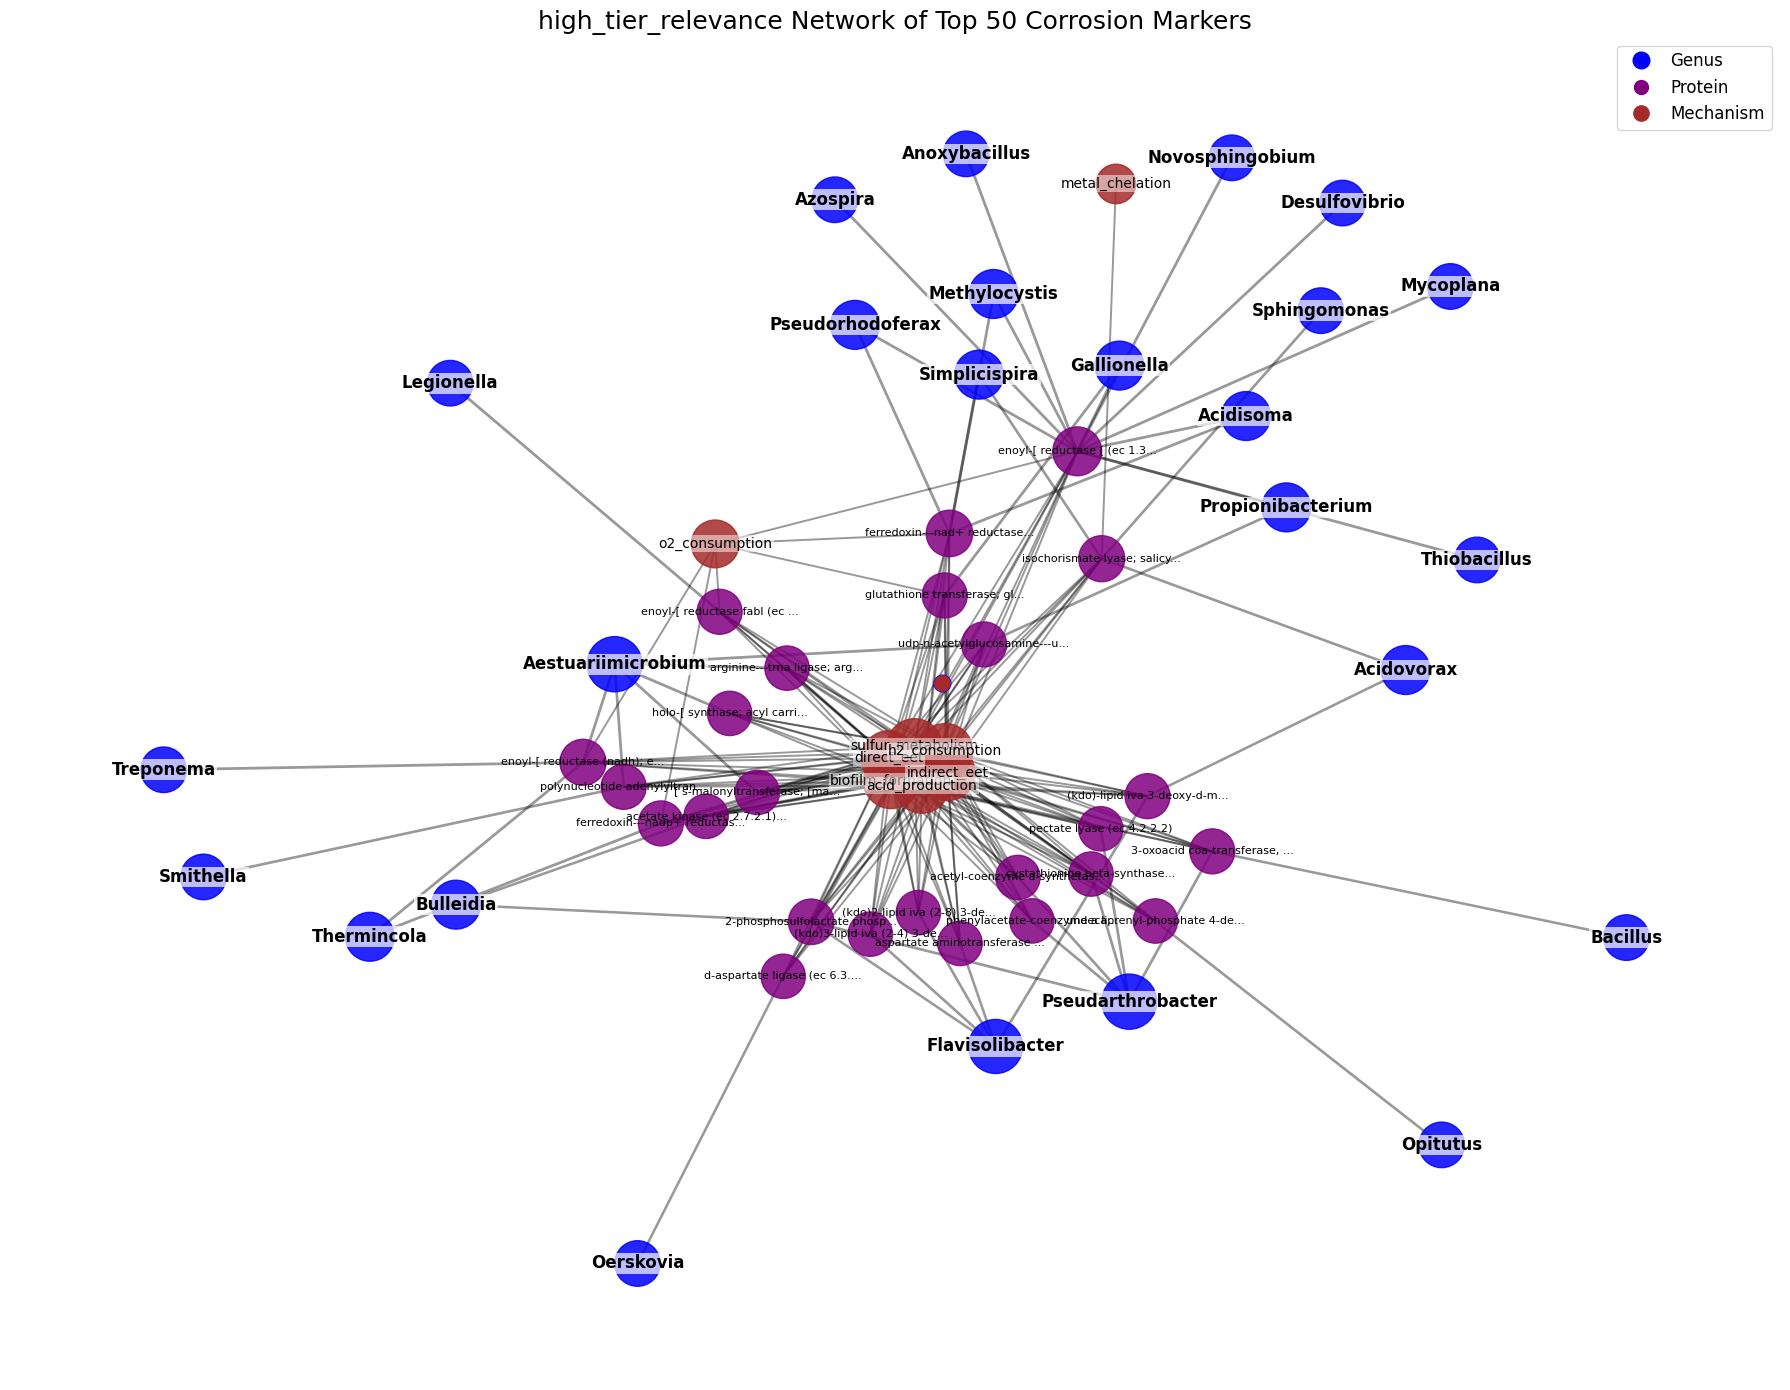

In [36]:

create_static_network(high_tier_relevance,"high_tier_relevance" ,top_n=50, threshold=0.5)
output_path = shared_dir / "8_network.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

## 3.5. Temporal Transition and Mechanisms Distribution by Risk Categories
### Temporal Transition by Risk Categories

In [37]:
def temporal_transition(prioritized_markers, name):
    """
    Creates a Sankey diagram showing the flow of proteins between risk categories.
    Preserves your existing naming convention using 'Category'.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from matplotlib.colors import rgb2hex
    import numpy as np
    import plotly.graph_objects as go
    
    # Make a copy to avoid modifying the original dataframe
    sig_results = prioritized_markers.copy(deep=False)
    
    # Normalize mechanism names while preserving original column
    if 'corrosion_mechanisms' in sig_results.columns and sig_results['corrosion_mechanisms'].notna().any():
        sig_results['_mech_temp'] = sig_results['corrosion_mechanisms'].copy()
        sig_results['_mech_temp'] = sig_results['_mech_temp'].str.replace('o2_consumption', 'O2_consumption')
        sig_results['_mech_temp'] = sig_results['_mech_temp'].str.replace('h2_consumption', 'H2_consumption')
    else:
        print("Warning: No 'corrosion_mechanisms' column found or all values are NaN")
        return None

    # Create category dominance for each protein-genus pair
    # Using mean_cat columns to determine dominance
    if all(col in sig_results.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3']):
        sig_results['dominant_category'] = sig_results[['mean_cat1', 'mean_cat2', 'mean_cat3']].idxmax(axis=1)
        sig_results['dominant_category'] = sig_results['dominant_category'].map({
            'mean_cat1': 'Category 1',
            'mean_cat2': 'Category 2',
            'mean_cat3': 'Category 3'
        })
        
        print(f"Distribution by dominant category: {sig_results['dominant_category'].value_counts().to_dict()}")
    else:
        print("Warning: Missing required mean_cat columns")
        return None

    # Determine the best separator for corrosion mechanisms
    flow_data = []
    mechanisms_set = set()
    best_separator = ';'  # Default separator
    
    # Try different separators and use the one that finds the most mechanisms
    for separator in [';', ',', '|']:
        test_count = sum(
            [len([m for m in str(mech).split(separator) if m.strip()]) 
             for mech in sig_results['_mech_temp'] if isinstance(mech, str)]
        )
        
        if test_count > 0:
            best_separator = separator
            break
    
    # Use the best separator to extract mechanisms
    for _, row in sig_results.iterrows():
        if isinstance(row['_mech_temp'], str) and row['_mech_temp']:
            mechanisms = [m.strip() for m in row['_mech_temp'].split(best_separator) if m.strip()]

            for m in mechanisms:
                mechanisms_set.add(m)  # Track all unique mechanisms

                # Add a flow from mechanism to dominant category
                flow_data.append({
                    'source': m,
                    'target': row['dominant_category'],
                    'value': 1,  # Count each protein once
                    'genus': row['Genus'] if 'Genus' in row else 'Unknown',
                    'protein': row['protein_name'] if 'protein_name' in row else 'Unknown'
                })

    # Convert to DataFrame
    flow_df = pd.DataFrame(flow_data)

    # Print some diagnostic info
    print(f"\nNumber of unique mechanisms: {len(mechanisms_set)}")
    print(f"Number of flows: {len(flow_df)}")

    # Check if we have any data before proceeding
    if len(flow_df) == 0:
        print("No flows found. Check the corrosion_mechanisms data format.")
        return None

    # Define the order of mechanisms according to energy requirements
    mechanism_order = [
        "O2_consumption",
        "nitrogen_metabolism", 
        "H2_consumption",
        "iron_metabolism",
        "sulfur_metabolism",
        "direct_eet",
        "indirect_eet",    
        "acid_production",
        "carbon_metabolism",
        "biofilm_formation",
        "ph_modulation",  
        "metal_chelation",     
    ]

    # Filter to only include mechanisms that exist in the data
    mechanisms = [m for m in mechanism_order if m in mechanisms_set]

    # Add any mechanisms that weren't in the predefined order
    other_mechanisms = sorted(list(mechanisms_set - set(mechanism_order)))
    mechanisms.extend(other_mechanisms)

    # Categories in order - using your original naming
    categories = ['Category 1', 'Category 2', 'Category 3']
    all_nodes = mechanisms + categories

    # Map source and target to indices
    node_indices = {node: i for i, node in enumerate(all_nodes)}

    flow_df['source_idx'] = flow_df['source'].map(node_indices)
    flow_df['target_idx'] = flow_df['target'].map(node_indices)

    # Aggregate flows by source and target
    agg_flows = flow_df.groupby(['source_idx', 'target_idx']).size().reset_index(name='value')

    # Define node colors - use specified category colors
    category_colors = {
        'Category 1': '#2E7D32',  # Darker green for better visibility
        'Category 2': '#F57C00',  # Darker orange 
        'Category 3': '#D32F2F'   # Darker red
    }

    # Generate mechanism colors using a more distinct colormap
    cmap = plt.cm.get_cmap('viridis', len(mechanisms))
    mechanism_colors = {m: rgb2hex(cmap(i)[:3]) for i, m in enumerate(mechanisms)}

    # Combine all colors
    node_colors = [mechanism_colors.get(node, '#9467bd') if node in mechanisms
                  else category_colors.get(node, '#1f77b4') for node in all_nodes]

    # Create labels with proper formatting
    labels = []
    for node in all_nodes:
        if node in mechanisms:
            # Format mechanism names for readability
            labels.append(node.replace('_', ' ').title())
        else:
            # Keep category names as is
            labels.append(node)

    # Create Sankey diagram with improved layout
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",  # Help prevent overlapping
        node=dict(
            pad=20,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
            hovertemplate="<b>%{label}</b><br>Count: %{value}<extra></extra>"
        ),
        link=dict(
            source=agg_flows['source_idx'],
            target=agg_flows['target_idx'],
            value=agg_flows['value'],
            hovertemplate="<b>%{source.label}</b> → <b>%{target.label}</b><br>Count: %{value}<extra></extra>"
        )
    )])

    fig.update_layout(
        title_text=f"Flow of Corrosion Mechanisms to Risk Categories: {name}",
        title_font_size=16,
        font_size=14,
        height=800,
        width=1200,
        margin=dict(l=50, r=50, t=80, b=50)
    )
    
    # Add annotation explaining the diagram
    fig.add_annotation(
        x=0.5, y=1.05,
        xref="paper", yref="paper",
        text="Mechanisms are arranged by energy efficiency",
        showarrow=False,
        font=dict(size=12),
        align="center",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
        borderpad=4
    )

    return fig

In [38]:
fig = temporal_transition(classified_results, "classified_results")
fig.show()
san_path = shared_dir / "9_sankey.png"
plt.savefig(san_path, dpi=300, bbox_inches='tight')

fig = temporal_transition(significant_markers, "significant_markers")
fig.show()
san_path = shared_dir / "10_sankey.png"
plt.savefig(san_path, dpi=300, bbox_inches='tight')

Distribution by dominant category: {'Category 2': 19572, 'Category 3': 18731, 'Category 1': 11371}

Number of unique mechanisms: 11
Number of flows: 191152


/tmp/ipykernel_6066/4097121110.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(mechanisms))


Distribution by dominant category: {'Category 3': 120, 'Category 2': 42}

Number of unique mechanisms: 10
Number of flows: 927


/tmp/ipykernel_6066/4097121110.py:129: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



<Figure size 640x480 with 0 Axes>

## 3.6 Mechanism Distribution across Risk Category

In [39]:
def plot_mechanism_distribution(prioritized_markers, name, corrosion_mechanisms):
    """
    Creates stacked bar charts showing mechanism distribution across risk categories.
    Uses existing columns instead of recalculating.
    """
    # Define colors and categories
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    # Work directly with the existing data - no recalculation needed
    # The corrosion_mechanisms column already contains categorized mechanisms
    mechanism_data = []
    
    for _, row in prioritized_markers.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            # Split mechanisms if they're in a single cell, semicolon-separated
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            for mech in mechanisms:
                mechanism_data.append({
                    'mechanism': mech,
                    'mean_cat1': row['mean_cat1'],
                    'mean_cat2': row['mean_cat2'],
                    'mean_cat3': row['mean_cat3']
                })
    
    # Convert to DataFrame and group by mechanism
    mechanism_df = pd.DataFrame(mechanism_data)
    
    # Aggregate abundance values by mechanism
    grouped = mechanism_df.groupby('mechanism').agg({
        'mean_cat1': 'sum',
        'mean_cat2': 'sum',
        'mean_cat3': 'sum'
    }).reset_index()
    
    # Calculate total abundance and get top 10
    grouped['total'] = grouped['mean_cat1'] + grouped['mean_cat2'] + grouped['mean_cat3']
    grouped = grouped.sort_values('total', ascending=False).head(10)
    
    # Prepare data for stacked bar chart
    data = []
    for risk_category, color in category_colors.items():
        column_name = f'mean_cat{risk_category}'
        data.append(
            go.Bar(
                name=f'Risk Category {risk_category}',
                x=grouped['mechanism'],
                y=grouped[column_name],
                text=grouped[column_name].round(2),
                textposition='auto',
                marker_color=color
            )
        )
    
    # Create figure
    fig = go.Figure(data=data)
    
    # Update layout
    fig.update_layout(
        barmode='stack',
        title=f"Top 10 Corrosion Mechanisms for Group {name} by Risk Category",
        xaxis_title='Corrosion Mechanisms',
        yaxis_title='Total Abundance',
        legend_title='Risk Category',
        hovermode='x',
        height=600,
        width=1000
    )
    
    return fig

In [40]:
fig1= plot_mechanism_distribution(balanced_markers , "balanced_markers ", cs.corrosion_mechanisms)
fig1.show()
mech_path = shared_dir / "11_mech.png"
plt.savefig(str(mech_path), dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

## 3.7 A  Dinamic Cluster Analysis UMAP visualizations colored by protein metadata

In [41]:
def create_dash_umap_visualization(marker_data, name):
    """
    Creates a Dash application with an interactive UMAP visualization where the 
    projection changes based on selected metadata column while maintaining risk category colors
    """
    # Create the Dash app
    app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
    
    # Get available columns for UMAP projection (excluding identifiers)
    exclude_cols = ['protein_name', 'Genus', 'idx']
    # All columns that could potentially be used for UMAP
    available_columns = [col for col in marker_data.columns if col not in exclude_cols]
    
    # Prepare risk category colors
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning  
        3: '#FF0000'   # Red - System Failure
    }
    
    app.layout = html.Div([
        html.H2("Interactive Protein UMAP Visualization", style={'textAlign': 'center', 'margin': '20px'}),
        
        dbc.Row([
            # Controls panel
            dbc.Col([
                dbc.Card([
                    dbc.CardHeader("UMAP Controls"),
                    dbc.CardBody([
                        html.Label("UMAP Feature Selection:"),
                        dcc.Dropdown(
                            id='feature-dropdown',
                            options=[
                                {'label': 'Abundance (mean_cat)', 'value': 'mean_cat'},
                                {'label': 'Fold Changes', 'value': 'fold_change'},
                                {'label': 'Combined Scores', 'value': 'combined_score'},
                                {'label': 'All Numerical', 'value': 'all_numerical'},
                                {'label': 'Custom Selection', 'value': 'custom'}
                            ],
                            value='mean_cat',
                            clearable=False
                        ),
                        html.Br(),
                        
                        # Custom feature selection (only shown when 'custom' is selected)
                        html.Div(id='custom-feature-div', children=[
                            html.Label("Select Features:"),
                            dcc.Checklist(
                                id='feature-checklist',
                                options=[{'label': col, 'value': col} for col in available_columns 
                                        if marker_data[col].dtype in ['int64', 'float64']],
                                value=[],
                                style={'maxHeight': '200px', 'overflowY': 'auto'}
                            )
                        ], style={'display': 'none'}),
                        html.Br(),
                        
                        html.Label("n_neighbors:"),
                        dcc.Slider(
                            id='n-neighbors-slider',
                            min=5,
                            max=50,
                            step=5,
                            value=15,
                            marks={i: str(i) for i in range(5, 51, 5)}
                        ),
                        html.Br(),
                        
                        html.Label("min_dist:"),
                        dcc.Slider(
                            id='min-dist-slider',
                            min=0.0,
                            max=0.9,
                            step=0.1,
                            value=0.1,
                            marks={i/10: str(i/10) for i in range(0, 10)}
                        ),
                        html.Br(),
                        
                        html.Label("Show Labels:"),
                        dbc.Checklist(
                            id='show-labels-toggle',
                            options=[
                                {'label': 'Show Labels', 'value': 'show'}
                            ],
                            value=['show']
                        ),
                        html.Br(),
                        
                        html.Label("Label Size:"),
                        dcc.Slider(
                            id='label-size-slider',
                            min=6,
                            max=14,
                            step=1,
                            value=10,
                            marks={i: str(i) for i in range(6, 15, 2)}
                        ),
                        html.Br(),
                        
                        html.Label("Point Size:"),
                        dcc.Slider(
                            id='point-size-slider',
                            min=5,
                            max=20,
                            step=1,
                            value=10,
                            marks={i: str(i) for i in range(5, 21, 5)}
                        ),
                        html.Br(),
                        
                        dbc.Button("Reset View", id="reset-button", color="primary")
                    ])
                ])
            ], width=3),
            
            # UMAP visualization
            dbc.Col([
                dcc.Loading(
                    id="loading-umap",
                    type="default",
                    children=dcc.Graph(id='umap-graph', style={'height': '80vh'})
                )
            ], width=9)
        ])
    ])
    
    @app.callback(
        Output('custom-feature-div', 'style'),
        Input('feature-dropdown', 'value')
    )
    def toggle_custom_features(feature_selection):
        if feature_selection == 'custom':
            return {'display': 'block'}
        else:
            return {'display': 'none'}
    
    @app.callback(
        Output('umap-graph', 'figure'),
        [Input('feature-dropdown', 'value'),
         Input('feature-checklist', 'value'),
         Input('n-neighbors-slider', 'value'),
         Input('min-dist-slider', 'value'),
         Input('show-labels-toggle', 'value'),
         Input('label-size-slider', 'value'),
         Input('point-size-slider', 'value'),
         Input('reset-button', 'n_clicks'),
         Input('umap-graph', 'clickData')]
    )
    def update_umap(feature_selection, custom_features, n_neighbors, min_dist, 
                    show_labels, label_size, point_size, n_clicks, click_data):
        
        # Select features based on dropdown
        if feature_selection == 'mean_cat':
            selected_features = [col for col in marker_data.columns if col.startswith('mean_cat')]
        elif feature_selection == 'fold_change':
            selected_features = [col for col in marker_data.columns if 'fold_change' in col]
        elif feature_selection == 'combined_score':
            selected_features = ['combined_score'] if 'combined_score' in marker_data.columns else []
        elif feature_selection == 'all_numerical':
            selected_features = [col for col in marker_data.columns 
                                 if marker_data[col].dtype in ['int64', 'float64']]
        elif feature_selection == 'custom':
            selected_features = custom_features if custom_features else []
        
        if not selected_features:
            return go.Figure().update_layout(
                title="Error: No features selected for UMAP projection"
            )
        
        # Extract data for selected features
        try:
            X = marker_data[selected_features].values
        except KeyError as e:
            return go.Figure().update_layout(
                title=f"Error: Features not found - {str(e)}"
            )
        
        # Create UMAP projection
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = umap_model.fit_transform(X)
        
        # Determine dominant risk category for each point
        cat_columns = ['mean_cat1', 'mean_cat2', 'mean_cat3']
        dominant_cats = marker_data[cat_columns].idxmax(axis=1).map(lambda x: int(x[-1]))
        
        # Create DataFrame for plotting
        umap_df = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'protein_name': marker_data['protein_name'].values,
            'Genus': marker_data['Genus'].values,
            'risk_category': dominant_cats.values,
            'label': marker_data['Genus'] + '-' + marker_data['protein_name'].str[:10]
        })
        
        # Create scatter plot with risk category colors
        fig = go.Figure()
        
        for category, color in category_colors.items():
            mask = umap_df['risk_category'] == category
            fig.add_trace(go.Scatter(
                x=umap_df[mask]['UMAP1'],
                y=umap_df[mask]['UMAP2'],
                mode='markers+text' if 'show' in show_labels else 'markers',
                text=umap_df[mask]['label'] if 'show' in show_labels else None,
                textposition='top center',
                name=f'Risk Category {category}',
                marker=dict(
                    size=point_size,
                    color=color,
                    opacity=0.7
                ),
                hovertext=umap_df[mask]['protein_name'],
                hoverinfo='text'
            ))
        
        fig.update_layout(
            title=f'UMAP Projection - Features: {feature_selection}',
            xaxis_title="UMAP Dimension 1",
            yaxis_title="UMAP Dimension 2",
            height=700,
            hovermode='closest',
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=-0.1,
                xanchor="center",
                x=0.5
            )
        )
        
        return fig
    
    return app

# Usage
app = create_dash_umap_visualization(high_biological_relevance, name)
app.run(debug=True)

/home/beatriz/MIC/3_combined/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/beatriz/MIC/3_combined/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## 3.7 B Static  Cluster Analysis UMAP visualizations colored by protein metadata- static

In [42]:
def create_simple_umap_visualization(marker_data, name, top_n=20, n_neighbors=15, min_dist=0.1, point_size=50, random_state=42):
    """
    Creates a basic UMAP visualization colored by dominant category
    Uses pre-calculated Category column from the DataFrame
    """   
    # Define the category colors as in original code
    category_colors = {1: '#008800',  2: '#FF8C00',   3: '#FF0000' }
    
    categories_labels = {1: 'Normal Operation',  2: 'Early Warning',  3: 'System Failure'}
    
    # Get top N entries
    marker_data = marker_data.head(top_n)
    
    # Extract numerical data for UMAP
    numerical_cols = [col for col in marker_data.columns if col.startswith('mean_')]
    X = marker_data[numerical_cols].values
    
    # Create UMAP projection
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    embedding = umap_model.fit_transform(X)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Use the existing 'Category' column instead of calculating dominant category
    dominant_cats = marker_data['Category'].values
    
    # Create a list of colors based on the Category column
    colors = [category_colors.get(cat, '#000000') for cat in dominant_cats]
    
    # Create scatter plot
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=point_size, alpha=0.7)
    
    # Create legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
               label=label, markersize=10)
        for cat, (color, label) in enumerate(zip(
            [category_colors[1], category_colors[2], category_colors[3]],
            [categories_labels[1], categories_labels[2], categories_labels[3]]
        ), 1)
    ]
    
    ax.legend(handles=legend_elements, title="Risk Category",
              bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add basic labels
    for i, (_, row) in enumerate(marker_data.iterrows()):
        # Use the Genus and protein_name columns directly
        label = f"{row['Genus']}-{str(row['protein_name'])[:10]}"
        ax.text(embedding[i, 0], embedding[i, 1], label,
                fontsize=8, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=0.3, pad=0.6))
    
    # Set title and labels
    ax.set_title(f"UMAP Projection of Protein Data for group {name}", fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=14)
    ax.set_ylabel('UMAP Dimension 2', fontsize=14)
    
    plt.tight_layout()
    
    return fig

In [43]:
corrosion_report.keys()

dict_keys(['group_mechanism_all', 'group_top_markers', 'integrated_results', 'group_metal_iron_sulfur', 'group_high_synergy_markers', 'group_significant_markers', 'classified_results', 'prioritized_markers', 'inverse_markers', 'group_high_prevalence', 'group_metals_consolidated', 'balanced_markers', 'group_high_metals_relevance', 'group_high_mechanism_relevance', 'group_high_biological_relevance', 'group_pathways_all', 'group_high_pathway_relevance', 'group_corrosion_critical', 'increasing_markers', 'group_functional_categories', 'group_high_corrosion_relevance', 'group_organic_metal_synergy', 'group_high_tier_relevance', 'group_very_high_specificity', 'pattern_data'])

/home/beatriz/MIC/3_combined/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/beatriz/MIC/3_combined/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



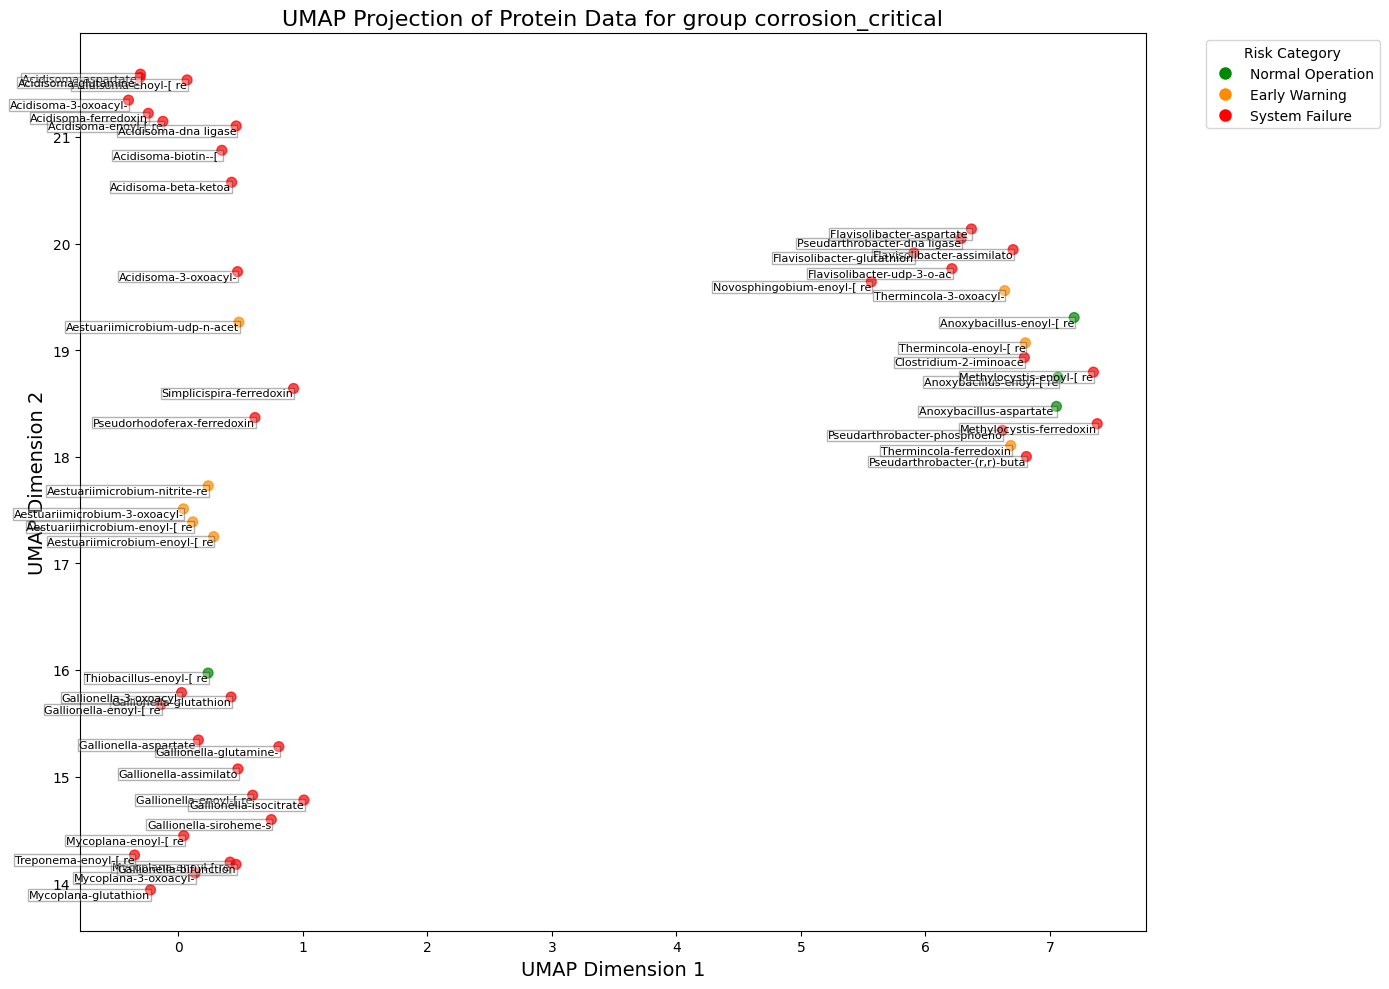

In [44]:
plot = create_simple_umap_visualization(corrosion_critical, "corrosion_critical", 50, n_neighbors=10, min_dist=0.1, point_size=50)
# Display the figure

umap_path = shared_dir / "umap_13.png"
plt.savefig(umap_path, dpi=300, bbox_inches='tight')
plt.show()

The group top_markers shows that the system failure markers (red) dominate the majority of the plot and appear in almost all bacterial genera, which is expected because those are the filtered pair genus-protein markers coming from the pipeline in which were classified, scored and separated according to the bacteria abundance, relationship to the risk label and biological relevance scoring, so it is no a surprise if only category 2 and 3 are present. In the system failure some protein-genus are associated such as propionibacterium and Propionivibrio proteins, most Pseudarthrobacter proteins and several Pseudomonas proteins. The category 2, early warning markers (orange) cluster prominently in the right side of the plot (Porphyrobacter proteins), appear in selected Pseudorhodeferax proteins and several instances in Prevotella markers.

The Porphyrobacter cluster (right side) is predominantly associated with early warning status
Propionibacterium/Propionivibrio clusters (upper left) primarily indicate system failure
Pseudarthrobacter markers in the middle regions consistently indicate system failure. There is biological coherence since those enzymatic functions align strongly with the operational indicators.

/home/beatriz/MIC/3_combined/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/beatriz/MIC/3_combined/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



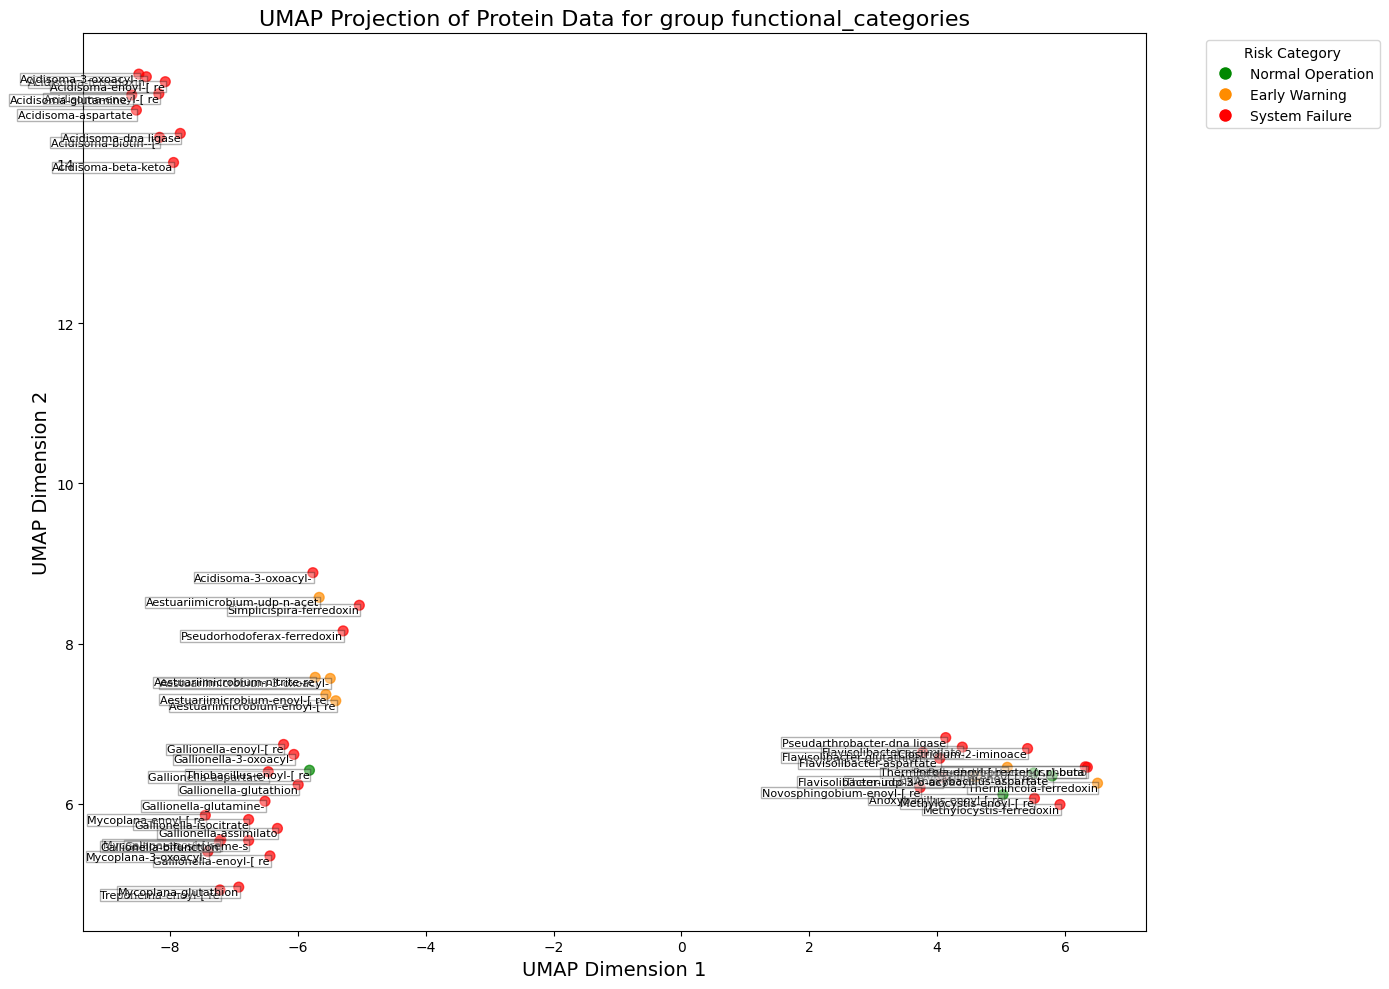

<Figure size 640x480 with 0 Axes>

In [45]:

plot = create_simple_umap_visualization(functional_categories , "functional_categories", 50, n_neighbors=10, min_dist=0.1, point_size=50)
plt.show()
plt.savefig("/home/beatriz/SharedFolder/Visualisations/umap_14.png", dpi=300, bbox_inches='tight')

The umap proyection on group mechanism_acid_production show several clusters, sytem failure markers dominated the plot, in the bottom left 
Propionibacterium acid-producing enzymes, Pseudomonas, Propionivibrio, psb-m-3 and prevotela metabolic enzymes.Category 2 early warning markers (orange) show functional patterns: Prevotella enzymes (thiamine, threonine, diaminopimelate metabolism), selected Pseudorhodeferax proteins and Porphyrobacter acyl-homos proteins. The acid production mechanisms appear to have predictive value for system states, with specific metagenomic signatures correlating with different operational conditions.
Genus-level patterns emerge: Porphyrobacter appears to be an early warning indicator genus, Propionibacterium/Propionivibrio markers consistently signal system failure
Prevotella shows mixed indicators between early warning and system failure. Acid production enzymes strongly correlate with system status, transferases and certain dehydrogenases appear to have early warning potential. The cytosol and cell division proteins show consistent system failure indications. This suggests these enzyme functions have genuine predictive value

## 3.8. Functional categories Mechanism/Pathway heatmaps

In [46]:
def plot_functional_group_heatmap(classified_results, name, top_n=100):
    """
    Create side-by-side heatmaps grouped by mechanisms and pathway classification
    
    Parameters:
        classified_results: DataFrame with classified pathways
        name: Name of the group for title
        top_n: Number of top pairs to use (default: 100)
    
    Returns:
        matplotlib figure
    """
    # Get top markers
    top_markers = classified_results.head(top_n)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # First subplot: Mechanisms
    if 'corrosion_mechanisms' in top_markers.columns:
        # Extract all mechanisms
        all_mechanisms = set()
        for mechs in top_markers['corrosion_mechanisms'].dropna():
            if isinstance(mechs, str):
                all_mechanisms.update([m.strip() for m in mechs.split(';')])
        
        # Create a matrix: rows=genera, columns=mechanisms
        genera = top_markers['Genus'].unique()
        mechanisms = sorted(list(all_mechanisms))
        matrix = np.zeros((len(genera), len(mechanisms)))
        
        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]
            for _, row in genus_markers.iterrows():
                if pd.notna(row['corrosion_mechanisms']) and isinstance(row['corrosion_mechanisms'], str):
                    marker_mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                    for mechanism in marker_mechanisms:
                        if mechanism in mechanisms:
                            j = mechanisms.index(mechanism)
                            matrix[i, j] += 1
        
        # Use a better colormap for mechanisms
        cmap1 = LinearSegmentedColormap.from_list('corrosion', ['#FFFFFF', '#FF9966', '#CC3300'])
        sns.heatmap(matrix, cmap=cmap1, linewidths=0.5, linecolor='gray',
                   xticklabels=mechanisms, yticklabels=genera, ax=ax1)
        ax1.set_title(f'Genus-Mechanism Relationship')
        ax1.set_xlabel('Corrosion Mechanism')
        ax1.set_ylabel('Genus')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Second subplot: Pathway classification
    if 'pathway_classification' in top_markers.columns:
        # Create a matrix: rows=genera, columns=classifications
        genera = top_markers['Genus'].unique()
        classifications = ['universal', 'mixed', 'niche-specific']
        matrix = np.zeros((len(genera), len(classifications)))
        
        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]
            for classification in classifications:
                j = classifications.index(classification)
                count = sum(genus_markers['pathway_classification'] == classification)
                matrix[i, j] = count
        
        # Plot
        cmap2 = LinearSegmentedColormap.from_list('pathways', ['#FFFFFF', '#66CCFF', '#003366'])
        sns.heatmap(matrix, cmap=cmap2, linewidths=0.5, linecolor='gray',
                   xticklabels=classifications, yticklabels=genera, ax=ax2)
        ax2.set_title(f"Genus-Pathway Classification Relationship")
        ax2.set_xlabel('Pathway Classification')
        ax2.set_ylabel('Genus')
    
    # Overall title
    plt.suptitle(f"Functional Relationships for {name} (Top {top_n} Proteins)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
    return fig

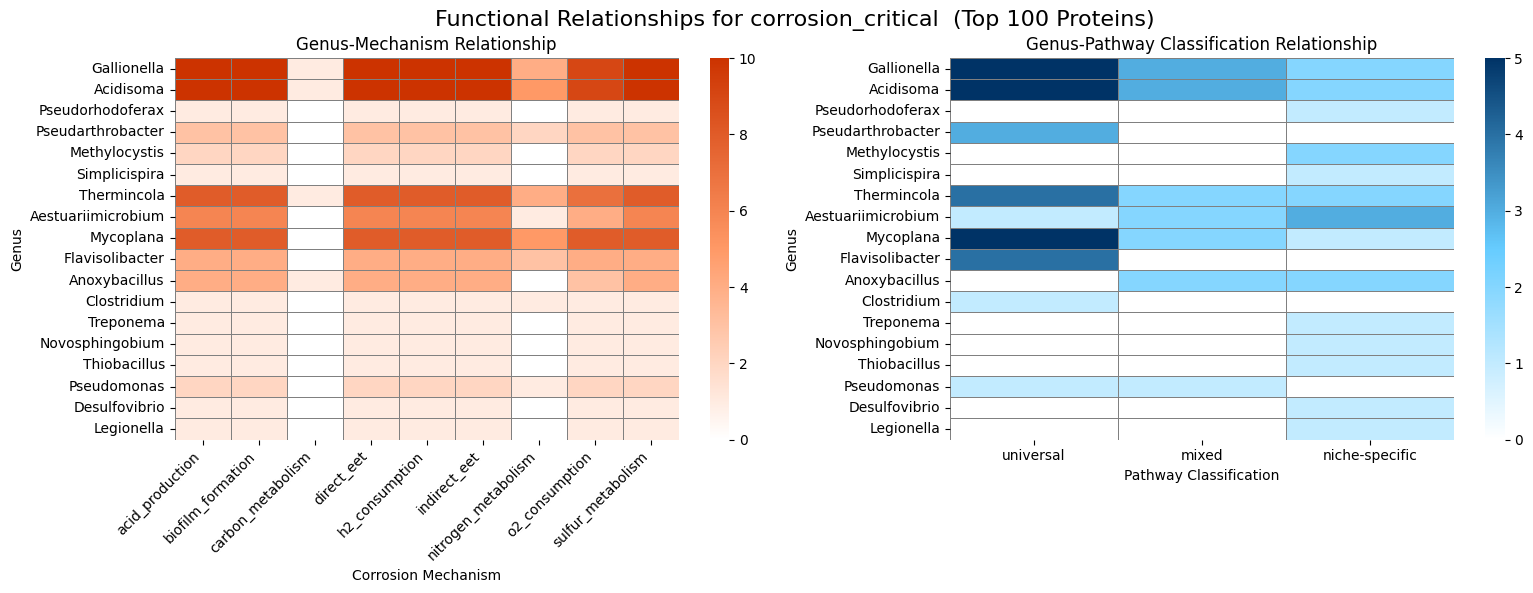

<Figure size 640x480 with 0 Axes>

In [47]:
plot_functional_group_heatmap(corrosion_critical , "corrosion_critical ", top_n=100)
plt.show()
plt.savefig("/home/beatriz/SharedFolder/Visualisations/functional_15.png", dpi=300, bbox_inches='tight')

## 3.9. Genus-Mechanism Heatmap
Shows relationships between top genera and corrosion mechanisms

In [48]:
def plot_genus_mechanism_heatmap(prioritized_markers, name, top_genera=10, top_markers_per_genus=5, figsize=None):
    """
    Create a heatmap showing top genera and their corrosion mechanisms
    Uses normalized scores to reveal relative patterns
    """
    plt.close('all')
    
    # Ensure corrosion_mechanisms column exists
    if 'corrosion_mechanisms' not in prioritized_markers.columns:
        raise ValueError("DataFrame must contain 'corrosion_mechanisms' column")
    
    # Get top genera based on combined_score
    genus_scores = prioritized_markers.groupby('Genus')['combined_score'].mean()
    top_genera_list = genus_scores.nlargest(top_genera).index.tolist()
    
    # Filter for top genera
    genus_df = prioritized_markers[prioritized_markers['Genus'].isin(top_genera_list)].copy()
    
    # Get top markers per genus based on combined_score
    top_markers = []
    for genus in top_genera_list:
        genus_markers = genus_df[genus_df['Genus'] == genus].nlargest(top_markers_per_genus, 'combined_score')
        top_markers.append(genus_markers)
    
    top_markers_df = pd.concat(top_markers)
    
    # Extract all unique mechanisms
    all_mechanisms = set()
    for mechs in top_markers_df['corrosion_mechanisms'].dropna():
        if isinstance(mechs, str):
            all_mechanisms.update([m.strip() for m in mechs.split(';')])
    
    all_mechanisms = sorted(list(all_mechanisms))
    
    # Create matrix for heatmap
    heatmap_data = np.zeros((len(top_genera_list), len(all_mechanisms)))
    count_data = np.zeros((len(top_genera_list), len(all_mechanisms)))
    
    # Fill matrix with normalized scores
    for i, genus in enumerate(top_genera_list):
        genus_markers = top_markers_df[top_markers_df['Genus'] == genus]
        for _, row in genus_markers.iterrows():
            if pd.notna(row['corrosion_mechanisms']):
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                score = row['combined_score']
                
                for mechanism in mechanisms:
                    if mechanism in all_mechanisms:
                        j = all_mechanisms.index(mechanism)
                        heatmap_data[i, j] += score
                        count_data[i, j] += 1
    
    # Calculate average scores
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_scores = heatmap_data / count_data
        avg_scores[np.isnan(avg_scores)] = 0
    
    # Normalize by row (genus) to show relative importance
    with np.errstate(divide='ignore', invalid='ignore'):
        norm_data = avg_scores / avg_scores.sum(axis=1, keepdims=True)
        norm_data[np.isnan(norm_data)] = 0
    
    # Create heatmap
    figsize = figsize or (12, 8)
    plt.figure(figsize=figsize)
    
    # Add mechanism frequency as text annotation
    annotation_text = np.empty_like(heatmap_data, dtype=object)
    for i in range(len(top_genera_list)):
        for j in range(len(all_mechanisms)):
            val = norm_data[i, j]
            count = int(count_data[i, j])
            if count > 0:
                annotation_text[i, j] = f'{val:.2f}\n({count})'
            else:
                annotation_text[i, j] = ''
    
    sns.heatmap(norm_data, 
                annot=annotation_text, 
                fmt='', 
                cmap='viridis',
                xticklabels=all_mechanisms, 
                yticklabels=top_genera_list,
                cbar_kws={'label': 'Relative Prevalence'})
    
    plt.title(f'Genus-Mechanism Relationship (Normalized) - Group {name}')
    plt.ylabel('Genus')
    plt.xlabel('Corrosion Mechanism')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return plt.gcf()

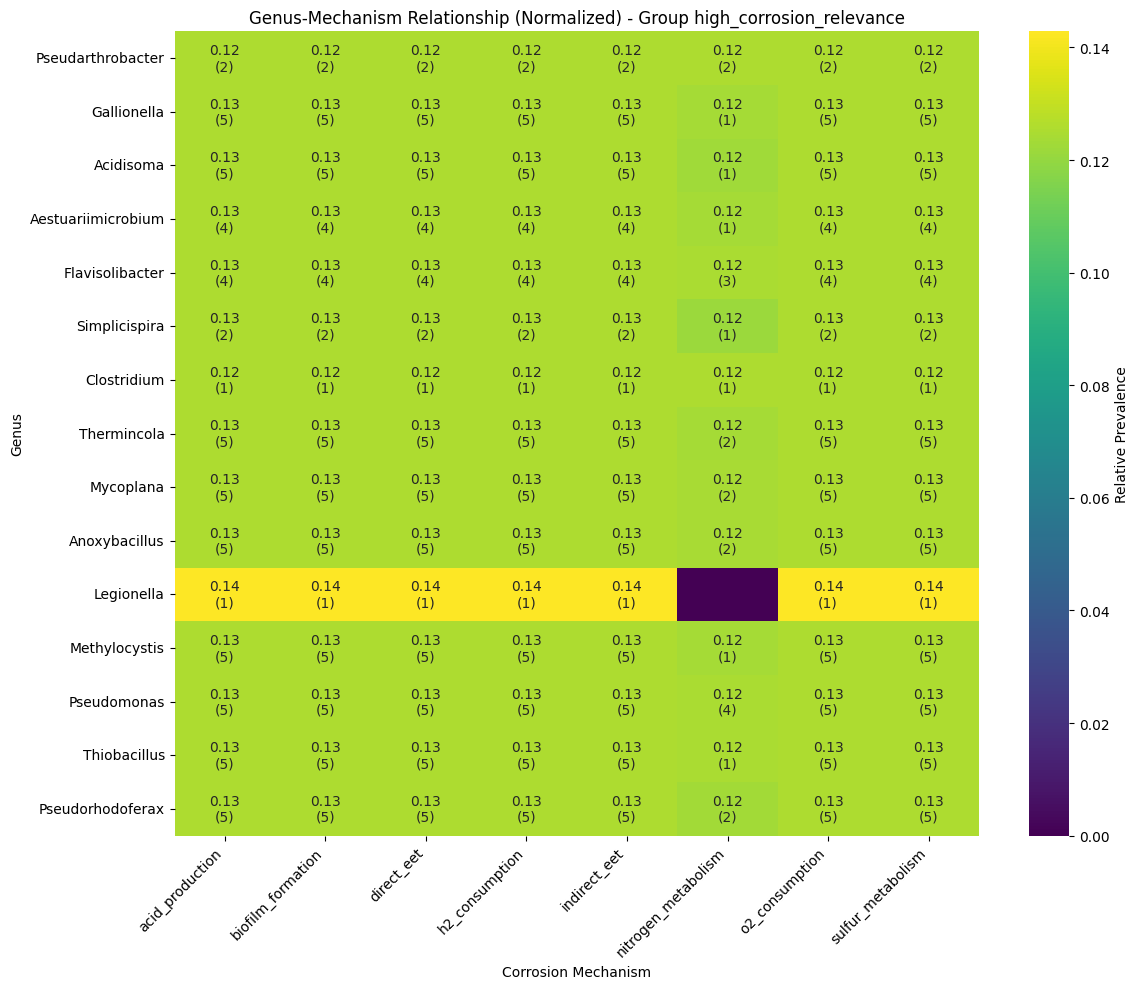

In [49]:
plot_genus_mechanism_heatmap(high_corrosion_relevance, "high_corrosion_relevance", top_genera=15, top_markers_per_genus=5, figsize=(12, 10))
opath = shared_dir/"16_genus_mech.png"
plt.savefig(opath, dpi=300, bbox_inches='tight')

# 4. Proteins 
## 4.1. Protein Abundance Trajectories across risk categories

Fold change thresholds are standard practice (Love et al., 2014; DESeq2) the idea is to calculate which and how much the protein have an increase when changing the risk category from one lower to a high category. 
Reference
Love, M. I., Huber, W., & Anders, S. (2014). Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome Biology, 15(12), 550. https://doi.org/10.1186/s13059-014-0550-8).

In [50]:
def plot_fold_change_increasing_only(marker_group, name, top_n=20, fold_change_type='3vs1'):
    """
    Creates a line chart showing only increasing protein abundance trajectories
    across risk categories with fold change hover details.
    """
    markers_df = marker_group.copy()
    
    required_cols = ['protein_name', 'Genus', 'mean_cat1', 'mean_cat2', 'mean_cat3']
    for col in required_cols:
        if col not in markers_df.columns:
            raise ValueError(f"Required column '{col}' not found in the data")
    
    min_threshold = 0.01

    if f'fold_change_{fold_change_type}' not in markers_df.columns:
        if fold_change_type == '3vs1':
            markers_df['fold_change_3vs1'] = (markers_df['mean_cat3'] + min_threshold) / (markers_df['mean_cat1'] + min_threshold)
            markers_df['log2fc_3vs1'] = np.log2(markers_df['fold_change_3vs1'])
        elif fold_change_type == '3vs2':
            markers_df['fold_change_3vs2'] = (markers_df['mean_cat3'] + min_threshold) / (markers_df['mean_cat2'] + min_threshold)
            markers_df['log2fc_3vs2'] = np.log2(markers_df['fold_change_3vs2'])
        elif fold_change_type == '2vs1':
            markers_df['fold_change_2vs1'] = (markers_df['mean_cat2'] + min_threshold) / (markers_df['mean_cat1'] + min_threshold)
            markers_df['log2fc_2vs1'] = np.log2(markers_df['fold_change_2vs1'])

    # Keep only increasing patterns
    markers_df = markers_df[
        (markers_df['mean_cat1'] < markers_df['mean_cat2']) &
        (markers_df['mean_cat2'] < markers_df['mean_cat3'])
    ]

    # Sort by fold change magnitude
    log2fc_col = f'log2fc_{fold_change_type}'
    markers_df['abs_log2fc'] = markers_df[log2fc_col].abs()
    top_markers = markers_df.sort_values('abs_log2fc', ascending=False).head(top_n)

    # Prepare trajectories
    trajectories = []
    for i, row in top_markers.iterrows():
        protein_name = row['protein_name']
        if isinstance(protein_name, str) and len(protein_name) > 30:
            protein_name = protein_name[:27] + "..."
        
        label = f"{row['Genus']} - {protein_name}"
        
        fold_change = row.get(f'fold_change_{fold_change_type}', 0)
        log2fc = row.get(log2fc_col, 0)

        trajectory = {
            'id': label,
            'Category 1': row['mean_cat1'],
            'Category 2': row['mean_cat2'],
            'Category 3': row['mean_cat3'],
            'fold_change': f"{fold_change:.2f}x",
            'log2fc': f"{log2fc:.2f}"
        }
        
        if 'combined_score' in row:
            trajectory['score'] = row['combined_score']
            
        trajectories.append(trajectory)

    traj_df = pd.DataFrame(trajectories)

    hover_data = ['fold_change', 'log2fc']
    if 'score' in traj_df.columns:
        hover_data.append('score')

    melted = pd.melt(
        traj_df,
        id_vars=['id'] + hover_data,
        value_vars=['Category 1', 'Category 2', 'Category 3'],
        var_name='category',
        value_name='abundance'
    )

    melted['category_num'] = melted['category'].map({
        'Category 1': 1,
        'Category 2': 2,
        'Category 3': 3
    })

    fig = px.line(
        melted,
        x='category_num',
        y='abundance',
        color='id',
        line_group='id',
        hover_data=hover_data,
        markers=True,
        title=f'Protein Abundance Trajectories across risk categories Top {top_n} {name} by {fold_change_type} Fold Change',
        labels={'category_num': 'Risk Category', 'abundance': 'Mean Abundance'},
        height=600,
        width=1000
    )

    fig.update_xaxes(
        tickvals=[1, 2, 3],
        ticktext=['Category 1', 'Category 2', 'Category 3']
    )

    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.5,
            xanchor="center",
            x=0.5
        ),
        margin=dict(
            b=150
        )
    )

    return fig


In [51]:

fig = plot_fold_change_increasing_only(high_synergy_markers, "high_synergy_markers", top_n=20, fold_change_type='3vs1')
inc_path = shared_dir /"17_increase"
plt.savefig(inc_path, dpi=300, bbox_inches='tight')
fig.show()
plt.close('all')

## 4.2. Protein Abundance Across Categories
Line plots showing how abundance changes across corrosion categories

In [52]:
def plot_abundance_across_categories(marker_group, name, top_n=25, sort_by='combined_score'):
    """
    Plot abundance patterns across corrosion categories for top markers.
    Uses global term dictionaries and pre-calculated fold change columns.
    
    Parameters:
        marker_group: DataFrame containing marker data
        name: Name of the group for the title
        top_n: Number of top markers to display
        sort_by: Column name to sort markers by (default: 'combined_score')
        
    Returns:
        Plotly figure object with the abundance plot
    """
    # Make a copy to avoid modifying the original
    markers_df = marker_group.copy()
    
    # Get mean columns
    mean_cols = [col for col in markers_df.columns if col.startswith('mean_cat')]
    if not mean_cols:
        raise ValueError("No mean abundance columns found (should start with 'mean_cat')")
    
    # Sort and get top markers
    if sort_by in markers_df.columns:
        top_markers = markers_df.sort_values(sort_by, ascending=False).head(top_n)
    else:
        # If sort column not found, try combined_score, otherwise sort by first mean column
        if 'combined_score' in markers_df.columns:
            top_markers = markers_df.sort_values('combined_score', ascending=False).head(top_n)
        else:
            top_markers = markers_df.sort_values(mean_cols[0], ascending=False).head(top_n)
    
    # Extract category numbers from column names
    categories = [col.replace('mean_cat', 'Category ') for col in mean_cols]
    category_nums = [int(col.replace('mean_cat', '')) for col in mean_cols]
    
    # Create a list to store traces for each marker
    traces = []
    
    # Add trace for each marker
    for i, (_, row) in enumerate(top_markers.iterrows()):
        # Create shorter, more readable labels
        protein_name = row['protein_name'] if 'protein_name' in row else row.get('Marker', 'Unknown')
        if isinstance(protein_name, str) and len(protein_name) > 20:
            protein_name = protein_name[:17] + "..."
        
        # Add genus for better identification
        label = f"{row.get('Genus', 'Unknown')} - {protein_name}"
        
        # Get abundance values
        values = [row[col] for col in mean_cols]
        
        # Add trace with hover information
        hover_text = []
        for i, cat in enumerate(categories):
            hover_info = f"Category: {cat}<br>Abundance: {values[i]:.4f}"
            if 'Genus' in row:
                hover_info += f"<br>Genus: {row['Genus']}"
            
            # Add fold changes to hover info if available
            if 'fold_change_3vs1' in row and i == 2:  # For category 3
                hover_info += f"<br>FC vs Cat1: {row['fold_change_3vs1']:.2f}"
            if 'fold_change_2vs1' in row and i == 1:  # For category 2
                hover_info += f"<br>FC vs Cat1: {row['fold_change_2vs1']:.2f}"
            if 'fold_change_3vs2' in row and i == 2:  # For category 3
                hover_info += f"<br>FC vs Cat2: {row['fold_change_3vs2']:.2f}"
                
            # Add additional hover information if available

            if 'combined_score' in row:
                hover_info += f"<br>Score: {row['combined_score']:.2f}"    
            if 'pattern' in row:
                hover_info += f"<br>Pattern: {row['pattern']}"

            hover_text.append(hover_info)
        
        # Create trace for this marker
        trace = go.Scatter(
            x=category_nums,
            y=values,
            mode='lines+markers',
            name=label,
            line=dict(width=2),
            marker=dict(size=8),
            hovertext=hover_text,
            hoverinfo='text'
        )
        
        traces.append(trace)
    
    # Create figure
    fig = go.Figure(data=traces) 
    fig.update_layout(title=f'Abundance Patterns of Group {name} Across Corrosion Categories (Top {top_n} Markers)', xaxis=dict(tickfont=dict(size=18, family="Arial"), tickmode='array', tickvals=category_nums, ticktext=categories, domain=[0, 1]), yaxis=dict(title=dict(text='Mean Abundance', font=dict(size=14))), legend=dict(orientation="h", yanchor="bottom", y=-0.8, xanchor="center", x=0.5), margin=dict(t=100, b=150, l=100, r=100), height=700, width=1000, hovermode='closest', annotations=[dict(x=0.5, y=1.05, xref="paper", yref="paper", text="Corrosion Category", showarrow=False, font=dict(size=14))])

    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    return fig

In [53]:
abun= plot_abundance_across_categories(high_synergy_markers, "high_synergy_markers",  top_n=25, sort_by='combined_score')
output_path= shared_dir /"18_increase.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
fig.show()

<Figure size 640x480 with 0 Axes>

In [54]:
abun2=plot_abundance_across_categories(very_high_specificity, "very_high_specificity", top_n=25, sort_by='combined_score')
abun2.show()
output_path= shared_dir /"19_increase_across.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## 4.3. Top Protein Heatmap

In [55]:
def plot_top_protein_heatmap(df, name, top_proteins=20):
    # Sort by preferred significance metric
    top_proteins = df.sort_values(by='combined_score', ascending=False).head(top_proteins)

    # Select mean value columns for heatmap
    heatmap_data = top_proteins[['mean_cat1', 'mean_cat2', 'mean_cat3']]

    # Truncate long protein names for better visualization
    #truncated_names = top_proteins['protein_name'].apply(lambda x: x if len(x) <= 80 else x[:25] + '...')

    # Create heatmap
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".2f",
        cmap='viridis',
        yticklabels=top_proteins['protein_name'], #truncated_names,  # Use truncated names
        xticklabels=['Category 1', 'Category 2', 'Category 3']
    )

    plt.title(f" {name} Top Protein Expression Heatmap across Risk Category")
    plt.ylabel("Proteins")
    plt.xlabel("Risk Category")

    # Use tight_layout to minimize empty space
    plt.tight_layout()

    return plt.gcf()


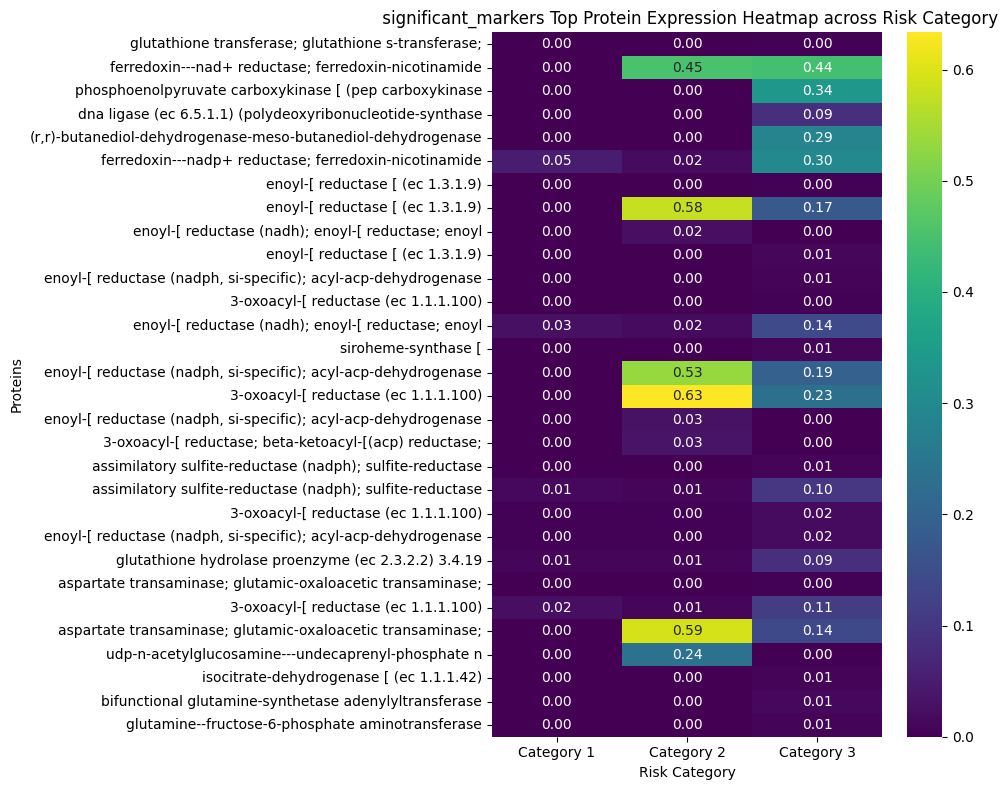

<Figure size 640x480 with 0 Axes>

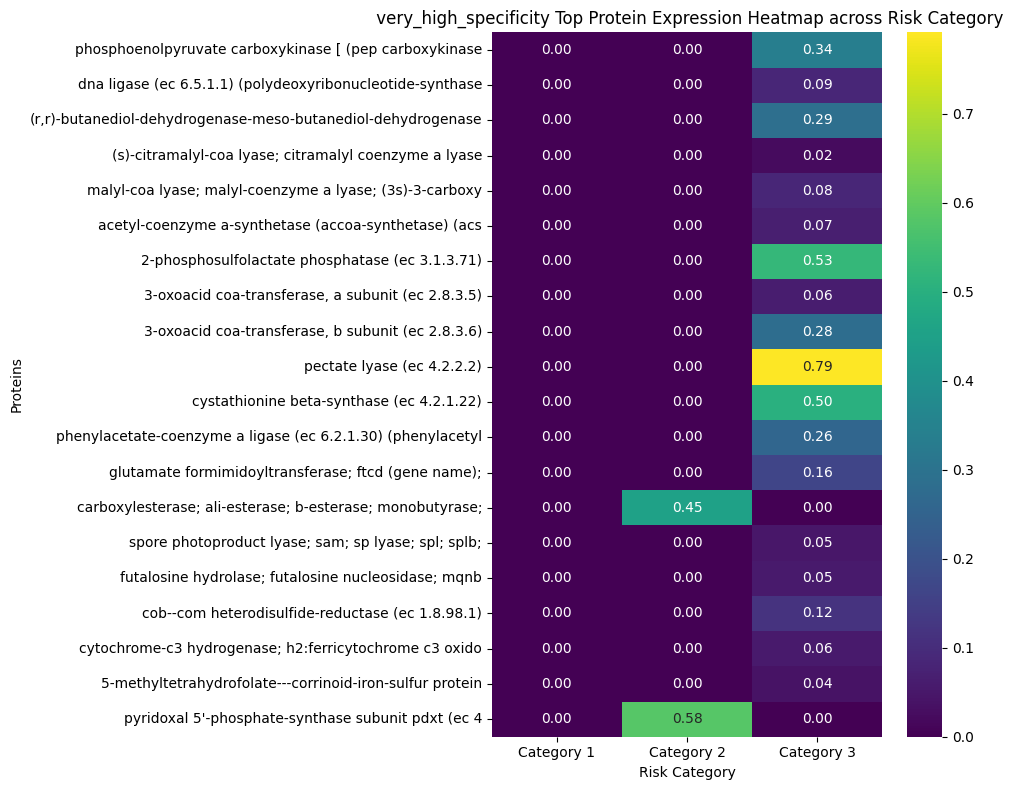

<Figure size 640x480 with 0 Axes>

In [56]:
plot_top_protein_heatmap(significant_markers, "significant_markers", 30)
plt.show()
output_path= shared_dir /"20_protein.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plot_top_protein_heatmap(very_high_specificity, "very_high_specificity", 20)
plt.show()

output_path= shared_dir /"21_protein.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

## 4.4. Top Markers by Score -
Bar chart showing the highest scoring markers

In [57]:
def plot_top_markers_by_score(prioritized_markers, name, top_n=20, figsize=(8, 6)):
    """
    Create a horizontal bar chart of top markers by score
    """
    # Get top markers
    top_markers = prioritized_markers.head(top_n)

    # Create labels
    labels = [f"{row['Genus']} - {row['protein_name'][:100]}"
              for _, row in top_markers.iterrows()]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot horizontal bars
    plt.barh(range(len(labels)), top_markers['combined_score'], color='steelblue')

    # Add labels and title
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Combined Score')
    plt.title(f'{top_n} {name} Top Markers by Score')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return plt.gcf()

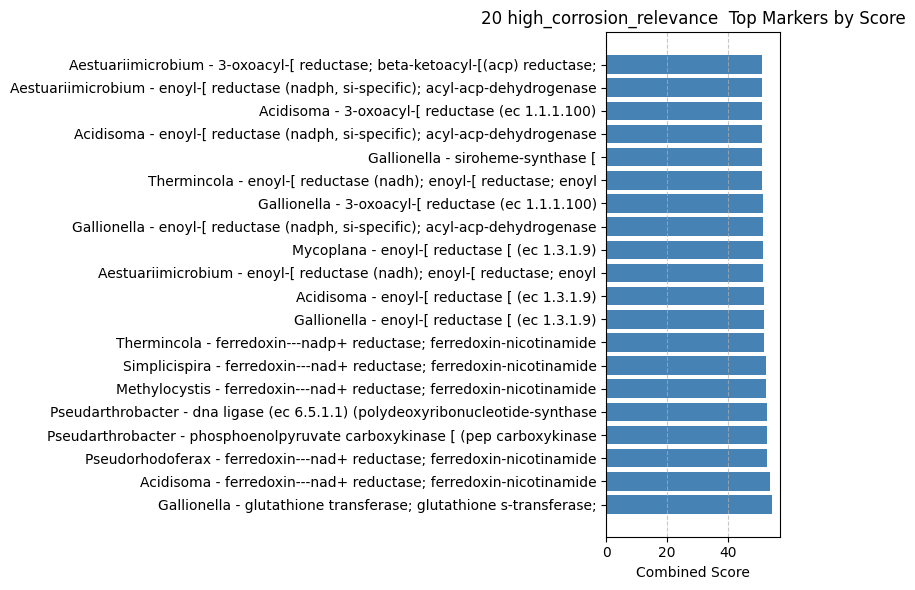

In [58]:
plot_top_markers_by_score(high_corrosion_relevance , "high_corrosion_relevance ", top_n=20, figsize=(8, 6))

prot_path = shared_dir/"22_prot-genus.png"
plt.savefig(prot_path, dpi=300, bbox_inches='tight')

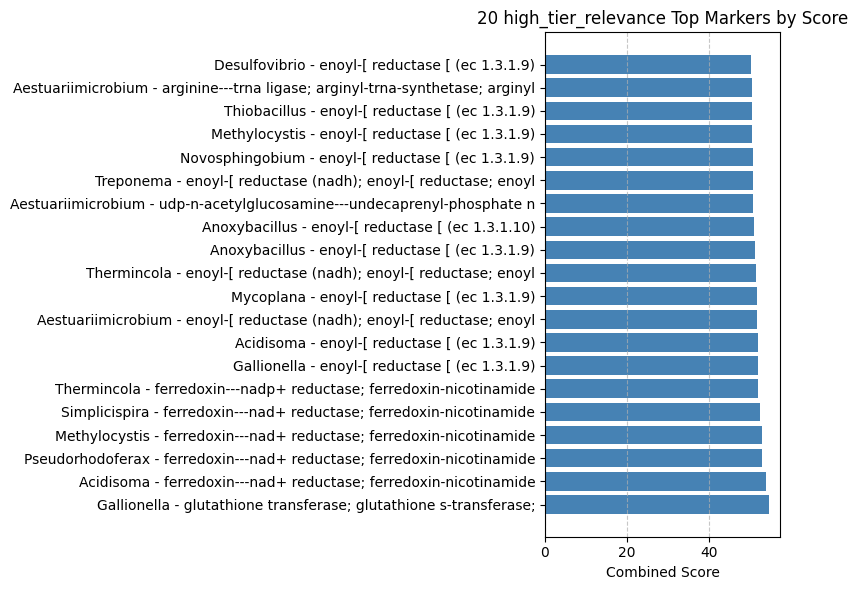

<Figure size 640x480 with 0 Axes>

In [59]:
plot_top_markers_by_score(high_tier_relevance , "high_tier_relevance", top_n=20, figsize=(8, 6))
plt.show()
prot_path = shared_dir/"23_prot-genus.png"
plt.savefig(prot_path, dpi=300, bbox_inches='tight')

In [60]:
def plot_top_proteins_by_shared_genera(prioritized_markers, name, top_n=20, min_score=0, figsize=(12, 8)):
    """
    Create a horizontal bar plot showing proteins and all genera that express them.
    Sorted by combined score with better display of genera information.
    """
    # Filter by minimum score if needed
    if min_score > 0:
        prioritized_markers = prioritized_markers[prioritized_markers['combined_score'] >= min_score]
    
    # Create protein-genus mapping with ALL occurrences
    protein_genus_data = []
    
    for _, row in prioritized_markers.iterrows():
        protein_name = row['protein_name']
        genus = row['Genus']
        score = row['combined_score']
        
        # Standardize protein name
        if isinstance(protein_name, str):
            # Clean up protein names
            protein_name = protein_name.replace('[', '').replace(']', '').strip()
        
        protein_genus_data.append({
            'protein_name': protein_name,
            'genus': genus,
            'combined_score': score
        })
    
    df_mapping = pd.DataFrame(protein_genus_data)
    
    # Group by protein and aggregate ALL genera (don't limit to top_markers only)
    protein_analysis = df_mapping.groupby('protein_name').agg({
        'genus': lambda x: list(x.unique()),
        'combined_score': 'max'
    }).reset_index()
    
    # Add count of unique genera per protein
    protein_analysis['genus_count'] = protein_analysis['genus'].apply(len)
    
    # Sort by combined score and take top N
    protein_analysis = protein_analysis.sort_values('combined_score', ascending=False).head(top_n)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare data for plotting
    y_positions = range(len(protein_analysis))
    scores = protein_analysis['combined_score']
    
    # Create horizontal bars
    bars = ax.barh(y_positions, scores, color='steelblue', alpha=0.7)
    
    # Create detailed labels
    labels = []
    for _, row in protein_analysis.iterrows():
        protein_name = row['protein_name']
        # Truncate very long protein names
        if len(protein_name) > 40:
            protein_name = protein_name[:37] + "..."
        
        # Format genera list
        genera = sorted(row['genus'])
        genus_count = row['genus_count']
        
        # Show all genera if 5 or less, otherwise show first 3 and count
        if genus_count <= 5:
            genera_display = ', '.join(genera)
        else:
            genera_display = f"{', '.join(genera[:3])}, ... (+{genus_count-3} more)"
        
        # Combine into label
        labels.append(f"{protein_name}\n({genus_count} genera: {genera_display})")
    
    # Set labels and formatting
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel('Combined Score', fontsize=11)
    ax.set_title(f'Top {top_n} Proteins by Score with All Expressing Genera - {name}', fontsize=13)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}', 
                ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    return fig


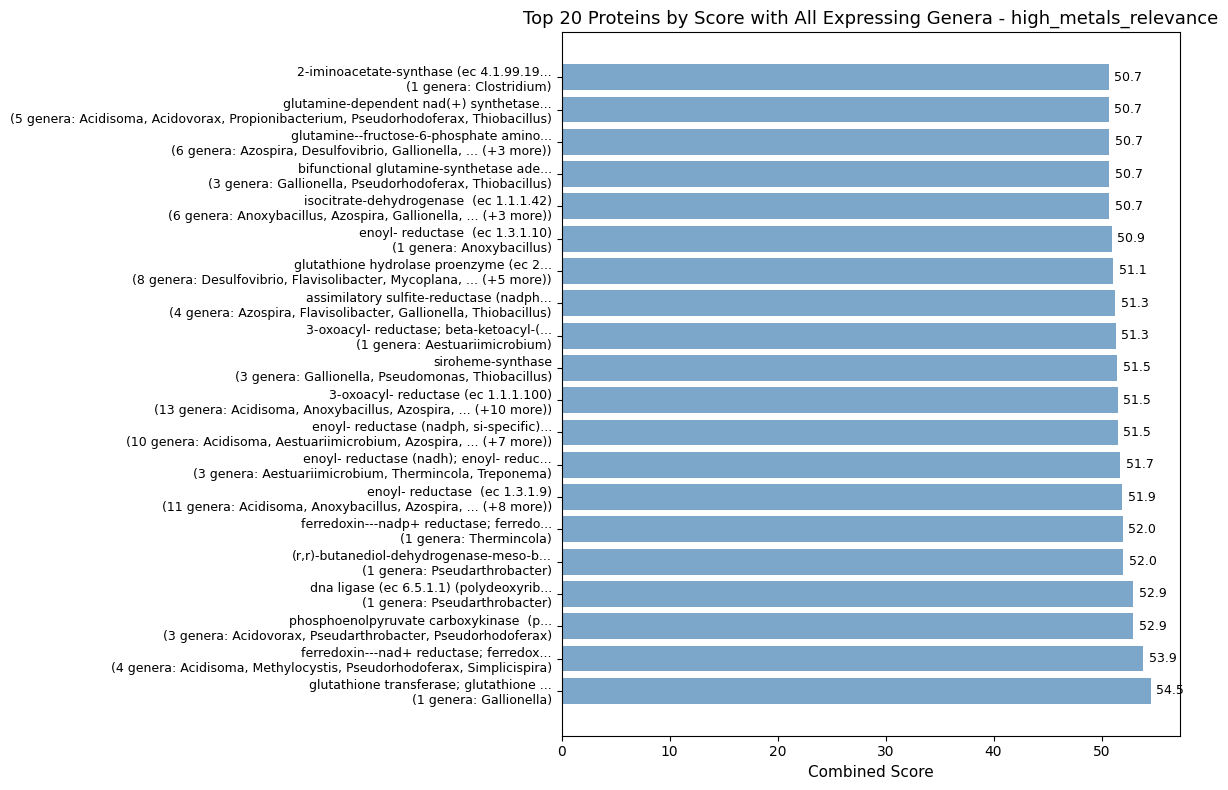

<Figure size 640x480 with 0 Axes>

In [61]:
fig1 = plot_top_proteins_by_shared_genera(high_metals_relevance,  "high_metals_relevance", top_n=20)
plt.figure(fig1.number)
plt.show()
prot_path = shared_dir/"24_prot-genus.png"
plt.savefig(prot_path, dpi=300, bbox_inches='tight')

## 4.5 Network Analysis Protein-Genus Pairs

In [62]:
def create_static_network(df, name, top_n=20, threshold=0.5, category_col='mechanisms',  protein_label_legend=True):
    """
    Creates a static network visualization of genus-protein-category relationships.

    Args:    df: DataFrame containing marker data
        name: Name for the network plot
        top_n: Number of top markers to include
        threshold: Edge weight threshold (0.0-1.0)
        category_col: Column name for functional categories (default 'corrosion_mechanisms')
        protein_label_legend: If True, shows proteins in legend instead of labeling nodes.

    Returns:        G: NetworkX graph object
    """

    node_colors = { 'genus': '#2196F3',     'protein': '#4CAF50',    'category': '#FF5722' }

    required_cols = ['Genus', 'protein_name', 'combined_score', category_col]
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None

    G = nx.Graph()

    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)
    
    protein_labels = {}

    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])

        if pd.isna(genus) or pd.isna(protein):
            continue

        protein_short = protein[:27] + "..." if len(protein) > 30 else protein

        if not G.has_node(genus):
            G.add_node(genus, type='genus')

        if not G.has_node(protein_short):
            G.add_node(protein_short, type='protein')
            protein_labels[protein_short] = protein

        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        if score >= threshold:
            G.add_edge(genus, protein_short, weight=score)

        category_data = row.get(category_col, '')
        if isinstance(category_data, str) and category_data:
            for cat in category_data.split(';'):
                cat = cat.strip()
                if cat:
                    if not G.has_node(cat):
                        G.add_node(cat, type='category')
                    G.add_edge(protein_short, cat, weight=1.0)

    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')

    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G, k=0.3, seed=42)

    nx.draw_networkx_edges(G, pos, alpha=0.4)

    for node_type, color in node_colors.items():
        nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                               node_size=500 if node_type == 'genus' else 300)

    # Labels
    labels_to_draw = {}
    if not protein_label_legend:
        labels_to_draw.update({n: protein_labels.get(n, n) for n in G.nodes() if G.nodes[n].get('type') == 'protein'})

    labels_to_draw.update({n: n for n in G.nodes() if G.nodes[n].get('type') == 'genus'})
    labels_to_draw.update({n: n for n in G.nodes() if G.nodes[n].get('type') == 'category'})

    nx.draw_networkx_labels(G, pos, labels=labels_to_draw, font_size=8)

    # Legend
    plt.plot([0], [0], 'o', color=node_colors['genus'], label='Genus')
    plt.plot([0], [0], 'o', color=node_colors['protein'], label='Protein')
    plt.plot([0], [0], 'o', color=node_colors['category'], label=category_col.replace('_', ' ').title())
    plt.legend()

    # If proteins are not labeled directly, print them
    if protein_label_legend:
        print("\nProtein nodes:")
        for short, full in protein_labels.items():
            print(f"{short}: {full}")

    plt.title(f"{name} Network of Top {top_n} Corrosion Markers")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G



Protein nodes:
glutathione transferase; gl...: glutathione transferase; glutathione s-transferase;
ferredoxin---nad+ reductase...: ferredoxin---nad+ reductase; ferredoxin-nicotinamide
phosphoenolpyruvate carboxy...: phosphoenolpyruvate carboxykinase [ (pep carboxykinase
dna ligase (ec 6.5.1.1) (po...: dna ligase (ec 6.5.1.1) (polydeoxyribonucleotide-synthase
ferredoxin---nadp+ reductas...: ferredoxin---nadp+ reductase; ferredoxin-nicotinamide
enoyl-[ reductase [ (ec 1.3...: enoyl-[ reductase [ (ec 1.3.1.9)
enoyl-[ reductase (nadh); e...: enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
enoyl-[ reductase (nadph, s...: enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
3-oxoacyl-[ reductase (ec 1...: 3-oxoacyl-[ reductase (ec 1.1.1.100)
siroheme-synthase [: siroheme-synthase [
3-oxoacyl-[ reductase; beta...: 3-oxoacyl-[ reductase; beta-ketoacyl-[(acp) reductase;
assimilatory sulfite-reduct...: assimilatory sulfite-reductase (nadph); sulfite-reductase
glutathione hydrolase 

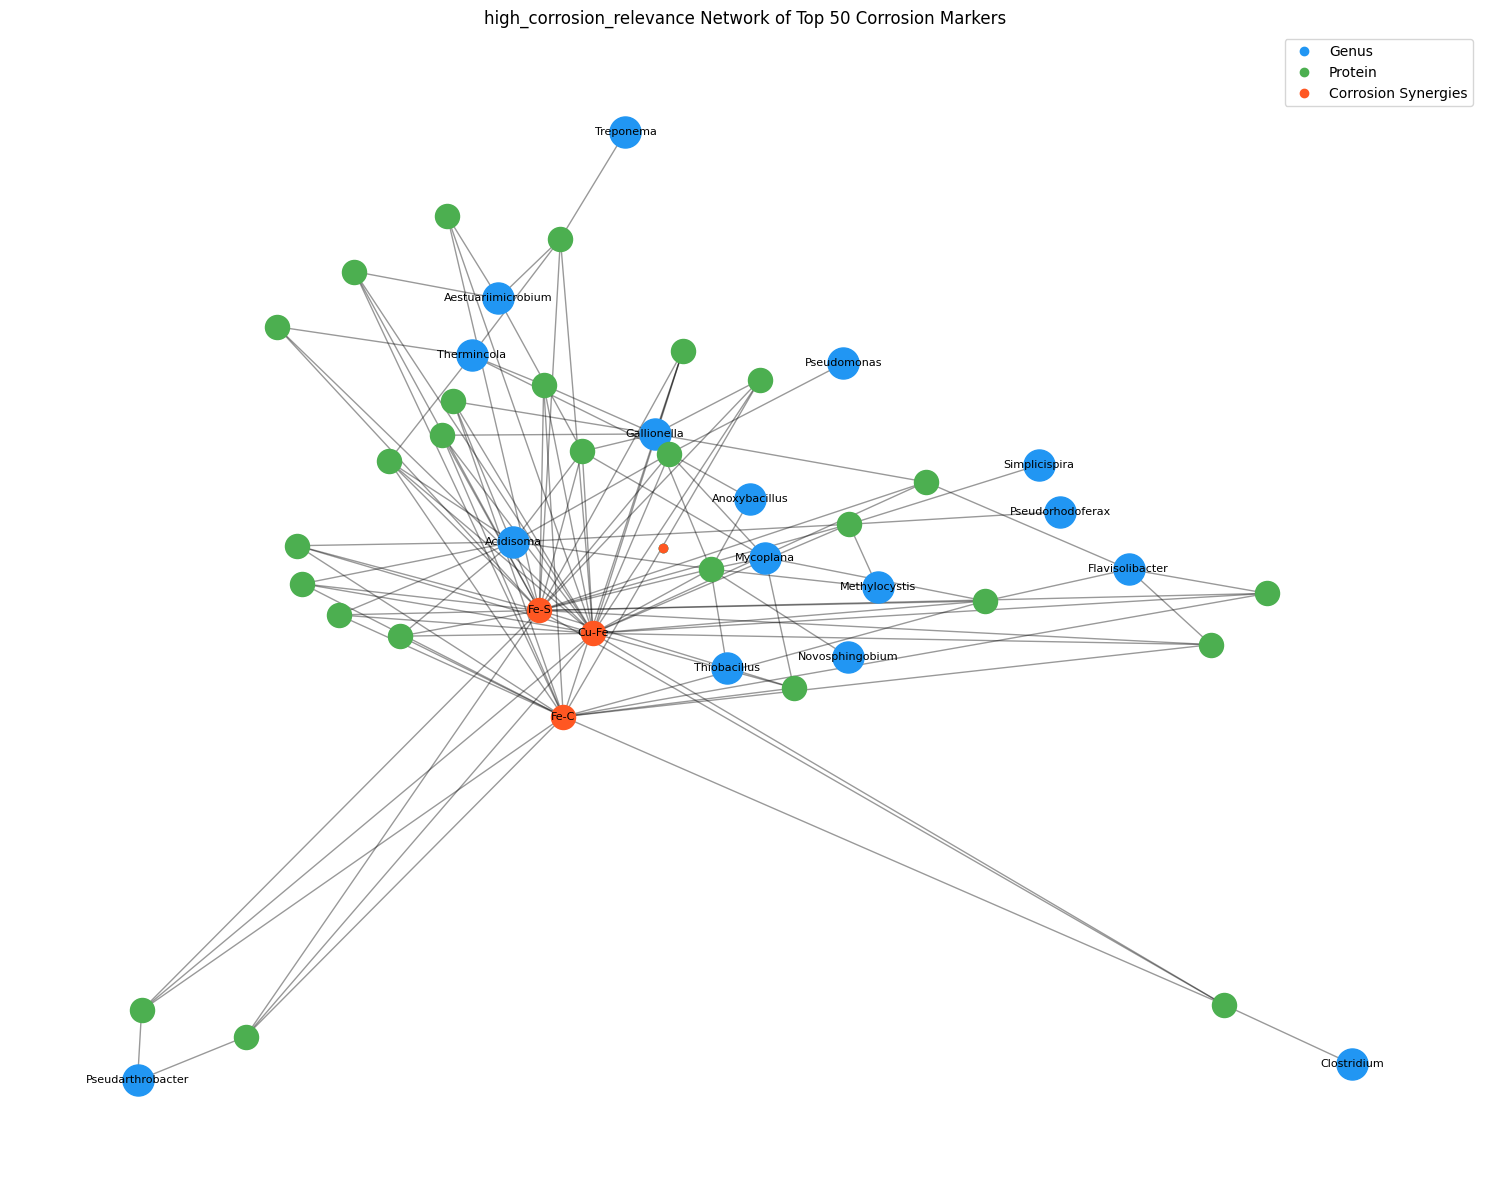

<Figure size 640x480 with 0 Axes>

In [63]:
# Expand column width display 
pd.set_option('display.max_colwidth', None)

create_static_network(high_corrosion_relevance, "high_corrosion_relevance", top_n=50, threshold=0.5, category_col='corrosion_synergies',  protein_label_legend=True)
prot_path = shared_dir/"25_network.png"
plt.savefig(prot_path, dpi=300, bbox_inches='tight')


Protein nodes:
glutathione transferase; gl...: glutathione transferase; glutathione s-transferase;
ferredoxin---nad+ reductase...: ferredoxin---nad+ reductase; ferredoxin-nicotinamide
phosphoenolpyruvate carboxy...: phosphoenolpyruvate carboxykinase [ (pep carboxykinase
dna ligase (ec 6.5.1.1) (po...: dna ligase (ec 6.5.1.1) (polydeoxyribonucleotide-synthase
(r,r)-butanediol-dehydrogen...: (r,r)-butanediol-dehydrogenase-meso-butanediol-dehydrogenase
ferredoxin---nadp+ reductas...: ferredoxin---nadp+ reductase; ferredoxin-nicotinamide
enoyl-[ reductase [ (ec 1.3...: enoyl-[ reductase [ (ec 1.3.1.9)
enoyl-[ reductase (nadh); e...: enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
enoyl-[ reductase (nadph, s...: enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
3-oxoacyl-[ reductase (ec 1...: 3-oxoacyl-[ reductase (ec 1.1.1.100)
siroheme-synthase [: siroheme-synthase [
3-oxoacyl-[ reductase; beta...: 3-oxoacyl-[ reductase; beta-ketoacyl-[(acp) reductase;
assimilatory sulfit

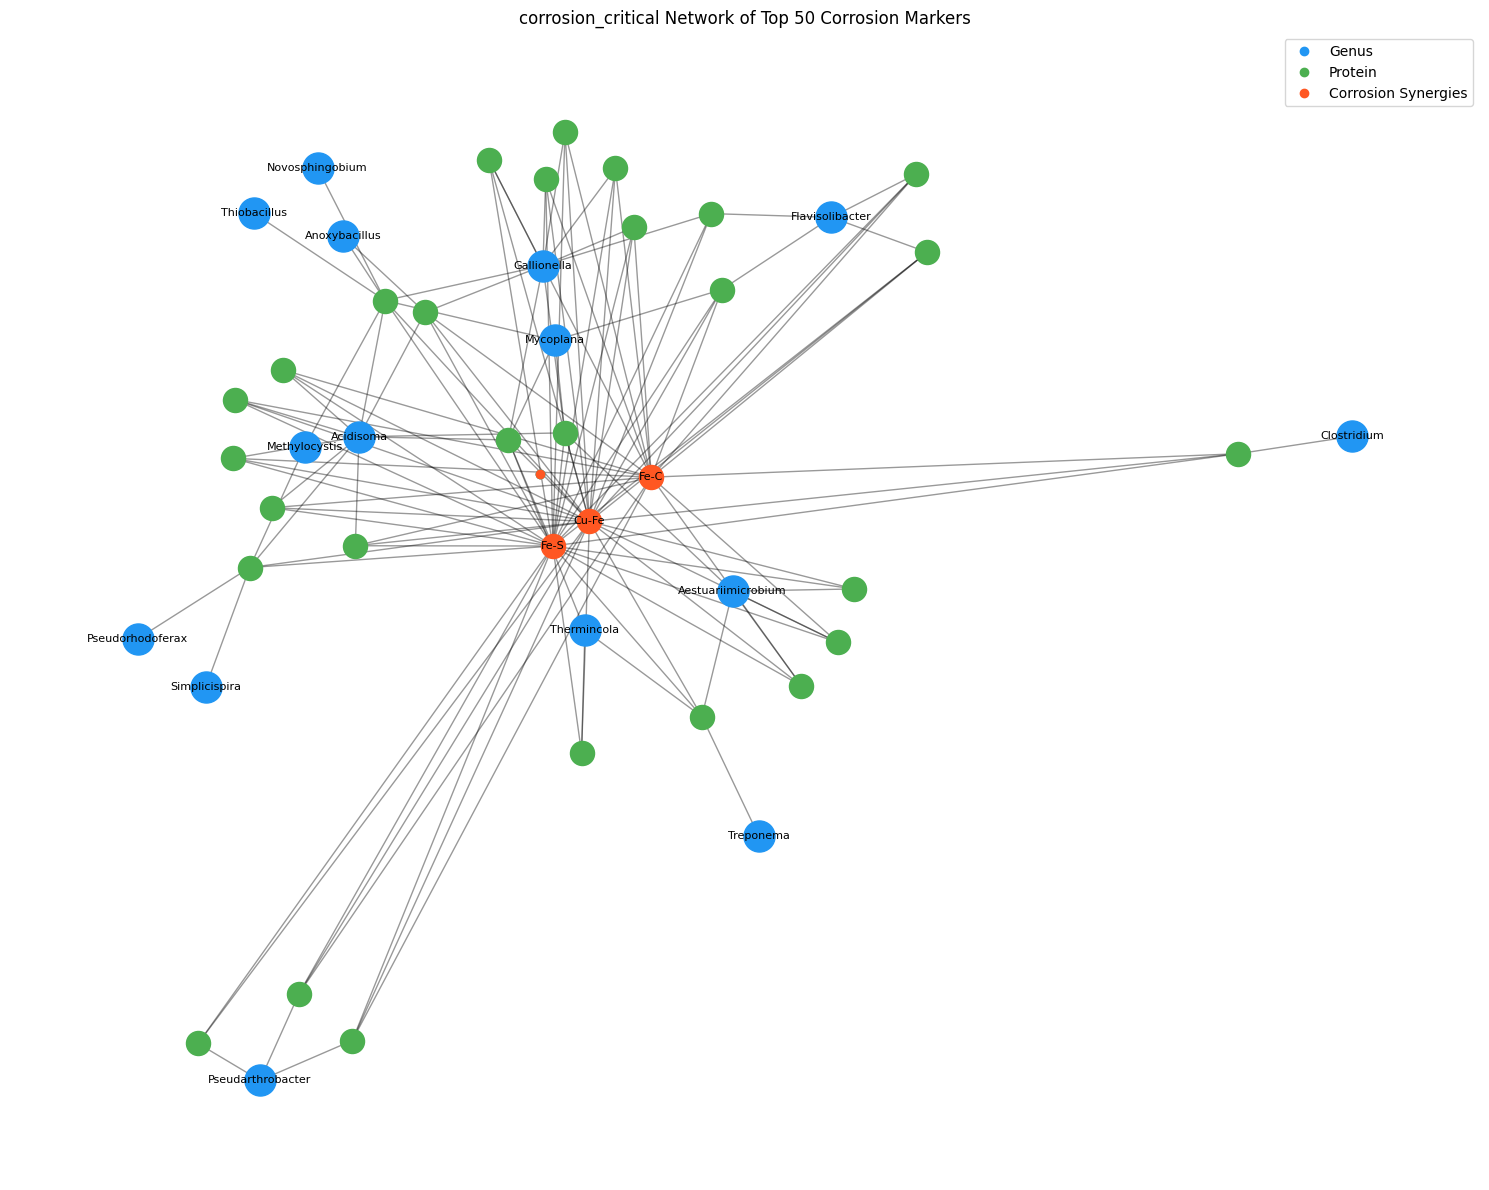

In [64]:
# Expand column width display 
pd.set_option('display.max_colwidth', None)

create_static_network(corrosion_critical, "corrosion_critical", top_n=50, threshold=0.5, category_col='corrosion_synergies',  protein_label_legend=True)

In [65]:
def create_static_network(df, name, top_n=20, threshold=0.5):
    """
    Creates a static network visualization with specific fixes requested.
    """
    # Define node type colors - simple differentiation
    node_colors = {
        'genus': '#2196F3',   # Blue
        'protein': '#4CAF50', # Green 
        'type': '#FF5722'     # Orange (changed from category)
    }
    
    # Define risk category colors as requested
    category_colors = {
        1: '#008800',  # Green
        2: '#FF8C00',  # Orange
        3: '#FF0000'   # Red
    }
    
    # Category labels as provided
    category_labels = {
        1: 'Normal Operation', 
        2: 'Early Warning', 
        3: 'System Failure'
    }
    
    # Check required columns exist
    required_cols = ['Genus', 'protein_name', 'combined_score', 'corrosion_mechanisms', 'Category']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None
    
    # Create new graph
    G = nx.Graph()
    
    # Get top markers by combined_score
    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)
    
    # Track protein labels for display
    protein_labels = {}
    
    # Build network structure from data
    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])
        
        # Skip if data is missing
        if pd.isna(genus) or pd.isna(protein):
            continue
        
        # Shorten long protein names with ellipsis
        protein_short = protein[:27] + "..." if len(protein) > 30 else protein
        
        # Add genus node if not already present
        if not G.has_node(genus):
            G.add_node(genus, type='genus')
        
        # Add protein node if not already present
        if not G.has_node(protein_short):
            G.add_node(protein_short, type='protein')
            protein_labels[protein_short] = protein
        
        # Add edge between genus and protein with weight
        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        if score >= threshold:
            G.add_edge(genus, protein_short, weight=score)
        
        # Process corrosion mechanisms from the column
        mechanisms_data = row.get('corrosion_mechanisms', '')
        if isinstance(mechanisms_data, str) and mechanisms_data:
            for mechanism in mechanisms_data.split(';'):
                mechanism = mechanism.strip()
                if mechanism:
                    # Add mechanism node if not present
                    if not G.has_node(mechanism):
                        G.add_node(mechanism, type='type')
                    # Connect protein to mechanism
                    G.add_edge(protein_short, mechanism, weight=1.0)
    
    # Detect communities in the network
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')
    
    # Create plot with reasonable size for screen
    plt.figure(figsize=(12, 10))
    
    # Use spring layout (most effective for this type)
    pos = nx.spring_layout(G, k=0.3, seed=42)
    
    # Draw edges with basic transparency
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    
    # Draw nodes with different colors for each type
    for node_type, color in node_colors.items():
        # Get all nodes of this type
        nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
        # Draw nodes with appropriate sizes
        node_size = 500 if node_type == 'genus' else 300
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=node_size)
    
    # Prepare labels for display
    labels_to_draw = {}
    # Add genus labels
    labels_to_draw.update({n: n for n in G.nodes() if G.nodes[n].get('type') == 'genus'})
    # Add mechanism labels (now called 'type')
    labels_to_draw.update({n: n for n in G.nodes() if G.nodes[n].get('type') == 'type'})
    # Add shortened protein labels
    labels_to_draw.update({n: n for n in G.nodes() if G.nodes[n].get('type') == 'protein'})
    
    # Draw all labels
    nx.draw_networkx_labels(G, pos, labels=labels_to_draw, font_size=8)
    
    # Create legend for node types
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors['genus'], 
                   markersize=15, label='Genus'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors['protein'], 
                   markersize=12, label='Protein'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=node_colors['type'], 
                   markersize=12, label='Mechanism')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Set title with dataframe name as requested
    plt.title(f"{name} Network Analysis\nDataframe: {df.name if hasattr(df, 'name') else 'df'}")
    
    # Remove axes
    plt.axis('off')
    
    # Adjust layout to fit screen
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    # Print full protein names for reference
    print("\nProtein node reference:")
    for short, full in protein_labels.items():
        print(f"{short}: {full}")
    
    return G

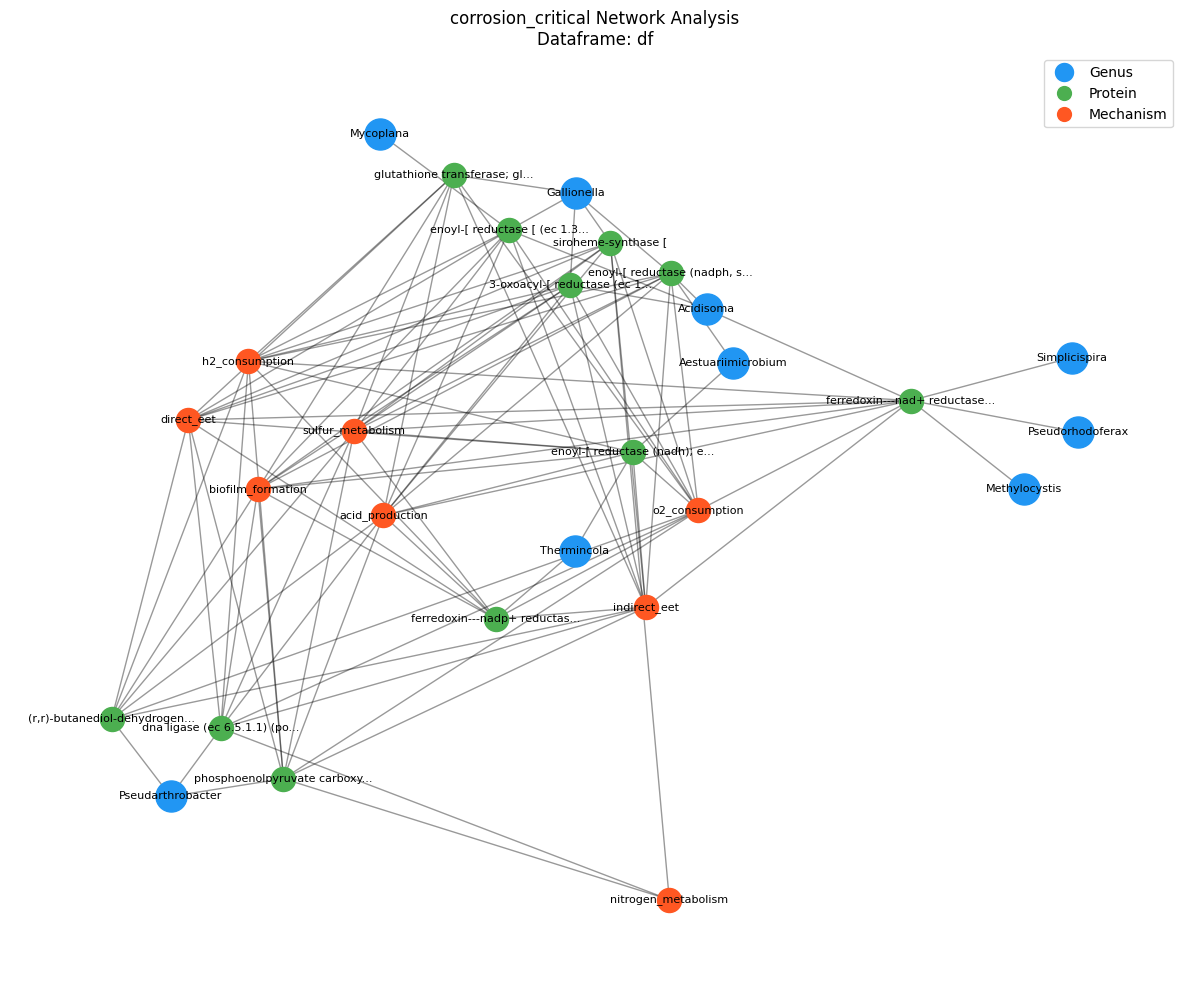


Protein node reference:
glutathione transferase; gl...: glutathione transferase; glutathione s-transferase;
ferredoxin---nad+ reductase...: ferredoxin---nad+ reductase; ferredoxin-nicotinamide
phosphoenolpyruvate carboxy...: phosphoenolpyruvate carboxykinase [ (pep carboxykinase
dna ligase (ec 6.5.1.1) (po...: dna ligase (ec 6.5.1.1) (polydeoxyribonucleotide-synthase
(r,r)-butanediol-dehydrogen...: (r,r)-butanediol-dehydrogenase-meso-butanediol-dehydrogenase
ferredoxin---nadp+ reductas...: ferredoxin---nadp+ reductase; ferredoxin-nicotinamide
enoyl-[ reductase [ (ec 1.3...: enoyl-[ reductase [ (ec 1.3.1.9)
enoyl-[ reductase (nadh); e...: enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
enoyl-[ reductase (nadph, s...: enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
3-oxoacyl-[ reductase (ec 1...: 3-oxoacyl-[ reductase (ec 1.1.1.100)
siroheme-synthase [: siroheme-synthase [


<Figure size 640x480 with 0 Axes>

In [66]:
# Using different color schemes corrosion_critical, "corrosion_critical
G1 = create_static_network(corrosion_critical, "corrosion_critical", top_n=20, threshold=0.5)
prot_path = shared_dir/"26_network.png"
plt.savefig(prot_path, dpi=300, bbox_inches='tight')


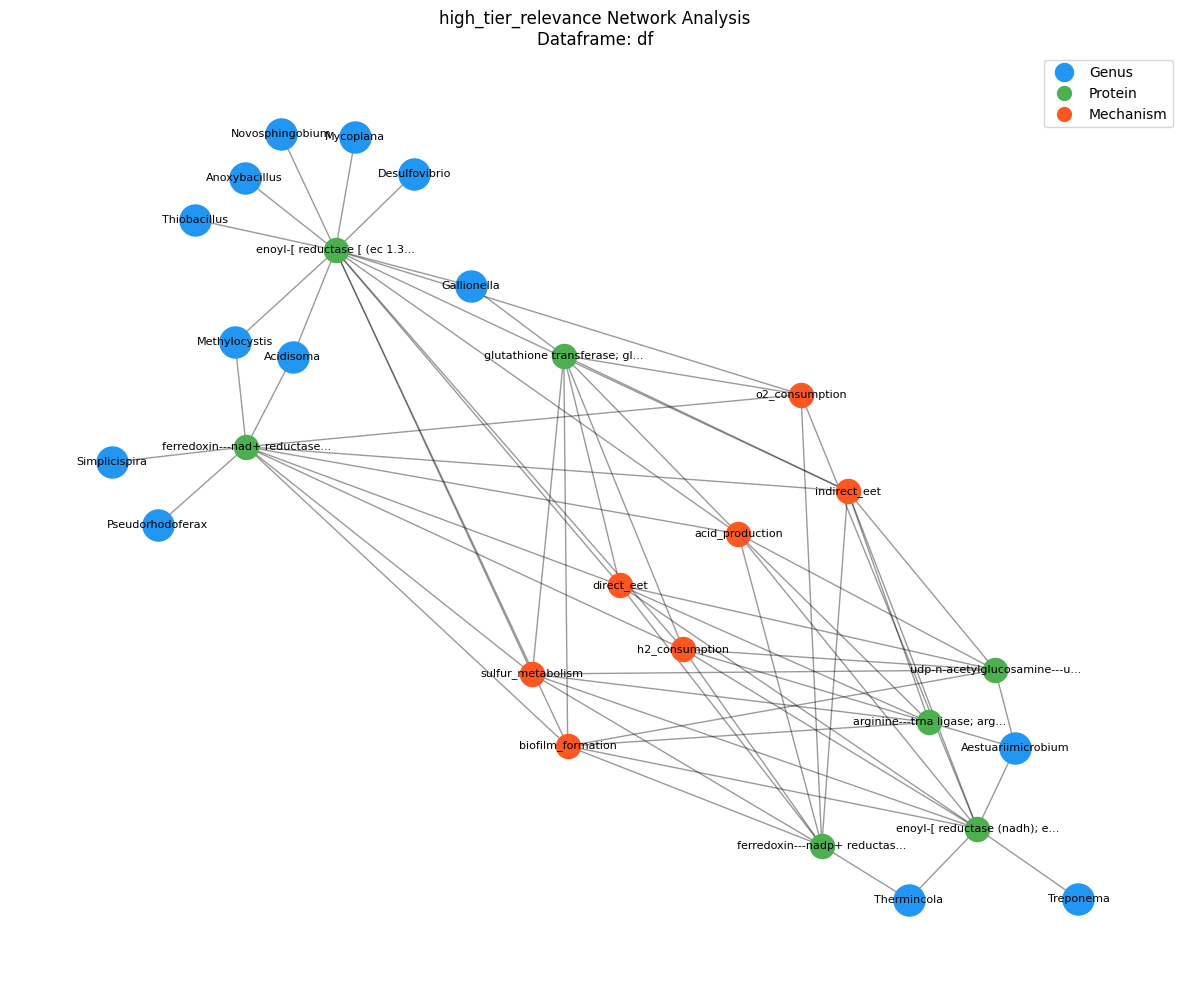


Protein node reference:
glutathione transferase; gl...: glutathione transferase; glutathione s-transferase;
ferredoxin---nad+ reductase...: ferredoxin---nad+ reductase; ferredoxin-nicotinamide
ferredoxin---nadp+ reductas...: ferredoxin---nadp+ reductase; ferredoxin-nicotinamide
enoyl-[ reductase [ (ec 1.3...: enoyl-[ reductase [ (ec 1.3.1.9)
enoyl-[ reductase (nadh); e...: enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
udp-n-acetylglucosamine---u...: udp-n-acetylglucosamine---undecaprenyl-phosphate n
arginine---trna ligase; arg...: arginine---trna ligase; arginyl-trna-synthetase; arginyl


<Figure size 640x480 with 0 Axes>

In [67]:
# Using different color schemes corrosion_critical, "corrosion_critical
G1 = create_static_network(high_tier_relevance, "high_tier_relevance", top_n=20, threshold=0.5)
prot_path = shared_dir/"27_network.png"
plt.savefig(prot_path, dpi=300, bbox_inches='tight')

# 5. Pathways
## 5.1 Bubble Pathway Enrichment across Risk Categories
Plot shows metabolic pathways present in the corrosion environment, how abundant each pathway is across different corrosion risk categories. The pathways increase/decrease with severity or specific conditions
Biological processes are identified, which be involved in corrosion mechanisms across different risk levels.The bubble chart visualization uses
Y-axis: Different metabolic pathways
X-axis: Risk categories (Normal Operation, Early Warning, System Failure)
Bubble size: Mean abundance of the pathway in that category
Bubble color: Pattern type (increasing, decreasing, or unique to a category)

In [68]:
def plot_pathway_enrichment(classified_results, name):
    """
    Creates a bubble chart showing pathway enrichment by risk category,
    accounting for unique patterns in specific categories.
    """
    # Extract top pathways from the dataset
    pathway_data = []

    for _, row in classified_results.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            for pathway in pathways: 
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 1',
                    'mean_abundance': row['mean_cat1'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 2',
                    'mean_abundance': row['mean_cat2'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 3',
                    'mean_abundance': row['mean_cat3'],
                    'classification': row['pathway_classification']
                })

    # Convert to DataFrame
    pathway_df = pd.DataFrame(pathway_data)

    # Group by pathway and category, calculate mean abundance
    grouped = pathway_df.groupby(['pathway', 'category', 'classification'], as_index=False)['mean_abundance'].mean()

    # Add pattern detection: dominant category
    pivot = grouped.pivot_table(index='pathway', columns='category', values='mean_abundance').reset_index()

    # Identify dominant category for each pathway
    pivot['dominant_cat'] = pivot[['Category 1', 'Category 2', 'Category 3']].idxmax(axis=1)
    pivot['max_value'] = pivot[['Category 1', 'Category 2', 'Category 3']].max(axis=1)
    pivot['pattern'] = 'unique_' + pivot['dominant_cat'].str.replace('Category ', 'cat')

    # Calculate fold changes directly from pivot data
    epsilon = 1e-10  # CORRECTED: Using 10^-10 for biological data precision

    # Cat3 vs Cat1 fold change
    safe_cat1 = pivot['Category 1'].clip(lower=epsilon)
    safe_cat3 = pivot['Category 3'].clip(lower=epsilon)
    pivot['fold_change_3vs1'] = safe_cat3 / safe_cat1
    pivot['log2fc_3vs1'] = np.log2(pivot['fold_change_3vs1'])

    # Cat2 vs Cat1 fold change
    safe_cat2 = pivot['Category 2'].clip(lower=epsilon)
    pivot['fold_change_2vs1'] = safe_cat2 / safe_cat1
    pivot['log2fc_2vs1'] = np.log2(pivot['fold_change_2vs1'])

    # Cat3 vs Cat2 fold change
    pivot['fold_change_3vs2'] = safe_cat3 / safe_cat2
    pivot['log2fc_3vs2'] = np.log2(pivot['fold_change_3vs2'])

    # Identify increasing or decreasing patterns
    # Pattern is "increasing" if Cat1 < Cat2 < Cat3
    pivot['is_increasing'] = (
        (pivot['Category 1'] < pivot['Category 2']) &
        (pivot['Category 2'] < pivot['Category 3'])
    )

    # Pattern is "decreasing" if Cat1 > Cat2 > Cat3
    pivot['is_decreasing'] = (
        (pivot['Category 1'] > pivot['Category 2']) &
        (pivot['Category 2'] > pivot['Category 3'])
    )

    # Update pattern label based on trend
    pivot.loc[pivot['is_increasing'], 'pattern'] = 'increasing'
    pivot.loc[pivot['is_decreasing'], 'pattern'] = 'decreasing'

    # Handle infinity and NaN values with more moderate caps
    for col in ['log2fc_3vs1', 'log2fc_2vs1', 'log2fc_3vs2']:
        pivot[col] = pivot[col].replace([np.inf, -np.inf], [5, -5])  # More moderate caps
        pivot[col] = pivot[col].fillna(0)
    
    # Merge back the pattern information
    enrichment = pd.merge(
        grouped,
        pivot[['pathway', 'fold_change_3vs1', 'log2fc_3vs1', 'pattern', 'dominant_cat']],
        on='pathway'
    )

    # Get top pathways for each pattern type
    pattern_types = pivot['pattern'].unique()
    top_pathways = []

    for pattern in pattern_types:
        # Get top 5 pathways for this pattern
        pattern_data = enrichment[enrichment['pattern'] == pattern].copy(deep=False)
        if len(pattern_data) > 0:
            if pattern == 'increasing':
                # For increasing, get highest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=False).head(5)
            elif pattern == 'decreasing':
                # For decreasing, get lowest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=True).head(5)
            else:
                # For unique patterns, get highest mean abundance
                top = pattern_data.sort_values('mean_abundance', ascending=False).head(5)
            top_pathways.append(top)

    # Combine all top pathways
    plot_data = pd.concat(top_pathways)

    plot_data = plot_data.dropna(subset=['mean_abundance'])

    # Create a bubble chart
    fig = px.scatter(
        plot_data,
        x='category',
        y='pathway',
        size='mean_abundance',
        size_max=15,
        color='pattern',
        hover_data=['classification', 'mean_abundance'],
        height=400,
        width=800,
        title=(f" Pathway Enrichment for {name} group across Risk Categories"),
        labels={
            'category': 'Risk Category',
            'pathway': 'Metabolic Pathway',
            'mean_abundance': 'Mean Abundance',
            'pattern': 'Abundance Pattern'
        },
        color_discrete_map={
            'increasing': '#4CAF50',  # Green
            'decreasing': '#F44336',  # Red
            'unique_cat1': '#2196F3',  # Blue
            'unique_cat2': '#FF9800',  # Orange
            'unique_cat3': '#9C27B0'   # Purple
        }, category_orders={"category": ["Category 1", "Category 2", "Category 3"]}
    )

    # Update layout for better readability
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        legend_title_text='Abundance Pattern',
        xaxis_title='Risk Category',
        yaxis_title='Metabolic Pathway'
    )

    return fig, pivot

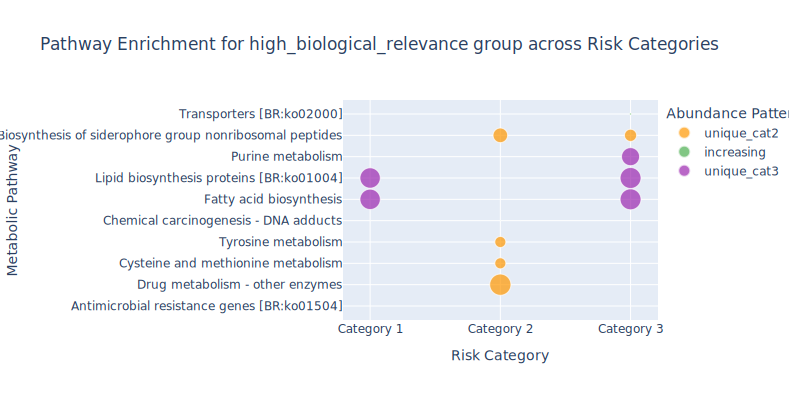

In [69]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(high_biological_relevance, "high_biological_relevance")
Pathway_enrichment.show(renderer="svg")
output_path = shared_dir/"28_buble.png"
Pathway_enrichment.write_image(output_path)

The group high confidence is the largest one of the selected after balanced markers, the category 3 patterns are marked by prokaryotic defense system which increased drastically from cat1 to cat3. The lipid biosyntesis, aminoacid and cyano amino acid metabolism, nitrotoluene degradation and other fixation pathways only are present on cat3 as well as the quorum sensing which corelates with biofilm stablishement on corroded environments. Markers for early warning cat2 are fatty acids, lipids metabolism, together with flavonoids degradataion which are a bridge to more deteriorated environments.

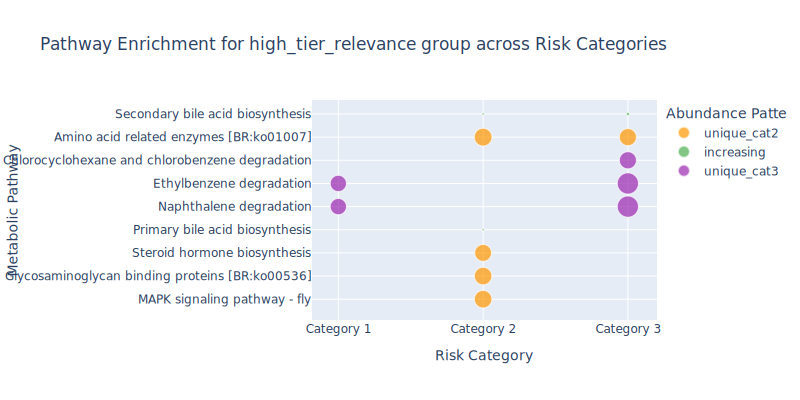

In [70]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(high_tier_relevance , "high_tier_relevance")
Pathway_enrichment.show(renderer="svg")
output_path = shared_dir/"29_buble.png"
Pathway_enrichment.write_image(output_path)

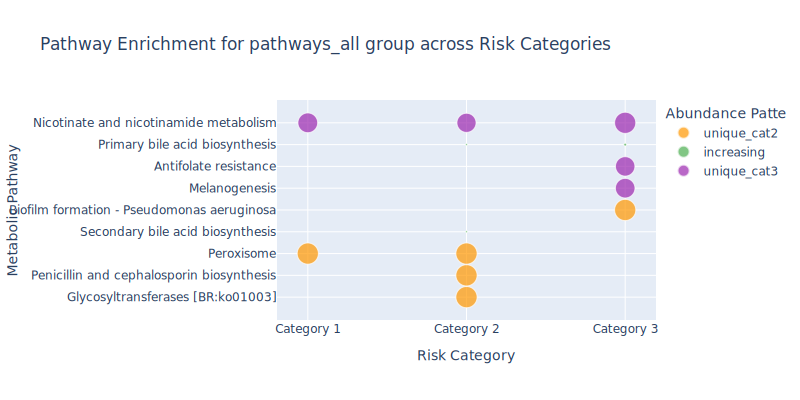

In [71]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(pathways_all , "pathways_all")
Pathway_enrichment.show(renderer="svg")
output_path = shared_dir/"30_enrich.png"
Pathway_enrichment.write_image(output_path)

The significant markers is a group filtered drastically and hence the proceses seen here are more specific. The metabolism of valina, leucine and isoleucine degradation increase with risk label. The Alanine, spartate and glutamate metabolim seems to be only on cat3, also cyanoamino acid mettabolism, nitrotoluen degradation lipid byosinstesis and other carbon pathways, which are only specific to category 3 system failure. On the early warning cat2 we found also specific process to that category such as exosome, other glycan degradation, sphingolipid degradation and metabolism, fructuosa and manosa as well as flavonoids degradation. The metabolites on the system failure are more toxic ones as the early warning, there are no category 1 metabolism because these are filtered markers and it is no expected aromatics are propose to be the most enriched pathways on this function, whith the motility andand oter carbon fixations pathways, which is interesting to see the penicilin being anotated there, it might be noticed that the anotations here visualised come from different databases anotaated on the EC numbers reported by the picrust alogrithm and are no direct measures. The cunction for enrichement has been done on two groups first

##  5.2. Sunburns KO representation of pathways for a specific risk category.

In [72]:
def create_sunburst_chart(data_frame, name, top_n=None, category=3):
    """
    Create a sunburst chart using only enzyme classification:
    - Root level: First part of enzyme classification
    - Inner levels: Subsequent parts of enzyme class (if available)
    """
    sig_df = data_frame.sort_values(by='combined_score', ascending=False).head(top_n)
    
    # Prepare data for sunburst chart
    sunburst_data = []
    for _, row in sig_df.iterrows():
        # Get enzyme class
        enzyme_class = row['enzyme_class']
        if pd.isna(enzyme_class) or not isinstance(enzyme_class, str) or not enzyme_class:
            enzyme_class = 'Other Enzymes'
        
        # Split enzyme class into levels - you can adjust the delimiter if needed
        # Common delimiters: ';', '.', '-', or create your own parsing logic
        if ';' in enzyme_class:
            enzyme_levels = enzyme_class.split(';')[:3]  # Limit to 3 levels
        elif '.' in enzyme_class:
            enzyme_levels = enzyme_class.split('.')[:3]
        elif '-' in enzyme_class:
            enzyme_levels = enzyme_class.split('-')[:3]
        else:
            # If no standard delimiter, use the whole string as one level
            enzyme_levels = [enzyme_class]
        
        # Clean each level
        enzyme_levels = [level.strip() for level in enzyme_levels if level.strip()]
        
        # Ensure we have at least one level
        if not enzyme_levels:
            enzyme_levels = ['Other Enzymes']
        
        # Calculate abundance value
        abundance = row[f'mean_cat{category}']
        
        # Get dominant category
        cat_values = [row['mean_cat1'], row['mean_cat2'], row['mean_cat3']]
        dominant_cat = cat_values.index(max(cat_values)) + 1
        
        # Create simplified description for hover
        simple_description = "<br>".join([ 
            f"<b>Enzyme Class</b>: {row['enzyme_class']}",
            f"<b>Genus</b>: {row['Genus']}",
            f"<b>Protein Name</b>: {row['protein_name']}"
        ])
        
        # Add the data point (leaf node)
        sunburst_data.append({
            'id': f"{'/'.join(enzyme_levels)}__{row['idx']}",
            'parent': f"{'/'.join(enzyme_levels[:-1])}__{row['idx']}" if len(enzyme_levels) > 1 else '',
            'labels': enzyme_levels[-1] if len(enzyme_levels[-1]) < 30 else enzyme_levels[-1][:27] + '...',
            'values': abundance,
            'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
            'simplified_info': simple_description
        })
        
        # Add parent paths
        for i in range(len(enzyme_levels)-1, 0, -1):
            parent_path = '/'.join(enzyme_levels[:i])
            path = '/'.join(enzyme_levels[:i+1])
            
            if not any(d['id'] == path for d in sunburst_data):
                label_text = enzyme_levels[i]
                if len(label_text) > 40:
                    label_text = label_text[:37] + '...'
                    
                sunburst_data.append({
                    'id': path,
                    'parent': parent_path if i > 1 else '',
                    'labels': label_text,
                    'values': abundance,
                    'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
                    'simplified_info': f"<b>Enzyme Group</b>: {'/'.join(enzyme_levels[:i+1])}"
                })
                
        # Add root node if needed
        if len(enzyme_levels) > 0 and not any(d['id'] == enzyme_levels[0] for d in sunburst_data):
            root_label = enzyme_levels[0]
            if len(root_label) > 50:
                root_label = root_label[:47] + '...'
                
            sunburst_data.append({
                'id': enzyme_levels[0],
                'parent': '',
                'labels': root_label,
                'values': abundance,
                'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
                'simplified_info': f"<b>Enzyme Class</b>: {enzyme_levels[0]}"
            })
            
    # Convert to DataFrame
    sunburst_df = pd.DataFrame(sunburst_data)
    
    # Category color mapping
    color_map = {
        'Normal Operation':'#008800',  # Green
        'Early Warning': '#FF8C00',     # Orange
        'System Failure': '#FF0000'     # Red
    }
    
    # Create the sunburst chart
    fig = px.sunburst(
        sunburst_df,
        ids='id',
        parents='parent',
        names='labels',
        values='values',
        color='dominant_category',
        color_discrete_map=color_map,
        title=f'Group {name} Enzyme Classification by Category {category}',
        custom_data=['simplified_info']
    )
    
    # Update hover template and enable text where it fits
    fig.update_traces(
        hovertemplate='%{customdata[0]}',
        textinfo='label',       # Show text labels where possible
        insidetextorientation='radial',  # Orient text radially
        branchvalues='total'   # Use total values for better proportional representation
    )
    
    # Add white separator lines between sectors
    fig.update_traces(
        marker=dict(
            line=dict(color='white', width=1.5)
        )
    )
    
    # Update layout for 600px width
    fig.update_layout(
        width=800,
        height=600,
        margin=dict(t=50, l=10, r=10, b=10),  # t=top, l=left, r=right, b=bottom
        legend_title="System Status",
        font=dict(size=12),  # Smaller base font size for 600px width
        hoverlabel=dict(
            font_size=12,  # Popup text size
            bgcolor="white"
        )
    )
   
    return fig, sunburst_df

In [73]:
fig,  sunburst_data  = create_sunburst_chart(functional_categories, "functional_categories", top_n=20, category=3)
# Save as static image
output_path= shared_dir/"31_sunburn.png"
fig.write_image(output_path, scale=3)

# Show in notebook/browser
fig.show()

## 5.3. Corrosion Relevant Pathways
Focus on corrosion-relevant pathways by categorizing them into:

Organic acid metabolism (relevant to our acetate/oxalate observations)
Sulfur metabolism
Metal interactions
Biofilm formation

In [74]:
def plot_pathway_analysis(df, name, num_items=25):
    """
    Create visualizations for pathway analysis - optimized version with only the most informative plots
    Parameters:
    df: DataFrame containing pathway analysis results
    name: Name of the original DataFrame (for labeling purposes)
    num_items: Number of items to show in plots (default: 25)
    """
    from matplotlib.lines import Line2D
    
    # Category colors
    category_colors = {1: '#008800', 2: '#FFA500', 3: '#FF0000'} # Green, Orange, Red
    categories_labels = {1: 'Category 1', 2: 'Category 2', 3: 'Category 3'}
    
    # Get top N entries based on combined_score
    top_data = df.sort_values('combined_score', ascending=False).head(num_items).copy()
    
    # Create proper labels with genus and protein name - no truncation
    top_data['label'] = top_data.apply(lambda x: f"{x['Genus']} - {x['protein_name']}", axis=1)
    
    # ====== PLOT 1: Fold Change and Mean Abundance ======
    fig, ax1 = plt.subplots(figsize=(10, min(9, max(5, len(top_data)*0.2))))
    ax2 = ax1.twinx()
    
    # Plot fold change
    bars = ax1.barh(range(len(top_data)), top_data['fold_change_3vs1'], color='skyblue')
    
    # Plot mean abundance on secondary axis
    line = ax2.plot(top_data['mean_cat3'], range(len(top_data)),
                    marker='o', color='red', linestyle='--')
    
    # Set labels and titles
    ax1.set_yticks(range(len(top_data)))
    ax1.set_yticklabels(top_data['label'])
    ax1.set_title(f'{name}: Pathways', fontsize=12)
    ax1.set_xlabel('Fold Change (Cat3/Cat1)', fontsize=10)
    ax1.set_ylabel('Protein', fontsize=10)
    ax2.set_xlabel('Mean Abundance in Cat3', fontsize=10)
    
    # Add a legend
    legend_elements = [
        Line2D([0], [0], color='skyblue', lw=4, label='Fold Change (Cat3/Cat1)'),
        Line2D([0], [0], marker='o', color='red', label='Mean Abundance Cat3',
               markersize=6, linestyle='--')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')  # Changed to upper right
    
    plt.tight_layout()
    plt.show()
    
    # ====== PLOT 2: Enhanced Category Comparison ======
    fig, ax = plt.subplots(figsize=(10, min(8, max(7, len(top_data)*0.1))))

    # Create indices for plotting  
    indices = np.arange(len(top_data))

    # Calculate height based on number of items
    bar_height = min(0.8, 0.25 * (20 / len(top_data)))  

    # Sort data by fold change for better visualization
    sorted_data = top_data.sort_values('fold_change_3vs1', ascending=True)  # Changed to ascending

    # Plot each category with specified colors - using barh for horizontal bars
    bars1 = ax.barh(indices - bar_height, sorted_data['mean_cat1'], height=bar_height,
                color=category_colors[1], label=categories_labels[1])
    bars2 = ax.barh(indices, sorted_data['mean_cat2'], height=bar_height,
                color=category_colors[2], label=categories_labels[2])
    bars3 = ax.barh(indices + bar_height, sorted_data['mean_cat3'], height=bar_height,
                color=category_colors[3], label=categories_labels[3])

    # Create a second x-axis for fold change (top axis)
    ax2 = ax.twiny()
    line = ax2.plot(sorted_data['fold_change_3vs1'], indices, 'ko-', linewidth=2,
                    marker='D', markersize=6, label='Fold Change (Cat3/Cat1)')

    # Set labels and titles
    ax.set_ylabel('Proteins', fontsize=14)
    ax.set_xlabel('Mean Abundance', fontsize=12)
    #ax2.set_xlabel('Fold Change (Cat3/Cat1)', fontsize=12)
    plt.title(f'{name}: Abundance & Fold Change (Cat3/Cat1)', fontsize=14, pad=40)

    # Set y-ticks with protein labels
    ax.set_yticks(indices)
    ax.set_yticklabels(sorted_data['label'], fontsize=8)

    # Create a single legend for both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()

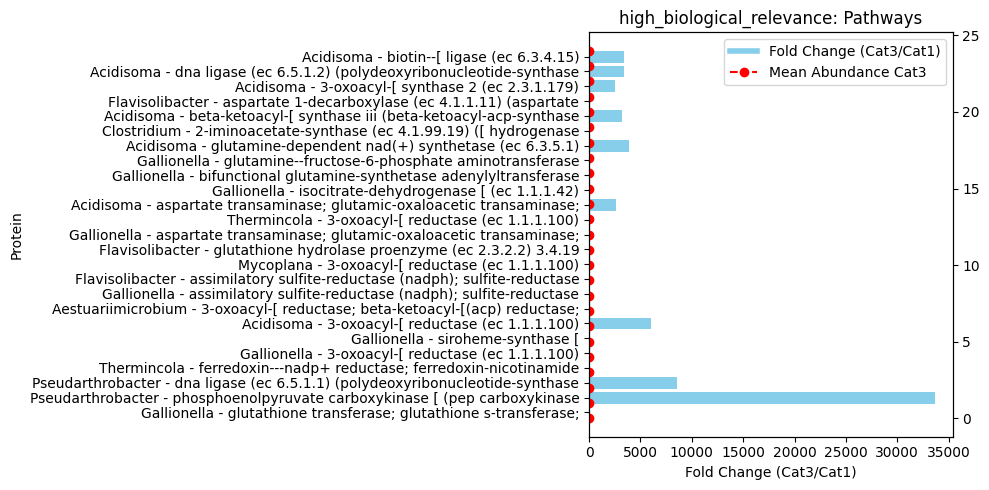

/tmp/ipykernel_6066/179414936.py:73: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko-" (-> marker='o'). The keyword argument will take precedence.



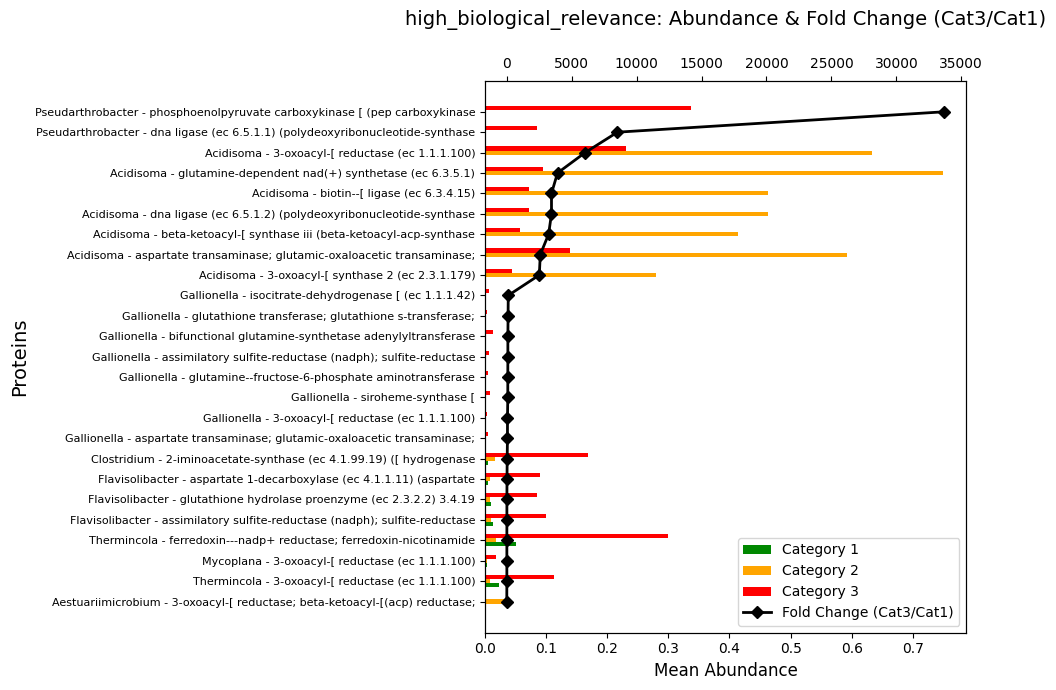

In [75]:
plot_pathway_analysis(high_biological_relevance , "high_biological_relevance", num_items=25)
output_share = shared_dir/"31_pathways"
fig.write_image(output_share, scale=3)

## 5.4 Pathway Categories Mirror comparison

In [76]:
def plot_mirrored_pathway_comparison(df, pathway_categories, cat1='organic_acid_metabolism', cat2='iron_sulfur_redox'):
    # Build lookup for categories
    category_terms = {k: v for k, v in cs.pathway_categories.items()}
    
    def match_pathways(row, terms):
        return any(term.lower() in str(row['pathways']).lower() for term in terms)
    
    # Filter rows
    df_cat1 = df[df.apply(lambda row: match_pathways(row, category_terms.get(cat1, [])), axis=1)].copy()
    df_cat2 = df[df.apply(lambda row: match_pathways(row, category_terms.get(cat2, [])), axis=1)].copy()
    
    # Create smart labeling function
    def create_smart_label(row, max_chars=50):
        full_label = row['Genus'] + ' - ' + row['protein_name']
        if len(full_label) <= max_chars:
            return full_label, None
        else:
            truncated_label = full_label[:max_chars-6] + "... "
            return truncated_label, full_label
    
    # Apply smart labeling
    display_labels_cat1 = []
    display_labels_cat2 = []
    reference_dict_cat1 = {}
    reference_dict_cat2 = {}
    reference_counter = 1
    
    # Process left side (cat1)
    for idx, row in df_cat1.iterrows():
        display_label, full_label = create_smart_label(row)
        if full_label:
            display_labels_cat1.append(f"{display_label}[{reference_counter}]")
            reference_dict_cat1[reference_counter] = full_label
            reference_counter += 1
        else:
            display_labels_cat1.append(display_label)
    
    # Process right side (cat2)
    for idx, row in df_cat2.iterrows():
        display_label, full_label = create_smart_label(row)
        if full_label:
            display_labels_cat2.append(f"{display_label}[{reference_counter}]")
            reference_dict_cat2[reference_counter] = full_label
            reference_counter += 1
        else:
            display_labels_cat2.append(display_label)
    
    # Add to dataframes
    df_cat1['label'] = display_labels_cat1
    df_cat2['label'] = display_labels_cat2
    
    # Create figure using matplotlib correctly
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(len(df_cat1), len(df_cat2))*0.3))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(3, max(len(df_cat1), len(df_cat2))*0.3)))
    
    # Left plot
    if len(df_cat1) > 0:
        ax1.barh(df_cat1['label'], df_cat1['log2fc_2vs1'], 
                 color=df_cat1['Category'].map({1: '#008800', 2: '#FF8C00', 3: '#FF0000'}))
    ax1.set_title(cat1.replace('_', ' ').title())
    ax1.set_xlabel('log2 Fold Change (2 vs 1)')
    ax1.invert_xaxis()
    
    # Right plot  
    if len(df_cat2) > 0:
        ax2.barh(df_cat2['label'], df_cat2['log2fc_3vs2'], 
                 color=df_cat2['Category'].map({1: '#008800', 2: '#FF8C00', 3: '#FF0000'}))
    ax2.set_title(cat2.replace('_', ' ').title())
    ax2.set_xlabel('log2 Fold Change (3 vs 2)')
    ax2.set_yticks([])
    
    # Print reference table for copying
    print("\nNames in this plot:")
    print("-" * 50)
    for idx, row in df_cat1.iterrows():
        print(f"{row['Genus']} - {row['protein_name']}")
    if len(df_cat2) > 0:
        print("-" * 20)
        for idx, row in df_cat2.iterrows():  
            print(f"{row['Genus']} - {row['protein_name']}")
    print("-" * 50)
    
    # Layout
    if max(len(df_cat1), len(df_cat2)) > 2:
        plt.tight_layout()
    plt.show()


Names in this plot:
--------------------------------------------------
Acidisoma - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Pseudorhodoferax - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Methylocystis - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Simplicispira - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Gallionella - enoyl-[ reductase [ (ec 1.3.1.9)
Acidisoma - enoyl-[ reductase [ (ec 1.3.1.9)
Aestuariimicrobium - enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
Mycoplana - enoyl-[ reductase [ (ec 1.3.1.9)
Gallionella - enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
Gallionella - 3-oxoacyl-[ reductase (ec 1.1.1.100)
Thermincola - enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
Acidisoma - enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
Acidisoma - 3-oxoacyl-[ reductase (ec 1.1.1.100)
Aestuariimicrobium - enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
Aestuariimicrobium - 3-oxoacyl-[ reductase;

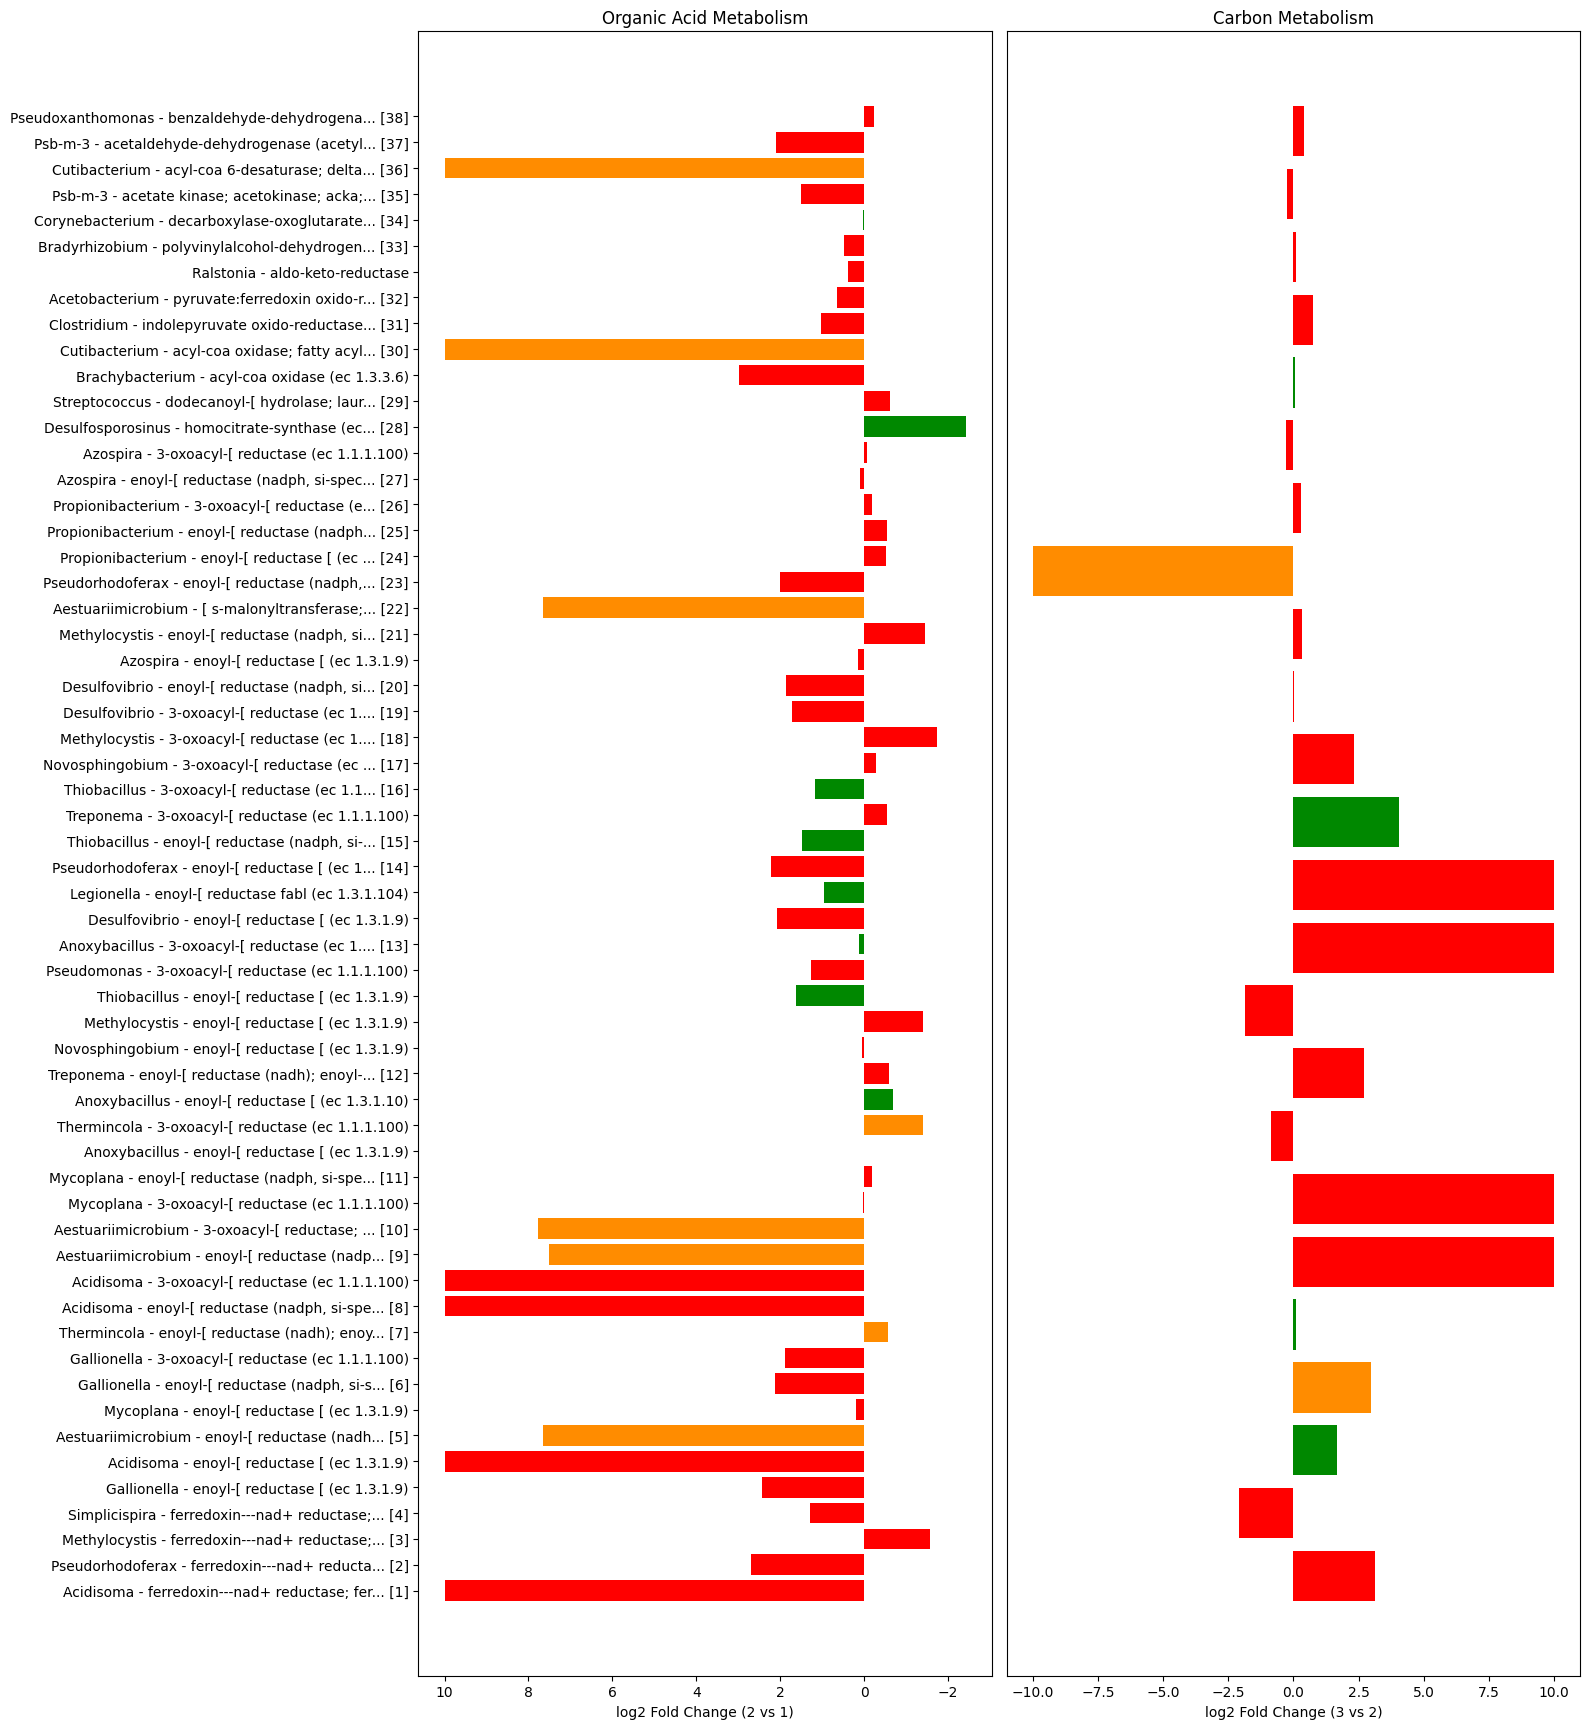

In [77]:
# pathway_categories = {    'hydrogen_metabolism',    'oxygen_metabolism',    'nitrogen_metabolism',    'manganese_processes',    'iron_sulfur_redox',
#'ocre_formation',    'sulfur_metabolism',    'electron_transfer',    'organic_acid_metabolism',  'metal_organic_interaction', 'biofilm_formation',  'carbon_metabolism', 'ph_modulation',     'temp_response',    'halogen_related',    'methanogenesis'}
plot_mirrored_pathway_comparison(organic_metal_synergy, cs.pathway_categories, cat1='organic_acid_metabolism', cat2='carbon_metabolism')
mirror_path = shared_dir/"32_mirror.png"
fig.write_image(mirror_path, scale=3)


Names in this plot:
--------------------------------------------------
Gallionella - assimilatory sulfite-reductase (nadph); sulfite-reductase
Flavisolibacter - assimilatory sulfite-reductase (nadph); sulfite-reductase
Thiobacillus - assimilatory sulfite-reductase (nadph); sulfite-reductase
Azospira - assimilatory sulfite-reductase (nadph); sulfite-reductase
Oerskovia - thiosulfate-dehydrogenase (quinone); thiosulfate:quinone
Clostridium - homoserine o-succinyltransferase (ec 2.3.1.46)
Prevotella - homoserine o-succinyltransferase; homoserine o-transsuccinylase
Wchb1-05 - hydrogen-dehydrogenase (nadp+); nadp+-linked hydrogenase;
--------------------
Gallionella - assimilatory sulfite-reductase (nadph); sulfite-reductase
Flavisolibacter - assimilatory sulfite-reductase (nadph); sulfite-reductase
Thiobacillus - assimilatory sulfite-reductase (nadph); sulfite-reductase
Azospira - assimilatory sulfite-reductase (nadph); sulfite-reductase
Oerskovia - thiosulfate-dehydrogenase (quinone); th

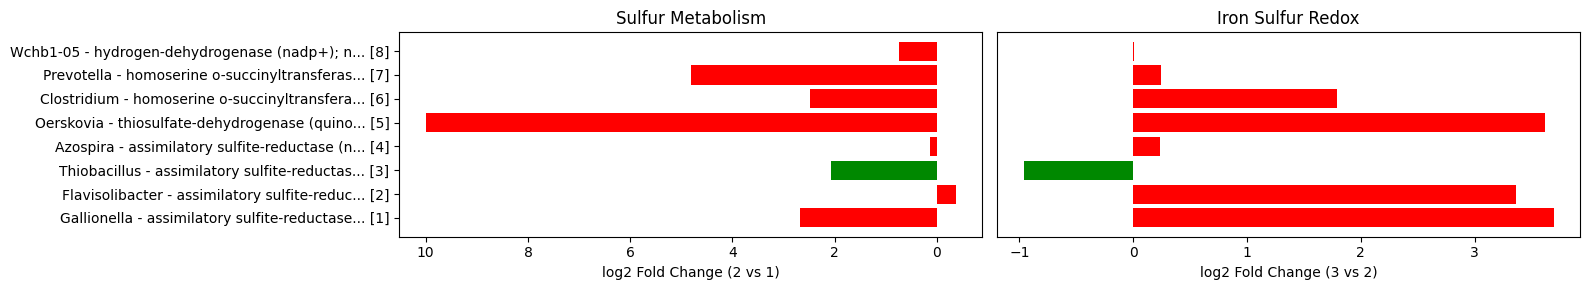

In [78]:
plot_mirrored_pathway_comparison(organic_metal_synergy, cs.pathway_categories, cat1='sulfur_metabolism', cat2='iron_sulfur_redox')
opath = shared_dir/"33_mirror.png"
fig.write_image(opath, scale=3)


Names in this plot:
--------------------------------------------------
Pseudarthrobacter - phosphoenolpyruvate carboxykinase [ (pep carboxykinase
Pseudarthrobacter - dna ligase (ec 6.5.1.1) (polydeoxyribonucleotide-synthase
Gallionella - siroheme-synthase [
Flavisolibacter - glutathione hydrolase proenzyme (ec 2.3.2.2) 3.4.19
Gallionella - isocitrate-dehydrogenase [ (ec 1.1.1.42)
Gallionella - bifunctional glutamine-synthetase adenylyltransferase
Gallionella - glutamine--fructose-6-phosphate aminotransferase
Acidisoma - glutamine-dependent nad(+) synthetase (ec 6.3.5.1)
Clostridium - 2-iminoacetate-synthase (ec 4.1.99.19) ([ hydrogenase
Acidisoma - beta-ketoacyl-[ synthase iii (beta-ketoacyl-acp-synthase
Flavisolibacter - aspartate 1-decarboxylase (ec 4.1.1.11) (aspartate
Acidisoma - 3-oxoacyl-[ synthase 2 (ec 2.3.1.179)
Acidisoma - dna ligase (ec 6.5.1.2) (polydeoxyribonucleotide-synthase
Acidisoma - biotin--[ ligase (ec 6.3.4.15)
Flavisolibacter - udp-3-o-acyl-n-acetylglucosamine de

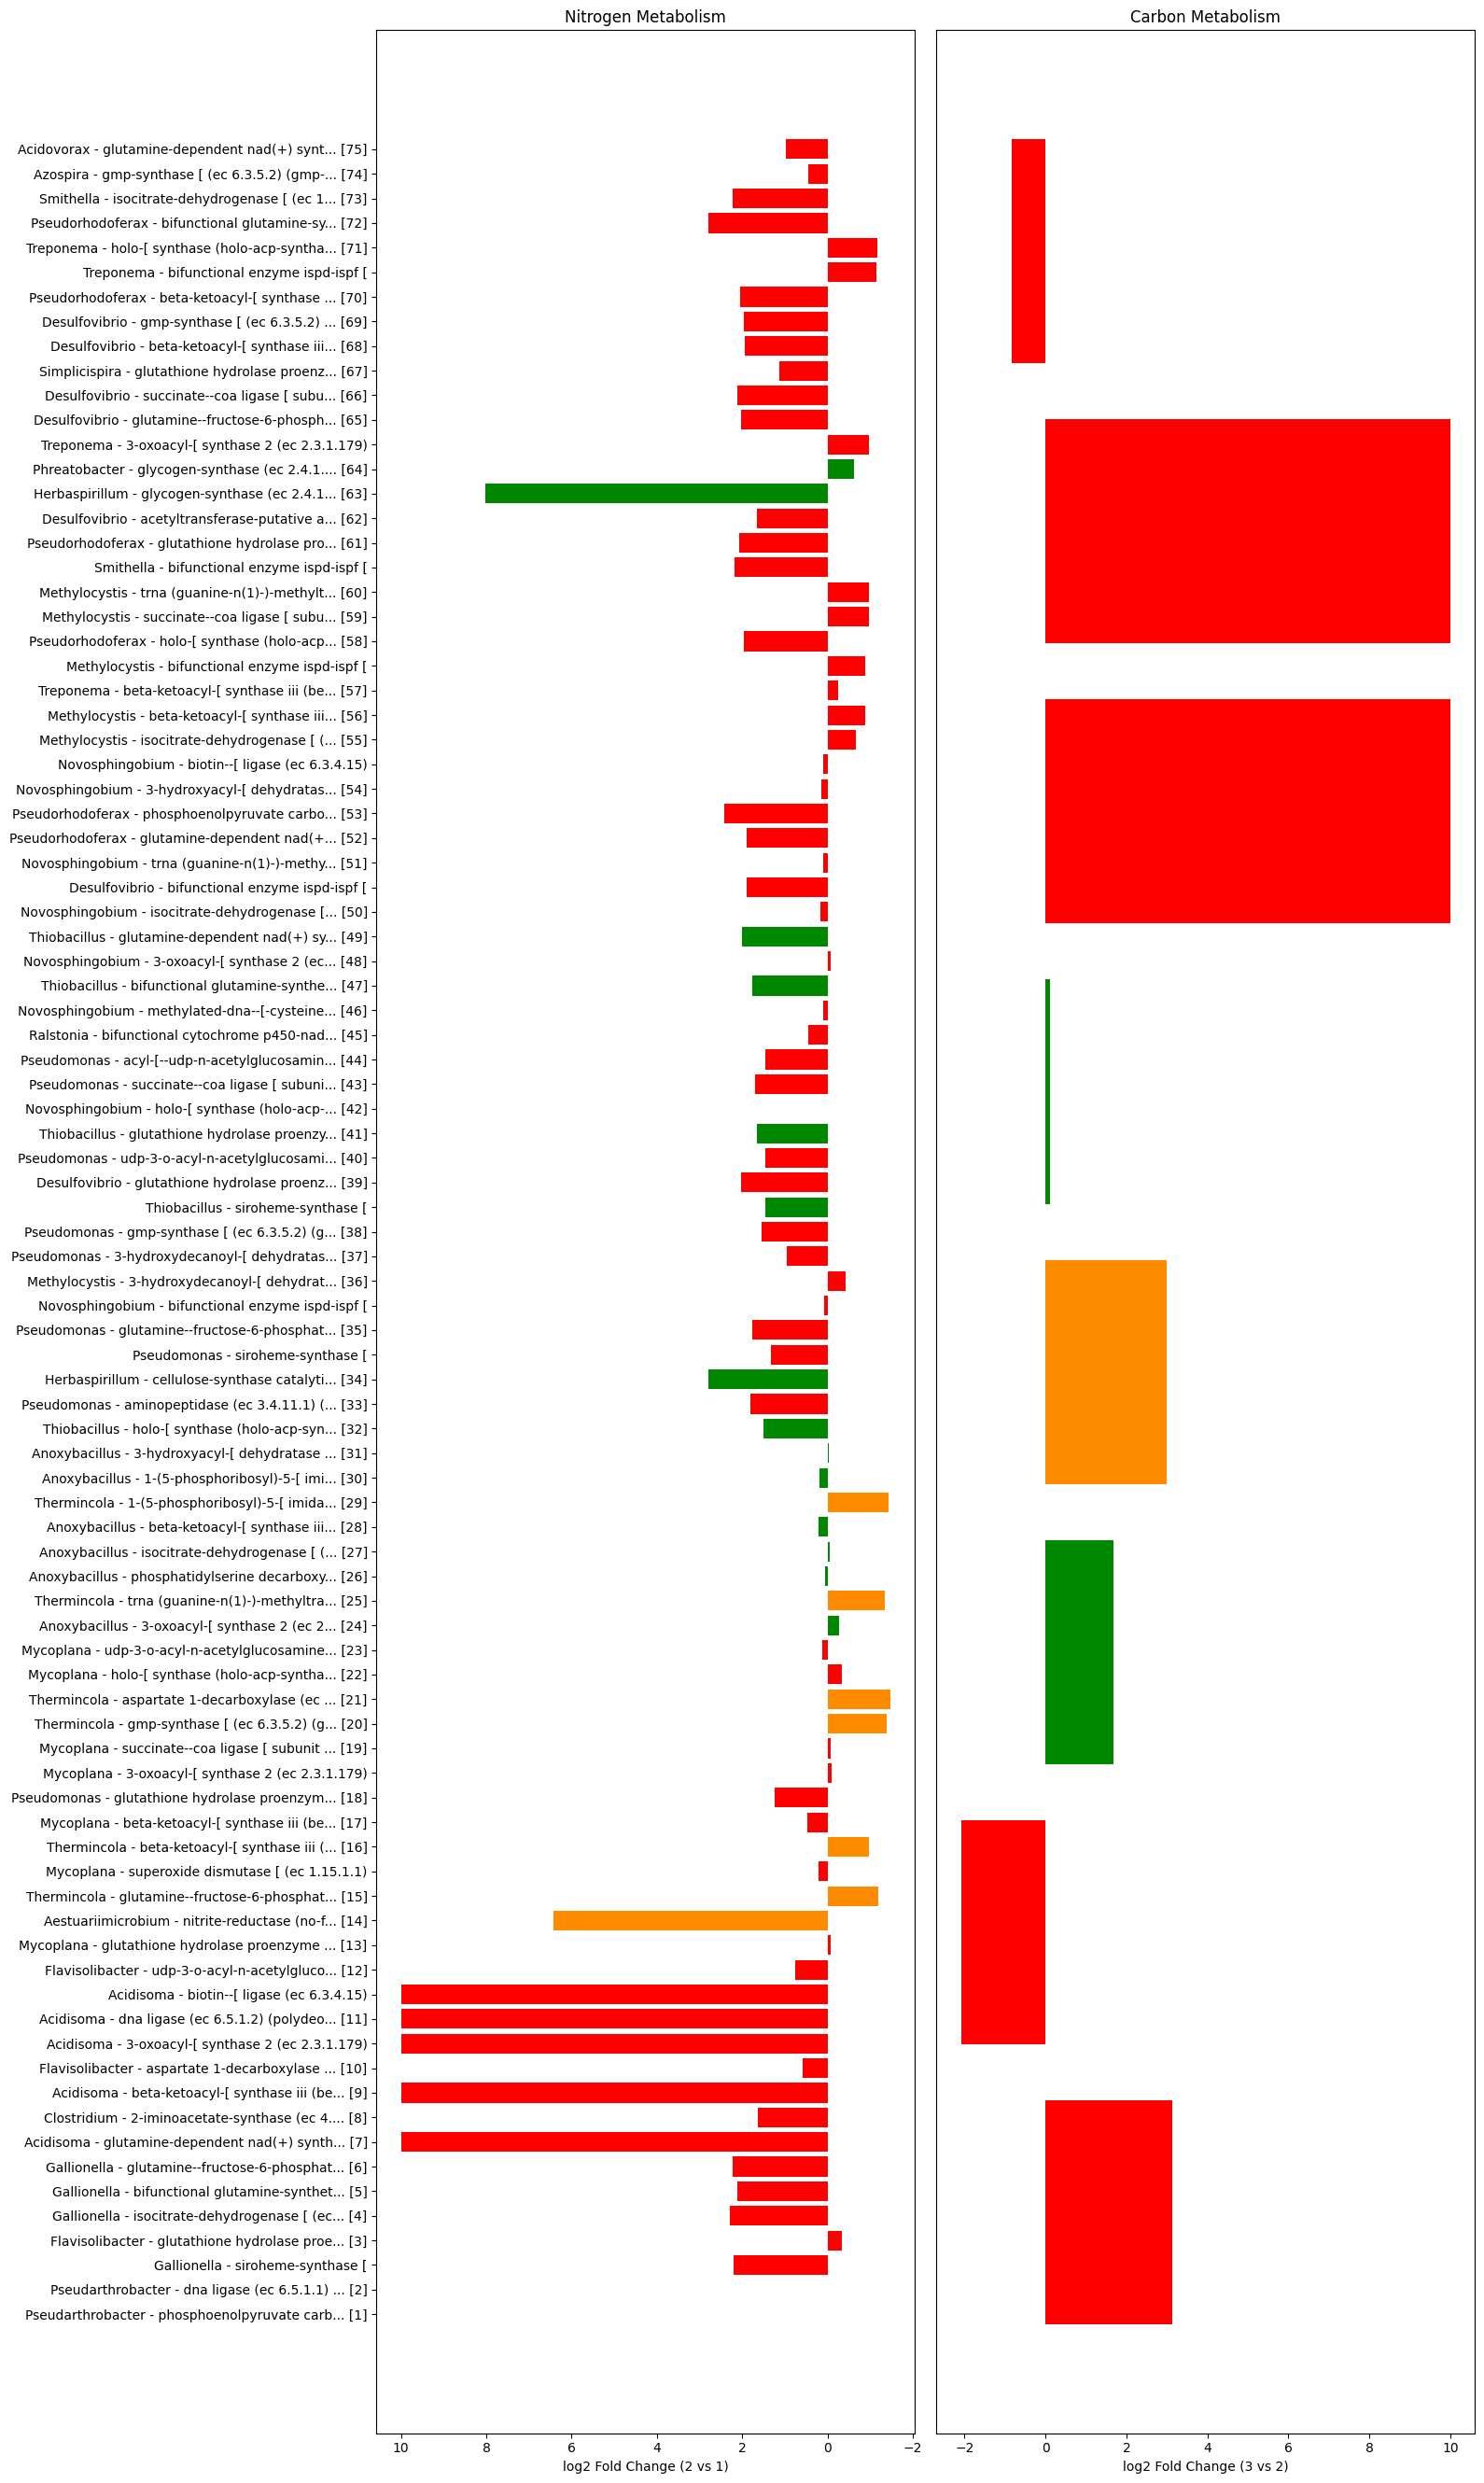

In [79]:
# pathway_categories = {    'hydrogen_metabolism',    'oxygen_metabolism',    'nitrogen_metabolism',    'manganese_processes',    'iron_sulfur_redox',
#'ocre_formation',    'sulfur_metabolism',    'electron_transfer',    'organic_acid_metabolism',  'metal_organic_interaction', 'biofilm_formation',  'carbon_metabolism', 'ph_modulation',     'temp_response',    'halogen_related',    'methanogenesis'}
plot_mirrored_pathway_comparison(top_markers, cs.pathway_categories, cat1='nitrogen_metabolism', cat2= 'carbon_metabolism')
output_path = shared_dir /"34_mirror.png"
fig.write_image(output_path, scale=3)


Names in this plot:
--------------------------------------------------
Acidisoma - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Pseudorhodoferax - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Methylocystis - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Simplicispira - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Gallionella - enoyl-[ reductase [ (ec 1.3.1.9)
Acidisoma - enoyl-[ reductase [ (ec 1.3.1.9)
Aestuariimicrobium - enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
Mycoplana - enoyl-[ reductase [ (ec 1.3.1.9)
Gallionella - enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
Gallionella - 3-oxoacyl-[ reductase (ec 1.1.1.100)
Thermincola - enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
Acidisoma - enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
Acidisoma - 3-oxoacyl-[ reductase (ec 1.1.1.100)
Aestuariimicrobium - enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
Aestuariimicrobium - 3-oxoacyl-[ reductase;

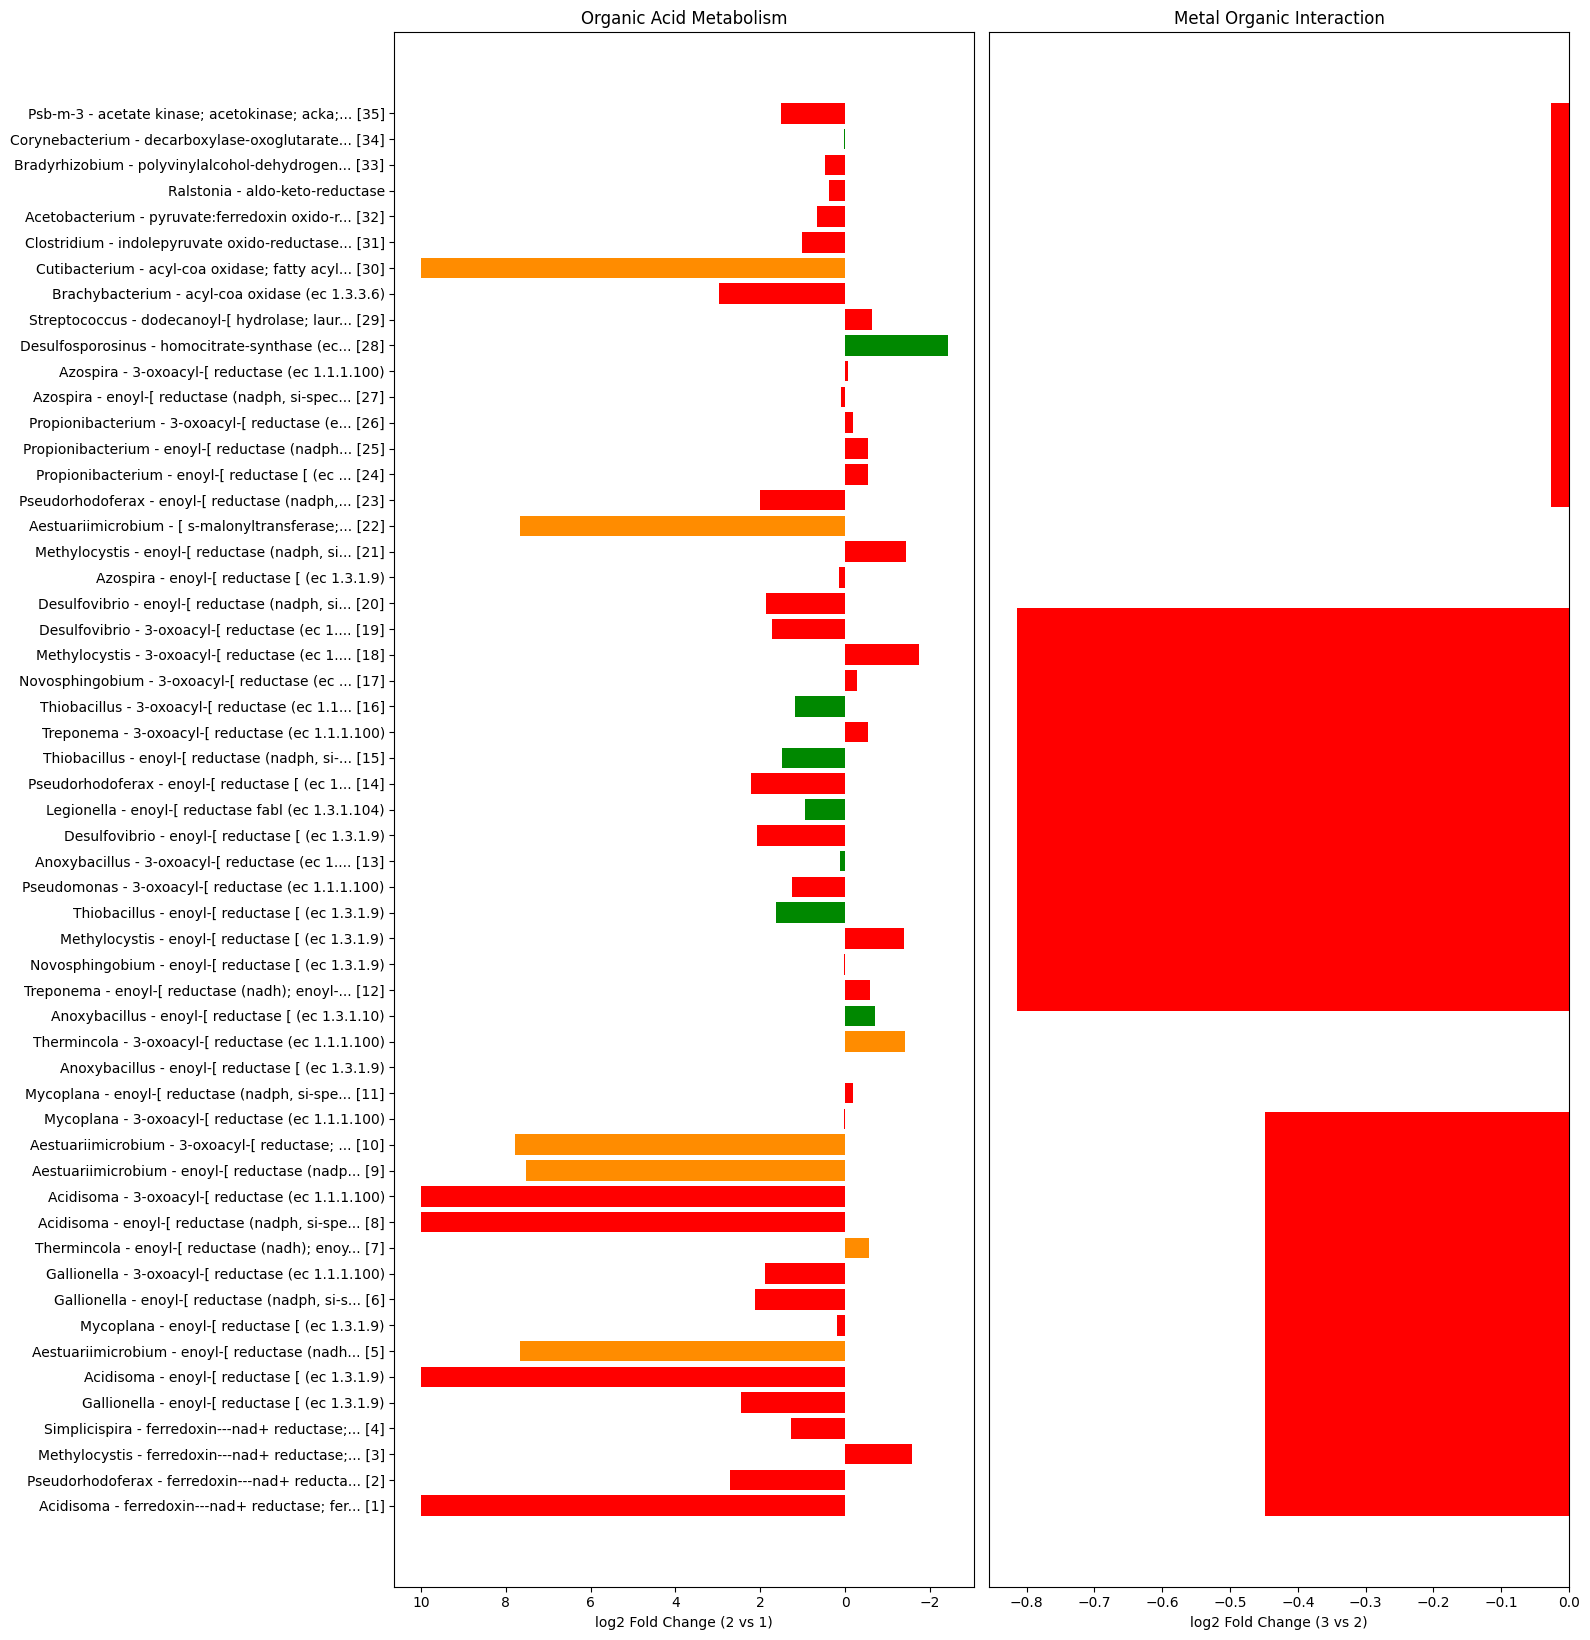

In [80]:
# pathway_categories = {    'hydrogen_metabolism',    'oxygen_metabolism',    'nitrogen_metabolism',    'manganese_processes',    'iron_sulfur_redox',
#'ocre_formation',    'sulfur_metabolism',    'electron_transfer',    'organic_acid_metabolism',  'metal_organic_interaction', 'biofilm_formation',  'carbon_metabolism', 'ph_modulation',     'temp_response',    'halogen_related',    'methanogenesis'}
plot_mirrored_pathway_comparison(high_synergy_markers, cs.pathway_categories, cat1='organic_acid_metabolism', cat2= 'metal_organic_interaction')
output_path = shared_dir /"35_mirror.png"
fig.write_image(output_path, scale=3)


Names in this plot:
--------------------------------------------------
Acidisoma - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Pseudorhodoferax - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Methylocystis - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Simplicispira - ferredoxin---nad+ reductase; ferredoxin-nicotinamide
Gallionella - enoyl-[ reductase [ (ec 1.3.1.9)
Acidisoma - enoyl-[ reductase [ (ec 1.3.1.9)
Aestuariimicrobium - enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
Mycoplana - enoyl-[ reductase [ (ec 1.3.1.9)
Gallionella - enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
Gallionella - 3-oxoacyl-[ reductase (ec 1.1.1.100)
Thermincola - enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl
Acidisoma - enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
Acidisoma - 3-oxoacyl-[ reductase (ec 1.1.1.100)
Aestuariimicrobium - enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase
Aestuariimicrobium - 3-oxoacyl-[ reductase;

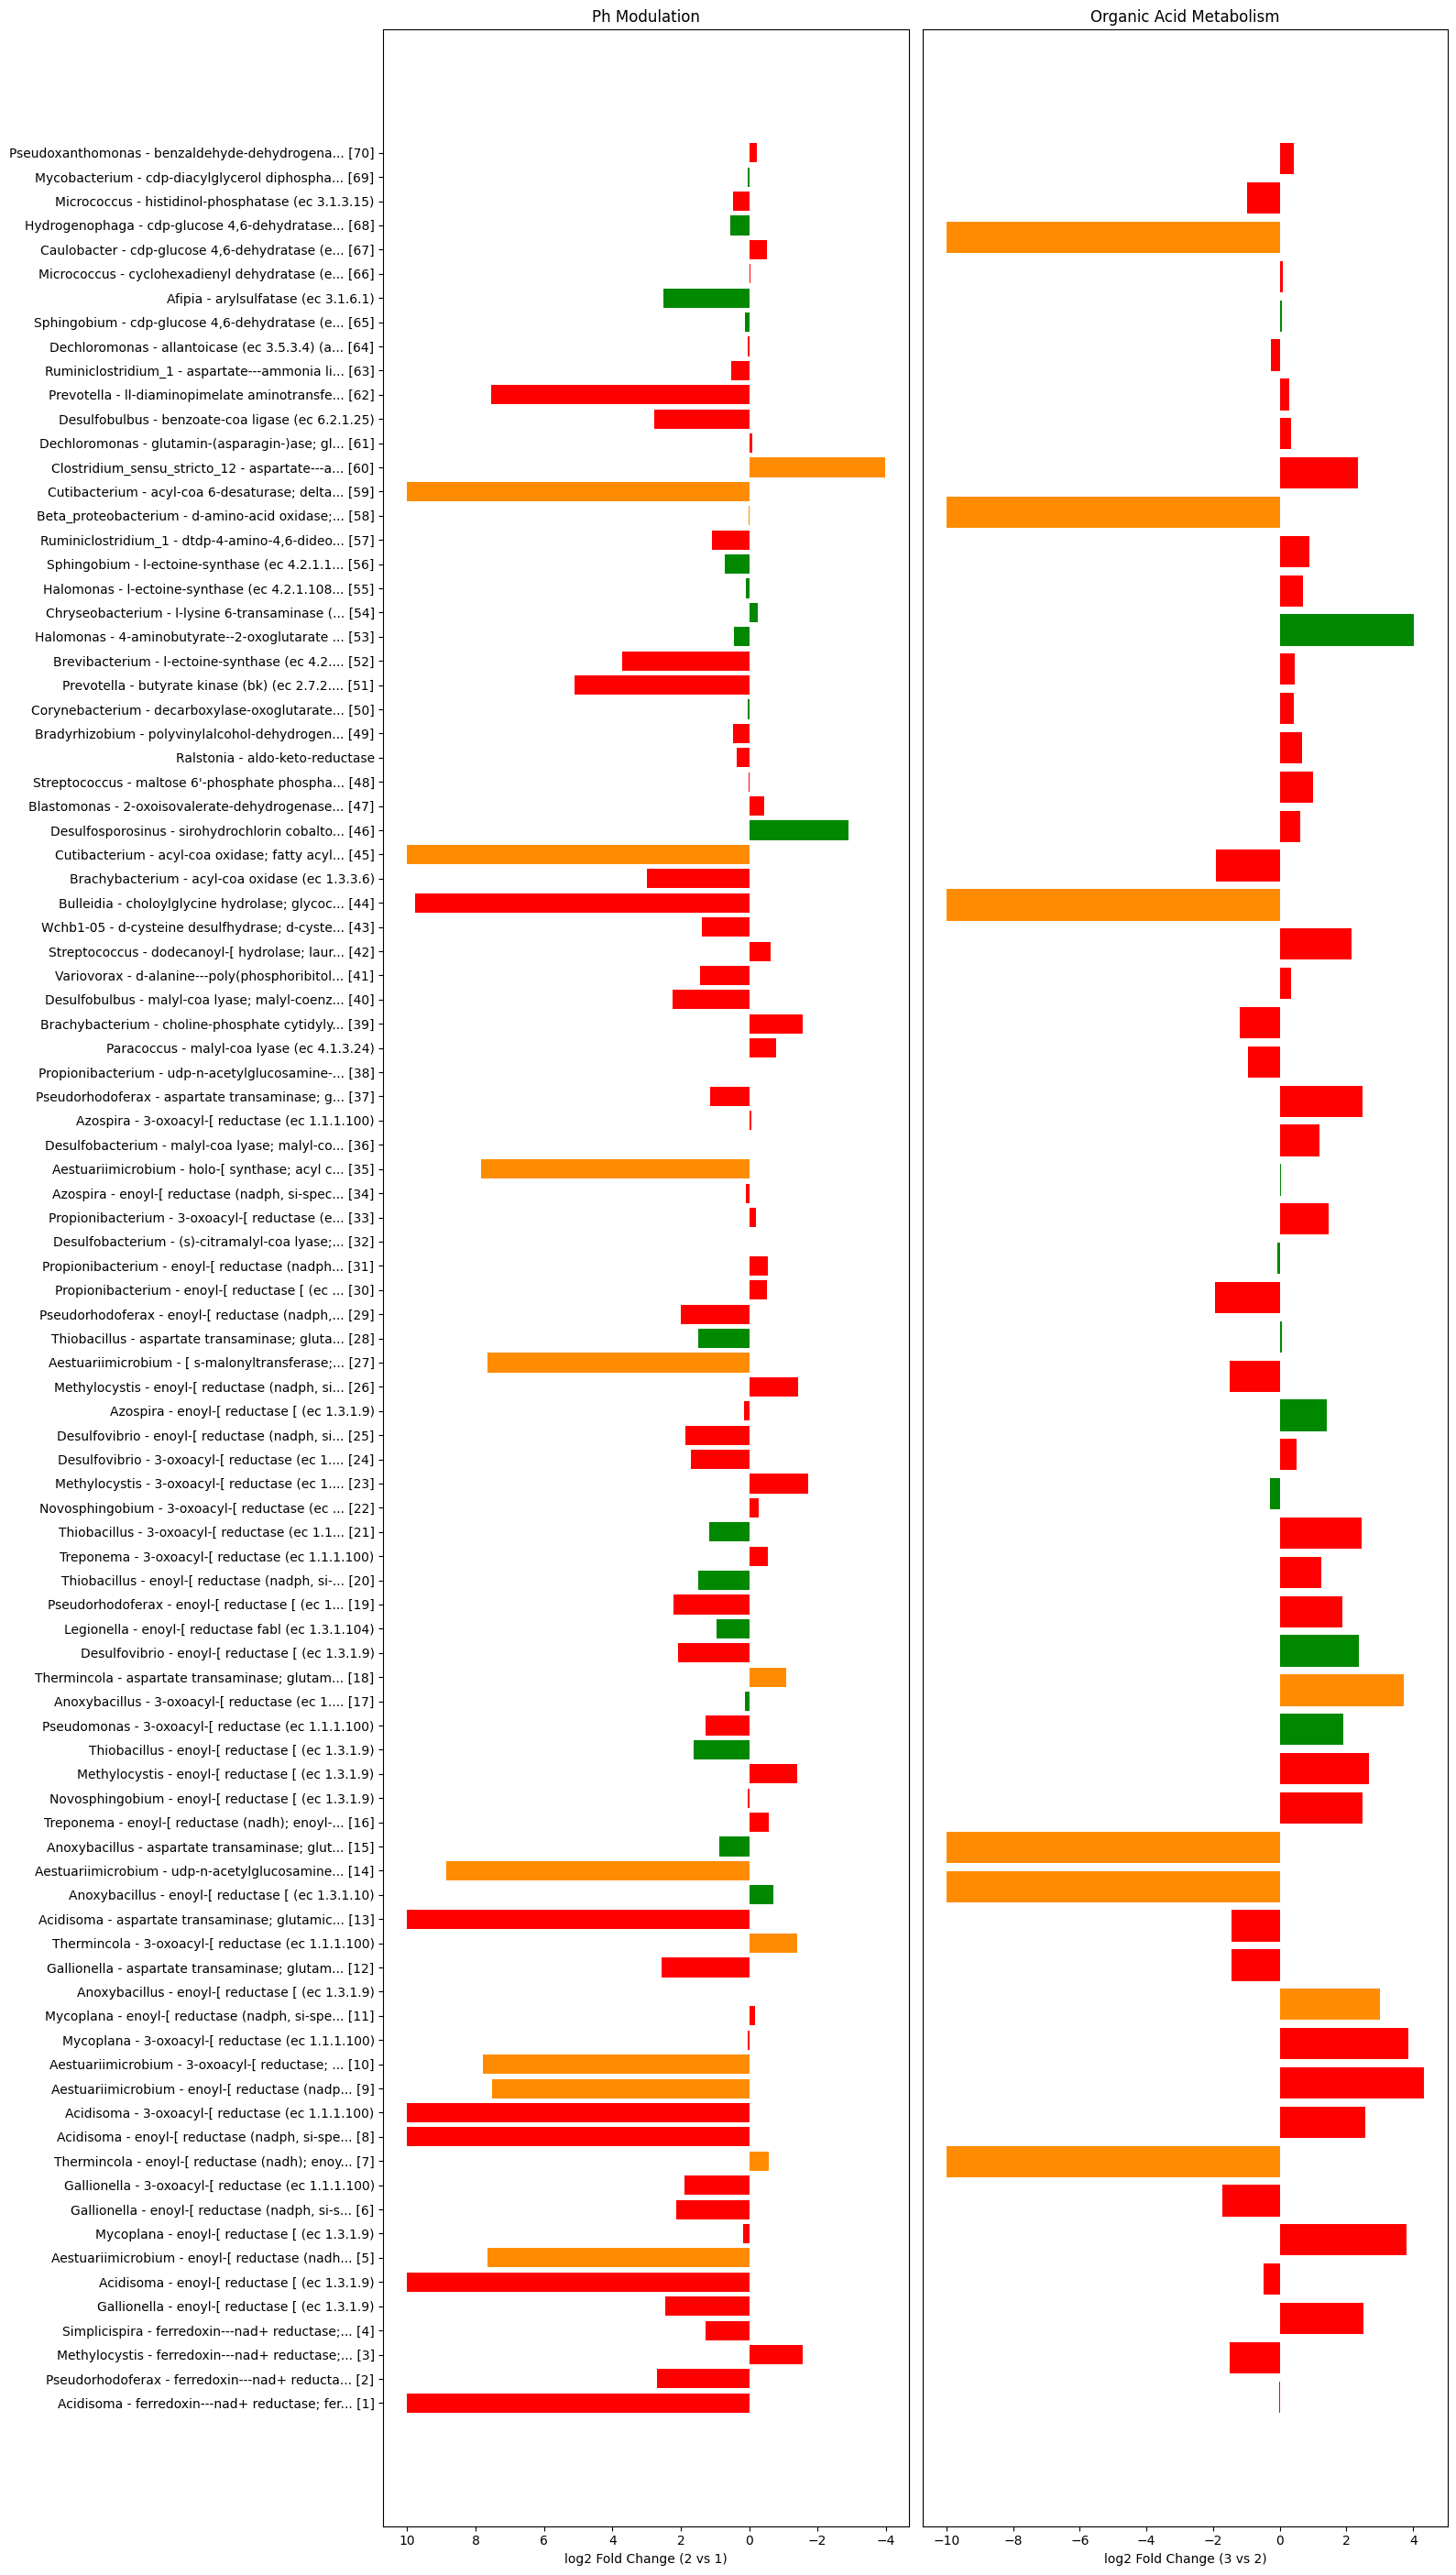

In [81]:
#'hydrogen_metabolism', oxygen_metabolism', nitrogen_metabolism',   'manganese_processes',  'iron_sulfur_redox', 'ocre_formation',  'sulfur_metabolism',  
# 'electron_transfer',    'organic_acid_metabolism',  'metal_organic_interaction', 'biofilm_formation',  'carbon_metabolism', 'ph_modulation',     'temp_response',  
#   'halogen_related',    'methanogenesis'}
plot_mirrored_pathway_comparison(mechanism_all, cs.pathway_categories, cat1='ph_modulation', cat2= 'organic_acid_metabolism') 
output_path = shared_dir /"34_mirror.png"
fig.write_image(output_path, scale=3)

## 5.5. Functional Pathway Clustering Analysis
Hierarchical Clustering was done to groups pathways based on their abundance patterns creates a dendrogram to visualize relationships, however that clustering approach was no insightful and give very umbalanced clusters. So the following function analyses proteins better than genera since ultimately are the limiting factor on the microbial ecology suscess. 

/tmp/ipykernel_6066/2253161376.py:131: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




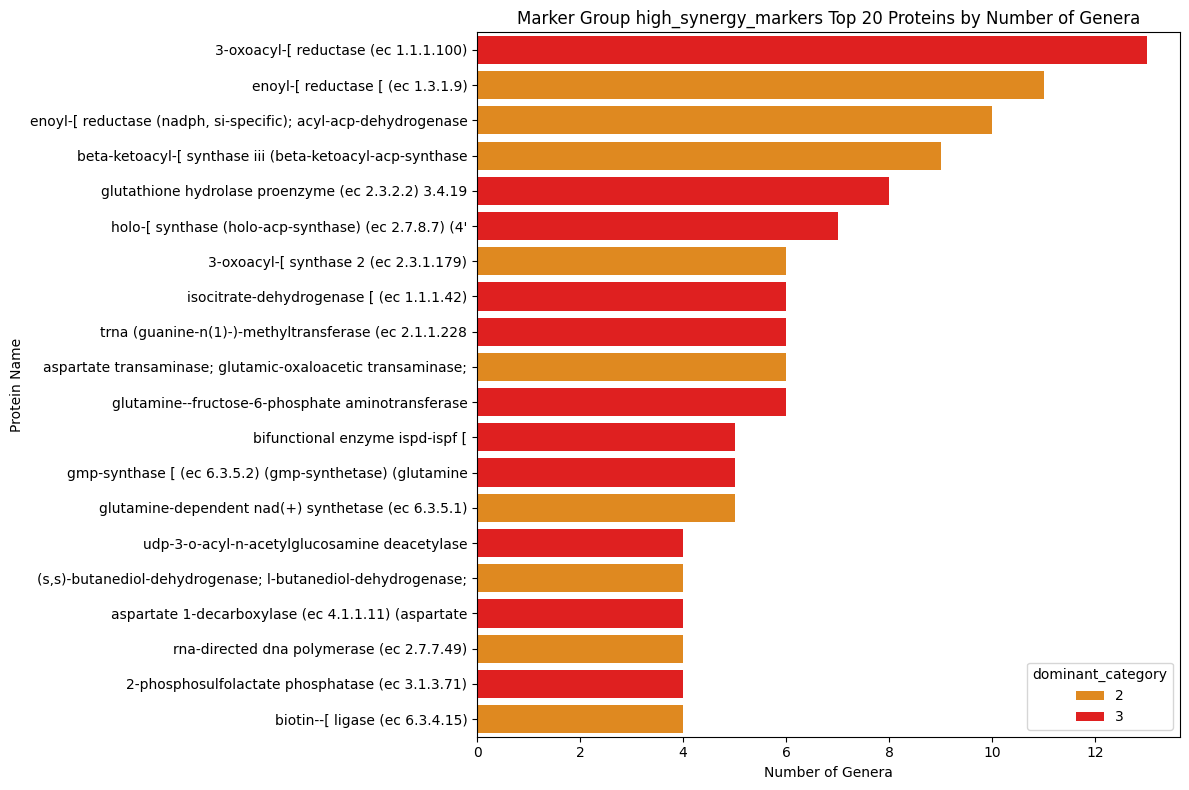

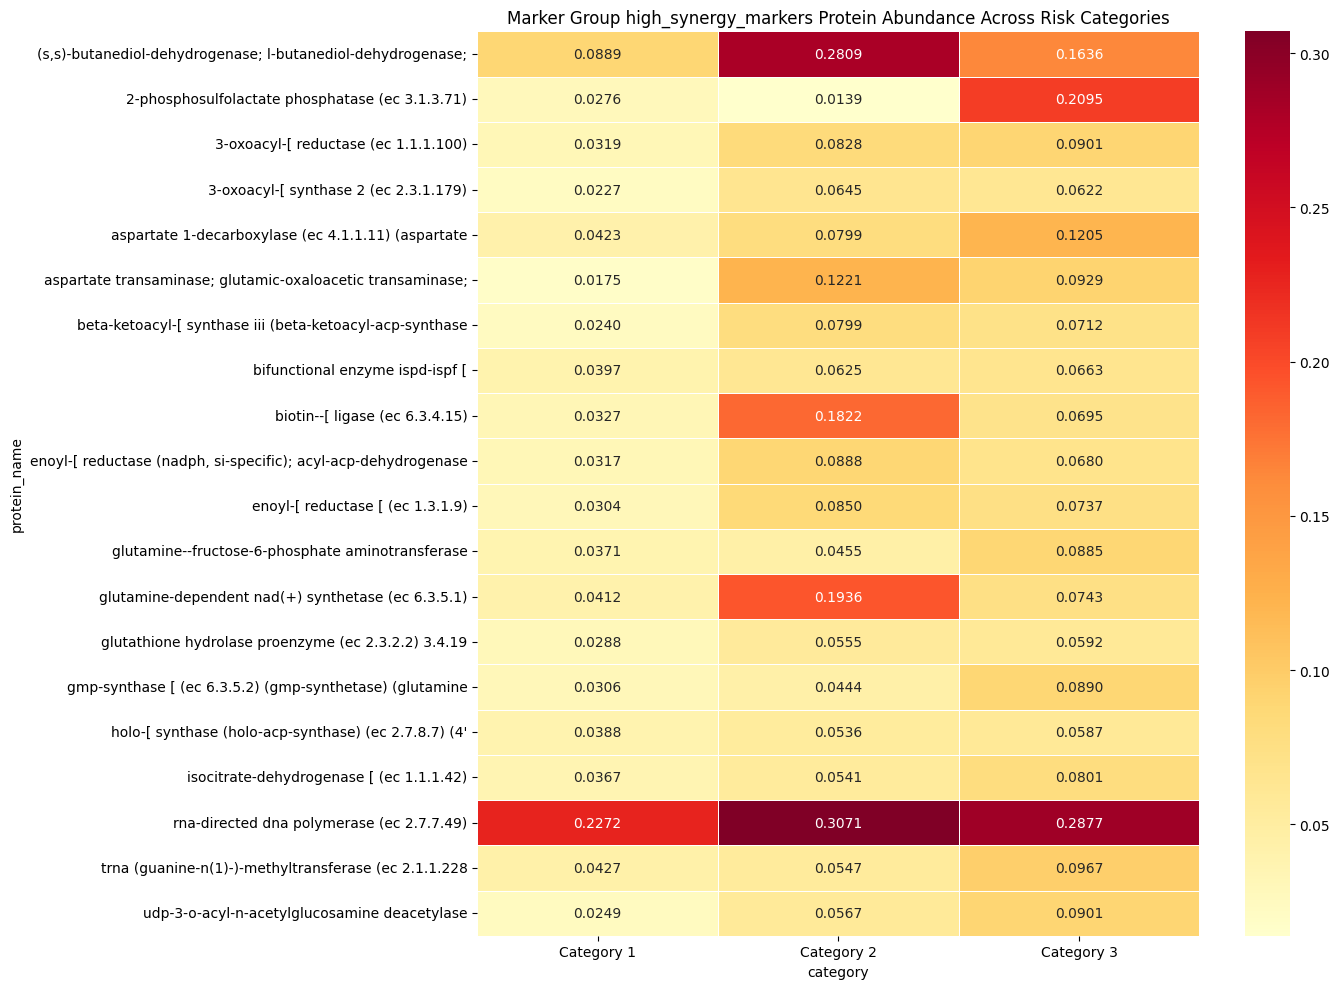

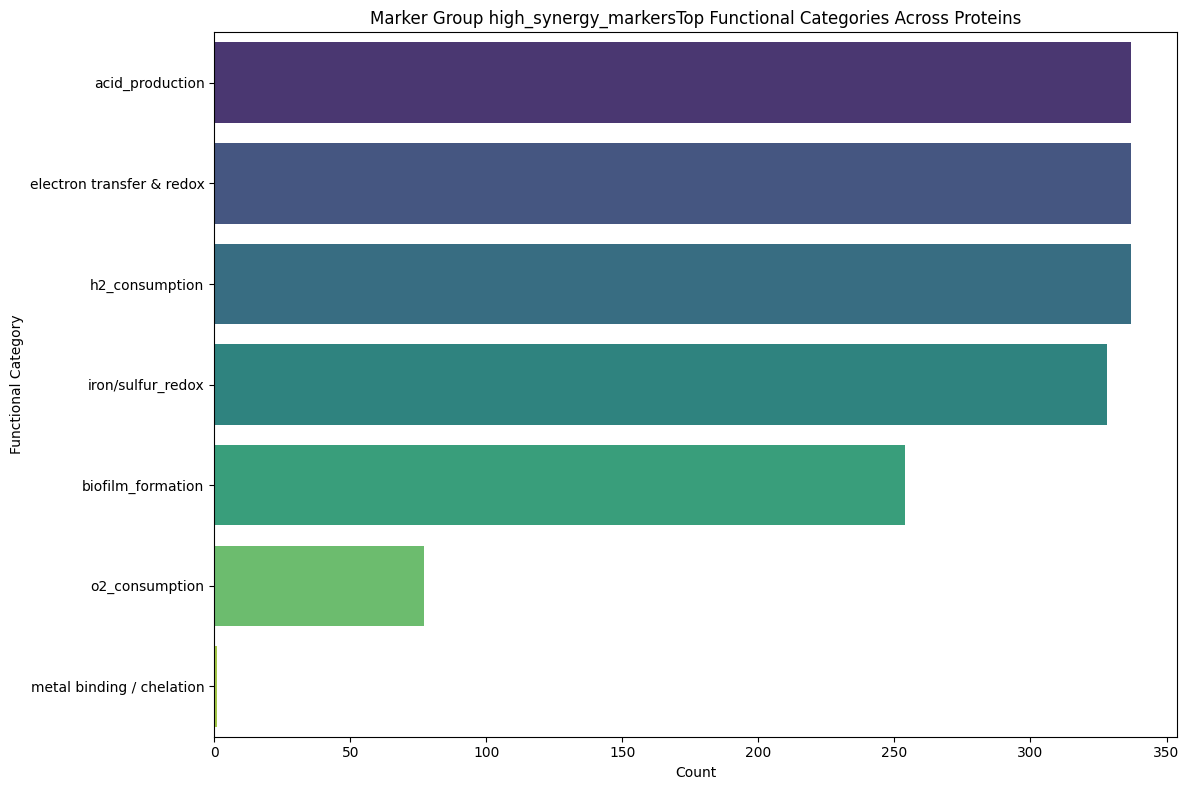

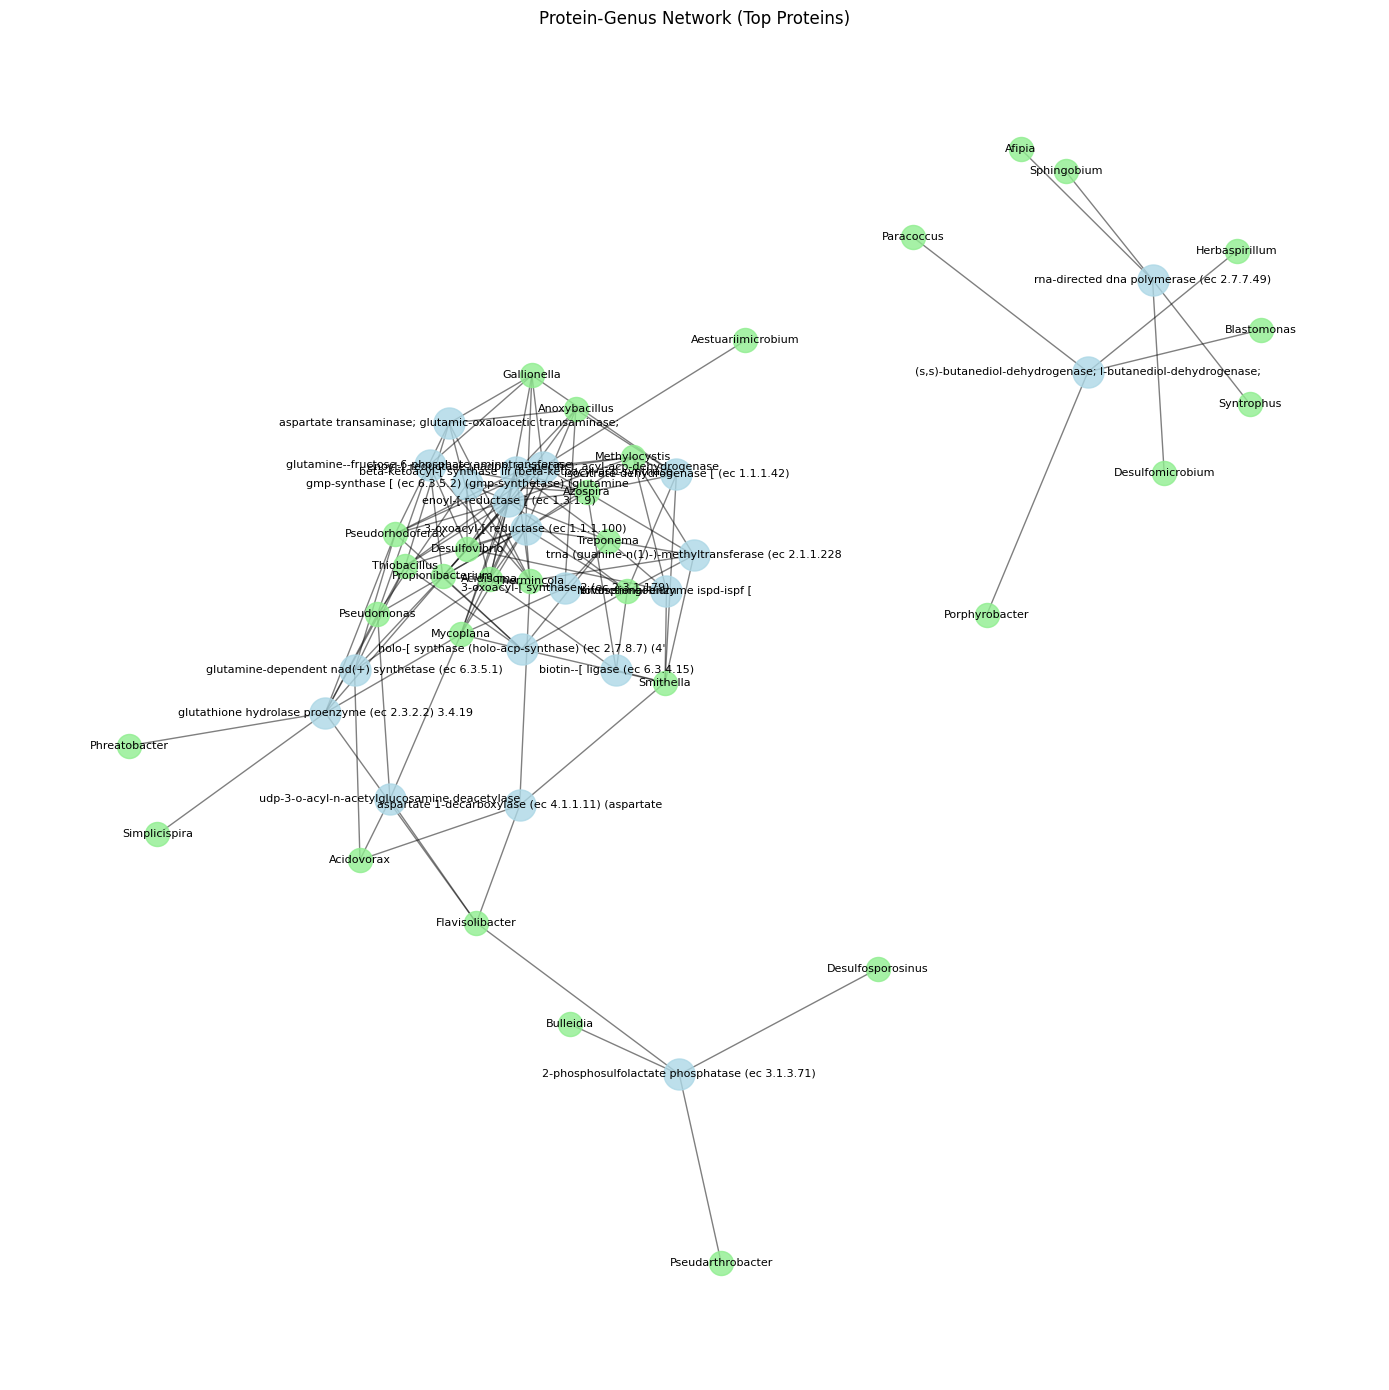

In [82]:
def analyze_key_proteins_across_genera(df, name, top_n =None):
    """
    Analyze key proteins across genera based on functional categories and expression patterns
        Parameters:df (pandas.DataFrame): DataFrame with protein-genus data
        Returns: tuple: Analysis results and visualizations
    """    
    # Get unique protein names
    unique_proteins = df['protein_name'].dropna().unique()
    # Create a summary dataframe for proteins
    protein_summary = []
    
    for protein in unique_proteins:
        # Filter rows for this protein
        protein_rows = df[df['protein_name'] == protein]
        
        # Skip if no rows
        if len(protein_rows) == 0:
            continue
        
        # Count genera
        genera_count = protein_rows['Genus'].nunique()
        genera_list = protein_rows['Genus'].unique().tolist()
        
        # Calculate average scores across risk categories
        avg_cat1 = protein_rows['mean_cat1'].mean()
        avg_cat2 = protein_rows['mean_cat2'].mean()
        avg_cat3 = protein_rows['mean_cat3'].mean()
        
        # Determine dominant category
        dominant_category = np.argmax([avg_cat1, avg_cat2, avg_cat3]) + 1
        
        # Calculate average fold changes
        avg_fold_3vs1 = protein_rows['fold_change_3vs1'].mean()
        
        # Get functional categories if available
        functional_cats = []
        if 'functional_categories_present' in protein_rows.columns:
            # Collect all functional categories
            all_cats = []
            for fc_str in protein_rows['functional_categories_present'].dropna():
                all_cats.extend([cat.strip() for cat in fc_str.split(';')])
            
            # Count occurrences
            from collections import Counter
            cat_counts = Counter(all_cats)
            functional_cats = [(cat, count) for cat, count in cat_counts.most_common() if cat]
        
        # Get enzyme class if available
        enzyme_class = protein_rows['enzyme_class'].iloc[0] if 'enzyme_class' in protein_rows.columns else None
        
        # Store summary
        protein_summary.append({
            'protein_name': protein,
            'genera_count': genera_count,
            'genera_list': genera_list,
            'avg_cat1': avg_cat1,
            'avg_cat2': avg_cat2,
            'avg_cat3': avg_cat3,
            'dominant_category': dominant_category,
            'avg_fold_3vs1': avg_fold_3vs1,
            'functional_categories': functional_cats,
            'enzyme_class': enzyme_class
        })
    
    # Convert to dataframe
    protein_df = pd.DataFrame(protein_summary)
    
    # Sort by number of genera (most common proteins first)
    protein_df = protein_df.sort_values('genera_count', ascending=False)
    
    # Create visualizations
    
    # 1. Top proteins by genera count
    plt.figure(figsize=(12, 8))
    top_n = min(20, len(protein_df))
    top_proteins = protein_df.head(top_n)
    
    sns.barplot(
        x='genera_count', 
        y='protein_name', 
        hue= 'dominant_category',
        palette= category_colors ,#'viridis',
        data=top_proteins
    )
    plt.title(f"Marker Group {name} Top {top_n} Proteins by Number of Genera")
    plt.xlabel('Number of Genera')
    plt.ylabel('Protein Name')
    plt.tight_layout()
    
    # 2. Protein abundance across risk categories
    plt.figure(figsize=(14, 10))
    
    # Prepare data for plotting
    plot_data = []
    for _, row in top_proteins.iterrows():
        for cat in [1, 2, 3]:
            plot_data.append({
                'protein_name': row['protein_name'],
                'category': f'Category {cat}',
                'abundance': row[f'avg_cat{cat}']
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create heatmap
    pivot_df = plot_df.pivot(index='protein_name', columns='category', values='abundance')
    sns.heatmap(
        pivot_df, 
        cmap='YlOrRd', 
        annot=True, 
        fmt='.4f', 
        linewidths=0.5
    )
    plt.title(f"Marker Group {name} Protein Abundance Across Risk Categories")
    plt.tight_layout()
    
    # 3. Functional category distribution
    if 'functional_categories' in protein_df.columns and protein_df['functional_categories'].any():
        plt.figure(figsize=(12, 8))
        
        # Count functional categories
        all_cats = []
        for cats in protein_df['functional_categories']:
            if cats:
                all_cats.extend([cat for cat, _ in cats])
        
        cat_counts = Counter(all_cats)
        cat_df = pd.DataFrame(list(cat_counts.items()), columns=['Category', 'Count'])
        cat_df = cat_df.sort_values('Count', ascending=False)
        
        sns.barplot(
            x='Count', 
            y='Category', 
            palette='viridis',
            data=cat_df.head(15)  # Top 15 categories
        )
        plt.title(f"Marker Group {name}Top Functional Categories Across Proteins")
        plt.xlabel('Count')
        plt.ylabel('Functional Category')
        plt.tight_layout()
    
    # 4. Network visualization of protein-genus relationships
    try:
        import networkx as nx
        
        plt.figure(figsize=(14, 14))
        
        # Create network
        G = nx.Graph()
        
        # Add protein nodes
        for protein in top_proteins['protein_name']:
            G.add_node(protein, node_type='protein')
        
        # Add genus nodes and edges
        all_genera = set()
        for _, row in top_proteins.iterrows():
            for genus in row['genera_list']:
                all_genera.add(genus)
                G.add_node(genus, node_type='genus')
                G.add_edge(row['protein_name'], genus)
        
        # Position nodes using spring layout
        pos = nx.spring_layout(G, k=0.3, iterations=50)
        
        # Draw protein nodes
        protein_nodes = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') == 'protein']
        nx.draw_networkx_nodes(
            G, pos, 
            nodelist=protein_nodes,
            node_color='lightblue',
            node_size=500,
            alpha=0.8
        )
        
        # Draw genus nodes
        genus_nodes = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') == 'genus']
        nx.draw_networkx_nodes(
            G, pos, 
            nodelist=genus_nodes,
            node_color='lightgreen',
            node_size=300,
            alpha=0.8
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            G, pos, 
            width=1.0, 
            alpha=0.5
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            G, pos, 
            font_size=8, 
            font_family='sans-serif'
        )
        
        plt.title('Protein-Genus Network (Top Proteins)')
        plt.axis('off')
        plt.tight_layout()
    except ImportError:
        print("NetworkX not available for network visualization")
    
    return protein_df, plt.gcf()
network_protein = analyze_key_proteins_across_genera(high_synergy_markers, "high_synergy_markers", top_n= 30)
output_path = shared_dir /"33_network_protein.png"
fig.write_image(output_path, scale=3)

# 6. Metal Involvement by Genus across Risk Categories
The plot_metal_involvement function creates a heatmap showing the relationship between bacterial genera and the specific metals they interact with, weighted by the combined score from prioritized markers.

In [83]:
def plot_metal_involvement(prioritized_markers):
    """
    Creates a heatmap showing metal involvement by genus across risk categories,
    using the actual metal names from the data.
    """
    # Build lookup for metal categories
    metal_terms = {k: v for k, v in cs.metal_terms.items()}
    
    def match_metals(row, terms):
        return any(term.lower() in str(row['metal_consolidated']).lower() for term in terms)
    #=============================================
    # Process metal involvement data
    metal_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['metals_consolidated '], str) and row['metals_consolidated']:
            # Use the correct delimiter based on the data format (comma or semicolon)
            metals = [m.strip() for m in row['metals_consolidated'].split(';')]
            for metal in cs.metal_terms:
                metal_data.append({
                    'Genus': row['Genus'],
                    'metal': metal,  # Keep the original metal name
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3'],
                    'combined_score': row['combined_score']
                })

    # Convert to DataFrame
    metal_df = pd.DataFrame(metal_data)

    # Group by genus and metal
    grouped = metal_df.groupby(['Genus', 'metal']).agg({
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean',
        'combined_score': 'mean'
    }).reset_index()

    # Create a pivot table for the heatmap
    pivot = grouped.pivot_table(
        index='Genus',
        columns='metal',
        values='combined_score',
        aggfunc='mean'
    ).fillna(0)

    # Sort by sum of values
    pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    pivot = pivot[pivot.sum().sort_values(ascending=False).index]

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Create heatmap - using a mask for zero values to make them white
    mask = pivot == 0
    sns.heatmap(
        pivot,
        cmap='YlOrRd',
        linewidths=0.5,
        cbar_kws={'label': 'Combined Score'},
        mask=mask
    )

    plt.title('Metal Involvement by Genus', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    # Print a simple dictionary of the metals for reference
    #metal_list = sorted(metal_df['metal'].unique())

    return plt.gcf()
#plot_metal_involvement(high_mechanism_relevance)
#plt.tight_layout()

# 7 Functional Category groups and Random Forest importance
Using functional Category groups and Random Forest importance to select top markers.This rf integrates the functional categories from the cs package, uses Random Forest to identify the most important features for predicting corrosion risk and groups them by functional category to understand which biological processes are most informative, but also an additional step will communicate the niche specific processes. Then uses SHAP values for more interpretable feature importance. At end a selected balanced set of features representing different functional categories
is chosen mapping the features back to specific proteins for biological interpretation

In [84]:
def analyze_protein_hierarchy(df, top_n=20):
    """
    Analyze proteins by functional hierarchy (proteins → functional categories → niche pathways)
    
    Parameters:
    df (pandas.DataFrame): DataFrame with protein-genus data
    
    Returns:
    dict: Hierarchical analysis results
    """   
    # Check if dataframe is empty
    if df.empty:
        print("Warning: DataFrame is empty")
        return {"error": "DataFrame is empty"}
    
    # Get proteins with highest combined score if available
    if 'combined_score' in df.columns:
        top_by_score = df.sort_values('combined_score', ascending=False)['protein_name'].unique()[:20]
    else:
        # Use fold change if no combined score
        if 'fold_change_3vs1' in df.columns:
            top_by_score = df.sort_values('fold_change_3vs1', ascending=False)['protein_name'].unique()[:20]
        else:
            top_by_score = []
    
    # Get proteins that appear in multiple genera
    protein_genera = df.groupby('protein_name')['Genus'].nunique()
    top_by_genera = protein_genera.sort_values(ascending=False).head(top_n).index.tolist()
    
    # Combine both lists and remove duplicates
    top_proteins = list(dict.fromkeys(top_by_genera + list(top_by_score)))[:top_n]
    
    print(f"Found {len(top_proteins)} top proteins for analysis")
    
    # Build hierarchical structure
    hierarchy = []
    for protein in top_proteins:
        protein_rows = df[df['protein_name'] == protein]
        
        # Skip if no rows
        if len(protein_rows) == 0:
            continue
            
        # Get genera for this protein
        genera = protein_rows['Genus'].unique().tolist()
        
        # Get functional categories
        func_categories = []
        if 'functional_categories_present' in protein_rows.columns:
            for cats in protein_rows['functional_categories_present'].dropna():
                func_categories.extend([c.strip() for c in cats.split(';') if c.strip()])
            func_categories = list(set(func_categories))  # Remove duplicates
        
        # Get niche pathways
        niche_pathways = []
        if 'niche_specific_pathways' in protein_rows.columns:
            for paths in protein_rows['niche_specific_pathways'].dropna():
                if isinstance(paths, str):
                    niche_pathways.extend([p.strip() for p in paths.split(';') if p.strip()])
            niche_pathways = list(set(niche_pathways))  # Remove duplicates
        # Get enzyme class
        enzyme_class = None
        if 'enzyme_class' in protein_rows.columns:
            enzyme_class = protein_rows['enzyme_class'].iloc[0] if not protein_rows['enzyme_class'].isna().all() else None
        
        # Get mechanisms
        corrosion_mechanisms = []
        if 'corrosion_mechanisms' in protein_rows.columns:
            for mech in protein_rows['corrosion_mechanisms'].dropna():
                if isinstance(mech, str):
                    corrosion_mechanisms.extend([m.strip() for m in mech.split(';') if m.strip()])
            corrosion_mechanisms= list(set(corrosion_mechanisms))  # Remove duplicates
        
        # Get scores
        scores = {}
        score_cols = [col for col in protein_rows.columns if 'score' in col.lower() and 
                    protein_rows[col].dtype in [float, int]]
        
        for col in score_cols:
            scores[col] = protein_rows[col].mean()
        
        # Add to hierarchy
        hierarchy.append({
            'protein_name': protein,
            'genera_count': len(genera),
            'genera': genera,
            'functional_categories': func_categories,
            'niche_pathways': niche_pathways,
            'enzyme_class': enzyme_class,
            'corrosion_mechanisms': corrosion_mechanisms,
            'scores': scores
        })
    
    print(f"Built hierarchical structure for {len(hierarchy)} proteins")
    
    # Group by functional categories
    func_category_analysis = {}
    
    for entry in hierarchy:
        for category in entry['functional_categories']:
            if category not in func_category_analysis:
                func_category_analysis[category] = {
                    'proteins': [],
                    'genera': set(),
                    'niche_pathways': set()
                }
            
            func_category_analysis[category]['proteins'].append(entry['protein_name'])
            func_category_analysis[category]['genera'].update(entry['genera'])
            func_category_analysis[category]['niche_pathways'].update(entry['niche_pathways'])
    
    # Convert sets to lists
    for category in func_category_analysis:
        func_category_analysis[category]['genera'] = list(func_category_analysis[category]['genera'])
        func_category_analysis[category]['niche_pathways'] = list(func_category_analysis[category]['niche_pathways'])
    
    print(f"Analyzed {len(func_category_analysis)} functional categories")
    
    # Group by niche pathway
    pathway_analysis = {}
    
    for entry in hierarchy:
        for pathway in entry['niche_pathways']:
            if pathway not in pathway_analysis:
                pathway_analysis[pathway] = {
                    'proteins': [],
                    'genera': set(),
                    'functional_categories': set(),
                    'enzyme_classes': set(),
                   'corrosion_mechanisms': set()
            }
            
            pathway_analysis[pathway]['proteins'].append(entry['protein_name'])
            pathway_analysis[pathway]['genera'].update(entry['genera'])
            pathway_analysis[pathway]['functional_categories'].update(entry['functional_categories'])
            if entry['enzyme_class']:
                pathway_analysis[pathway]['enzyme_classes'].add(entry['enzyme_class'])
                pathway_analysis[pathway]['corrosion_mechanisms'].update(entry['corrosion_mechanisms'])
    # Convert sets to lists
    for pathway in pathway_analysis:
        pathway_analysis[pathway]['genera'] = list(pathway_analysis[pathway]['genera'])
        pathway_analysis[pathway]['functional_categories'] = list(pathway_analysis[pathway]['functional_categories'])
    
    print(f"Analyzed {len(pathway_analysis)} niche pathways")
    
    '''# Create visualizations
    try:
        # Protein by genera count
        plt.figure(figsize=(12, 8))
        proteins_for_plot = [p['protein_name'][:20] for p in hierarchy]
        genera_counts = [p['genera_count'] for p in hierarchy]
        
        plt.barh(proteins_for_plot, genera_counts)
        plt.xlabel('Number of Genera')
        plt.ylabel('Protein')
        plt.title('Top Proteins by Number of Genera')
        plt.tight_layout()
        
        # Category analysis
        if func_category_analysis:
            plt.figure(figsize=(12, 8))
            categories = list(func_category_analysis.keys())
            protein_counts = [len(func_category_analysis[c]['proteins']) for c in categories]
            
            plt.barh(categories, protein_counts)
            plt.xlabel('Number of Proteins')
            plt.ylabel('Functional Category')
            plt.title('Protein Distribution by Functional Category')
            plt.tight_layout()
    except Exception as e:
        print(f"Warning: Could not create visualizations: {str(e)}")'''
    # Add to hierarchy
    hierarchy.append({
        'protein_name': protein,
        'genera_count': len(genera),
        'genera': genera,
        'functional_categories': func_categories,
        'niche_pathways': niche_pathways,
        'enzyme_class': enzyme_class,
        'corrosion_mechanisms': corrosion_mechanisms,
        'scores': scores
    })
    # Create DataFrame from hierarchy for easier analysis
    hierarchy_df = pd.DataFrame([{
            'protein_name': item['protein_name'],
            'genera_count': item['genera_count'],
            'genera': item['genera'], 
            'functional_categories': item['functional_categories'],
            'niche_pathways': item['niche_pathways'],
            'enzyme_class': item['enzyme_class'],
            'corrosion_mechanisms': item['corrosion_mechanisms'],
            **{f"score_{k.replace('score', '').strip('_')}": v for k, v in item['scores'].items()}
        }for item in hierarchy
    ])

    # Sort by genera count (descending)
    hierarchy_df = hierarchy_df.sort_values('genera_count', ascending=False)

    # Add to the return dictionary
    return {
        'protein_hierarchy': hierarchy,
        'functional_category_analysis': func_category_analysis,
        'niche_pathway_analysis': pathway_analysis,
        'protein_dataframe': hierarchy_df  
    }
#==============================
df_proteins = pd.concat([corrosion_critical, significant_markers,high_prevalence,
                        high_synergy_markers,  high_biological_relevance, high_corrosion_relevance])
df_proteins.drop_duplicates(subset=["protein_name", "Genus"], inplace=True)

results= analyze_protein_hierarchy(df_proteins, top_n=100)
# 
# # Print top proteins
for protein in results['protein_hierarchy']:
     print(f"{protein['protein_name']} - Found in {protein['genera_count']} genera")
     #need genera name list per protein name
     print(print(f"  Genera: {', '.join(protein['genera'])}"))
     print(f"  Functional categories: {', '.join(protein['functional_categories'][:3])}")
     if protein['niche_pathways']:
        print(f"  Niche pathways: {', '.join(protein['niche_pathways'][:3])}")
        print()
# # Print top functional categories
print("\nTop Functional Categories:")
for category, data in sorted(results['functional_category_analysis'].items(), 
                              key=lambda x: len(x[1]['proteins']), reverse=True)[:5]:
     print(f"{category}: {len(data['proteins'])} proteins, {len(data['genera'])} genera")

Found 100 top proteins for analysis
Built hierarchical structure for 100 proteins
Analyzed 7 functional categories
Analyzed 73 niche pathways
3-oxoacyl-[ reductase (ec 1.1.1.100) - Found in 13 genera
  Genera: Gallionella, Acidisoma, Mycoplana, Thermincola, Pseudomonas, Anoxybacillus, Treponema, Thiobacillus, Novosphingobium, Methylocystis, Desulfovibrio, Propionibacterium, Azospira
None
  Functional categories: h2_consumption, iron/sulfur_redox, acid_production
  Niche pathways: biotin, fatty acid biosynthesis, lipid biosynthesis proteins

enoyl-[ reductase [ (ec 1.3.1.9) - Found in 11 genera
  Genera: Gallionella, Acidisoma, Mycoplana, Anoxybacillus, Novosphingobium, Methylocystis, Thiobacillus, Desulfovibrio, Pseudorhodoferax, Azospira, Propionibacterium
None
  Functional categories: h2_consumption, iron/sulfur_redox, acid_production
  Niche pathways: lipid biosynthesis proteins, fatty acid biosynthesis

enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase - Found in 10 ge

In [85]:
protein_df = results['protein_dataframe']
protein_hierarchy = results['protein_hierarchy']
functional_analysis = results['functional_category_analysis']
niche_analysis = results['niche_pathway_analysis']

# 8. Novel Candidates
During the statistical feature analysis in Notebook 3, several bacterial genera were identified that showed strong correlations with the high-risk corrosion failure category. This led to hypothesize the potential of  of this microorganisms to be associated with corrosion processes and which were not previously documented.
In Notebook 4, we conducted a comprehensive literature review using academic databases to investigate the bacterial genera. The findings confirmed that these microorganisms have no prior documentation in scientific literature linking them to corrosion-related processes.
Now, we aim to deploy the analyze_protein_hierarchy function to examine whether these bacteria express proteins that are known to induce or accelerate corrosion. This analysis will help determine if these genera possess the molecular machinery to contribute to corrosion despite their absence from corrosion-related literature, potentially identifying novel microbial contributors to corrosion processes that have been overlooked in previous research.

In [86]:
# Creating a dictionary of genera identified as nobel on Notebook 4.
new_genera= ['Oxalobacteraceae_unclassified', 'Oxobacter', 'Mycoplana', 'Bulleidia',  'Oerskovia']
new_genera_df = classified_results[classified_results["Genus"].isin(new_genera)]
results_new_candid= analyze_protein_hierarchy(new_genera_df , top_n=5)
protein_candid = results_new_candid['protein_dataframe']

Found 5 top proteins for analysis
Built hierarchical structure for 5 proteins
Analyzed 0 functional categories
Analyzed 3 niche pathways


### File Integration of Microbiological Data and Physicochemical Data

In [87]:
data_physicochemical = Path("/home/beatriz/MIC/1_Physicochemical/Data/")
physichem_path = data_physicochemical /"Physicochemical.xlsx"

In [88]:
all_physicochemical = pd.read_excel(physichem_path, sheet_name='all_physicochemical', engine ='openpyxl')
metadata = pd.read_excel(physichem_path, sheet_name='Metadata', engine ='openpyxl')

In [89]:

physichem_features = ['Temperature', 'Type', 'EC_M', 'O2_Eh',
                     'Ox_Fe_Zn', 'Cl_SO4_NO3', 'Na_K','pH_HPO4',
                       'Ca_HCO3_Mg', 'Cu_Al_Mn', 'Ni_Cr_Mo']
physichem_df = all_physicochemical[physichem_features]

In [91]:
# Creating a dictionary of the protein that were found top on the identified genera to see if these bacteria
# also express that ones.
top_protein= ['3-oxoacyl', 'enoyl', 'beta-ketoacyl', 'glutathione', 'holo', 'aspartate', 'trna (guanine',
              'metal-dependent', 'ferredoxin', 'siroheme-synthase']

# Creating a condition that checks if protein_name starts with any of the strings on top protein
starts_with_condition = new_genera_df["protein_name"].str.lower().apply(
    lambda x: any(x.startswith(tp.lower())for tp in top_protein))
#Apply condition to filter the df
top_protein_in_new = new_genera_df[starts_with_condition]

In [92]:
top_protein_in_new["protein_name"].unique()

array(['3-oxoacyl-[ reductase; beta-ketoacyl-[(acp) reductase;',
       'glutathione peroxidase; gsh peroxidase; selenium-glutathione',
       'ferredoxin---nadp+ reductase; ferredoxin-nicotinamide',
       'aspartate-semialdehyde-dehydrogenase; aspartate semialdehyde',
       'enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase',
       'enoyl-[ reductase (nadh); enoyl-[ reductase; enoyl',
       'glutathione-disulfide-reductase; glutathione-reductase;',
       'trna (guanine37-n1)-methyltransferase; trmd; trna',
       'trna (guanine46-n7)-methyltransferase; trm8-trm82;',
       'aspartate carbamoyltransferase; carbamylaspartotranskinase;',
       'beta-ketoacyl-[ synthase ii; kasii; kas ii; fabf; 3',
       'beta-ketoacyl-[ synthase iii; 3-oxoacyl:acp-synthase',
       'beta-ketoacyl-[ synthase i; beta-ketoacyl-acp-synthase',
       'glutathione transferase; glutathione s-transferase;',
       'aspartate kinase; aspartokinase; ak; beta-aspartokinase;',
       'holo-[ synt

# 9. Proteins Associated with Corrosion from the Literature
In this section a querry to the group balanced markers is done with the aim to find the following proteins which have been associated with corrosion in the literature
all_physiche balanced_markers

In [93]:
# Define search terms for each protein group - using partial matches rather than just startswith
protein_search_terms = {
    'hydrogenase': ['hydrogenase', '[nife]', '[fefe]', 'fe-only hydrogenase', 'ni-fe hydrogenase'],
    'cytochrome': ['cytochrome c', 'c-type cytochrome', 'cytc'],
    'sulfite_reductase': ['dissimilatory sulfite reductase', 'dsrab', 'dsr', 'sulfite reductase'],
    'metal_resistance': ['cobalt-zinc-cadmium resistance', 'czca', 'metal efflux', 'metal resistance'],
    'quorum_sensing': ['ahl synthase', 'luxi', 'luxr', 'autoinducer synthase', 'quorum sensing'],
    'eps_production': ['glycosyltransferase', 'eps synthase', 'exopolysaccharide']
}

# Function to check if protein name contains any of the search terms
def matches_protein_group(protein_name, search_terms):
    protein_name_lower = protein_name.lower()
    return any(term.lower() in protein_name_lower for term in search_terms)

# Create dictionaries to store results
found_proteins = {category: [] for category in protein_search_terms}

# Search for proteins in each category
for category, terms in protein_search_terms.items():
    # Create condition that checks if protein_name contains any of the search terms
    match_condition = balanced_markers["protein_name"].apply(
        lambda x: matches_protein_group(x, terms)
    )
    
    # Filter the DataFrame
    matched_proteins = balanced_markers[match_condition]
    
    # Store results
    found_proteins[category] = matched_proteins
    for protein_name in matched_proteins["protein_name"].unique():
        # Get the genera for this protein
        protein_rows = matched_proteins[matched_proteins['protein_name'] == protein_name]
        genera_value = protein_rows['Genus'].iloc[0]
        
        # Check if the genera is already a list or a string representation of a list
        if isinstance(genera_value, list):
            genera_list = genera_value
        else:
            # Try to evaluate as a Python list if it's a string representation
            import ast
            try:
                genera_list = ast.literal_eval(genera_value)
            except:
                # If it's just a single string, wrap it in a list
                genera_list = [genera_value]
        
        # Print the protein name and joined genera
        print(f"{protein_name}: {', '.join(genera_list)}")

(r,r)-butanediol-dehydrogenase-meso-butanediol-dehydrogenase: Pseudarthrobacter
enoyl-[ reductase (nadph, si-specific); acyl-acp-dehydrogenase: Gallionella
isocitrate-dehydrogenase [ (ec 1.1.1.42): Gallionella
2-iminoacetate-synthase (ec 4.1.99.19) ([ hydrogenase: Clostridium
(r,r)-butanediol-dehydrogenase; butyleneglycol-dehydrogenase;: Paracoccus
saccharopine-dehydrogenase (nad+, l-lysine-forming: Desulfobulbus
(s,s)-butanediol-dehydrogenase; l-butanediol-dehydrogenase;: Porphyrobacter
meso-butanediol-dehydrogenase-(s,s)-butanediol-dehydrogenase: Variovorax
cytochrome-c3 hydrogenase; h2:ferricytochrome c3 oxido: Desulfobacterium
glycerol-3-phosphate-dehydrogenase (ec 1.1.5.3): Phreatobacter
nadph-dehydrogenase (ec 1.6.99.1): Bacillus
ferredoxin hydrogenase; h2 oxidizing hydrogenase; h2: Hydrogenophaga
2-oxoisovalerate-dehydrogenase subunit alpha (ec 1: Blastomonas
polyvinylalcohol-dehydrogenase (ec 1.1.2.6): Bradyrhizobium
decarboxylase-oxoglutarate-dehydrogenase thiamine pyrophospha

### Mapping back Genus to Sites for integration

In [103]:
Integrated_T.head()

Category Rhodocyclales_Rhodocyclaceae_Azospira  \
                                             Bacteria   
                                       Proteobacteria   
                                   Betaproteobacteria   
                                        Rhodocyclales   
                                       Rhodocyclaceae   
                                             Azospira   
                                                  110   
Sites                                                   
site_1        3                             26.928048   
site_2        1                               1.85923   
site_3        1                              3.093543   
site_4        1                              2.573991   
site_5        1                              2.709369   

       Actinomycetales_Dermabacteraceae_Brachybacterium  \
                                               Bacteria   
                                         Actinobacteria   
                                         Actinobacteria   
                                        Actinomycetales   
                                       Dermabacteraceae   
                                        Brachybacterium   
                                                    140   
Sites                                                     
site_1                                                0   
site_2                                                0   
site_3                                                0   
site_4                                                0   
site_5                                                0   

       Actinomycetales_Brevibacteriaceae_Brevibacterium  \
                                               Bacteria   
                                         Actinobacteria   
                                         Actinobacteria   
                                        Actinomycetales   
                                      Brevibacteriaceae   
                                         Brevibacterium   
                                                    145   
Sites                                                     
site_1                                                0   
site_2                                                0   
site_3                                                0   
site_4                                                0   
site_5                                                0   

       Erysipelotrichales_Erysipelotrichaceae_Bulleidia  \
                                               Bacteria   
                                             Firmicutes   
                                        Erysipelotrichi   
                                     Erysipelotrichales   
                                    Erysipelotrichaceae   
                                              Bulleidia   
                                                    154   
Sites                                                     
site_1                                                0   
site_2                                                0   
site_3                                                0   
site_4                                                0   
site_5                                                0   

       Clostridiales_Clostridiaceae_Clostridium  \
                                       Bacteria   
                                     Firmicutes   
                                     Clostridia   
                                  Clostridiales   
                                 Clostridiaceae   
                                    Clostridium   
                                            214   
Sites                                             
site_1                                        0   
site_2                                        0   
site_3                                        0   
site_4                                        0   
site_5                                        0   

       Actin

In [112]:
# Create a mapping from genus to sites
genus_site_mapping = {}

# Iterate through each column
for col in Integrated_T.columns:
    # Skip the 'Category' column
    if col[0] == 'Category':
        continue
    
    # Get the genus from level 6
    genus = col[6]
    
    # Skip if genus is empty
    if genus == '':
        continue
    
    # Process each row (site) individually to safely handle non-numeric values
    sites_with_genus = []
    
    for site, value in Integrated_T[col].items():
        try:
            # Try to convert the value to float
            float_value = float(value)
            
            # If value is greater than 0, add this site
            if float_value > 0:
                sites_with_genus.append(site)
        except (ValueError, TypeError):
            # Skip this value if it can't be converted to float
            continue
    
    # Add to mapping if we found any sites
    if sites_with_genus:
        if genus not in genus_site_mapping:
            genus_site_mapping[genus] = sites_with_genus
        else:
            # Add new sites and ensure no duplicates
            genus_site_mapping[genus] = list(set(genus_site_mapping[genus] + sites_with_genus))

In [113]:
# Create an empty DataFrame with columns for Genus and Sites
df_genus_sites = pd.DataFrame(columns=["Genus", "Sites"])

# Populate the DataFrame with one row per genus-site pair
rows = []
for genus, sites_list in genus_site_mapping.items():
    for site in sites_list:
        rows.append({"Genus": genus, "Sites": site})

# Convert the list of dictionaries to a DataFrame
df_genus_sites = pd.DataFrame(rows)

## Saving the Data

In [114]:
combined_path = base_dir / "combined_markers.xlsx"
with pd.ExcelWriter(combined_path, mode="w", engine='openpyxl') as writer:
    protein_df.to_excel(writer, sheet_name= "protein_markers", index=True, freeze_panes=(1,0))
    all_physicochemical.to_excel(writer, sheet_name= "all_physicochemical", index=True, freeze_panes=(1,0))
    metadata.to_excel(writer, sheet_name= "Metadata", index=True, freeze_panes=(1,0))
    protein_candid.to_excel(writer, sheet_name= "candidates", index=True, freeze_panes=(1,0))
    df_genus_sites.to_excel(writer, sheet_name="genus_to_sites", index=False)